# Unsupervised Learning

Import statements

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from pandas.tools.plotting import scatter_matrix
from IPython.core.interactiveshell import InteractiveShell
from sklearn.neural_network import MLPClassifier
from IPython.display import display, HTML
from plot_kmeans_silhouette_analysis import print_silhouette_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from sklearn import random_projection
import time

## Data preprocessing

Read in data files

In [102]:
hr_df = pd.read_csv('data/HR_comma_sep.csv')
letter_df = pd.read_csv('data/letter-recognition.csv')

Clean up the hr dataset

In [103]:
# vectorize string columns
vectorized_sales = pd.get_dummies(hr_df['sales'])
vectorized_salary = pd.get_dummies(hr_df['salary'])

# add vectorized columns to the original dataframe and drop the old columns
hr_df = pd.concat([hr_df, vectorized_salary, vectorized_sales], axis=1)
hr_df.drop('sales', axis=1, inplace=True)
hr_df.drop('salary', axis=1, inplace=True)

# move the Y column (left) to the end of the dataframe for readability
y_hr = hr_df['left']
hr_df.drop('left', axis=1, inplace=True)
hr_df = pd.concat([hr_df, y_hr], axis=1)

Clean up the letter dataset

In [104]:
# label binarizer for the multi class output
lb = preprocessing.LabelBinarizer()
lb.fit(letter_df.ix[:, 0:1])
y_letter = lb.transform(letter_df.ix[:, 0:1])

In [105]:
# scale datasets
hr_df.ix[:,:-1] = preprocessing.scale(hr_df.ix[:,:-1])
letter_df.ix[:, 1:] = preprocessing.scale(letter_df.ix[:, 1:])

Split test/training

In [106]:
# split up the training and test data before we start doing anything so we don't generate bias in the experiments
X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(hr_df.ix[:,:-1], hr_df.ix[:,-1:], test_size=0.3, random_state=42)
y_train_hr = y_train_hr.values.ravel()
y_test_hr = y_test_hr.values.ravel()

In [107]:
X_train_letter, X_test_letter, y_train_letter, y_test_letter = train_test_split(letter_df.ix[:, 1:], y_letter, test_size=0.3, random_state=42)
X_train_letter, X_test_letter, y_train_letter_raw, y_test_letter_raw = train_test_split(letter_df.ix[:, 1:], letter_df.ix[:, 0:1], test_size=0.3, random_state=42)

## Cluster analysis

### Human Resources

#### K-means

In [165]:
silhouette_scores = []
for i in range(2,20,3):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_train_hr.ix[:,:5])
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_train_hr.ix[:,:5], labels, metric='euclidean'))

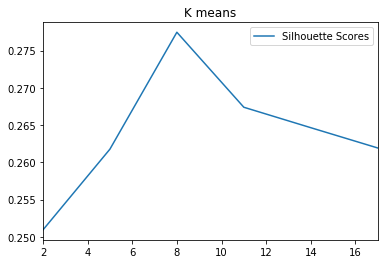

In [172]:
scores_df = pd.DataFrame(silhouette_scores, columns=['Silhouette Scores'], index=range(2,20,3))
scores_df.plot(title='K means')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.254627364629


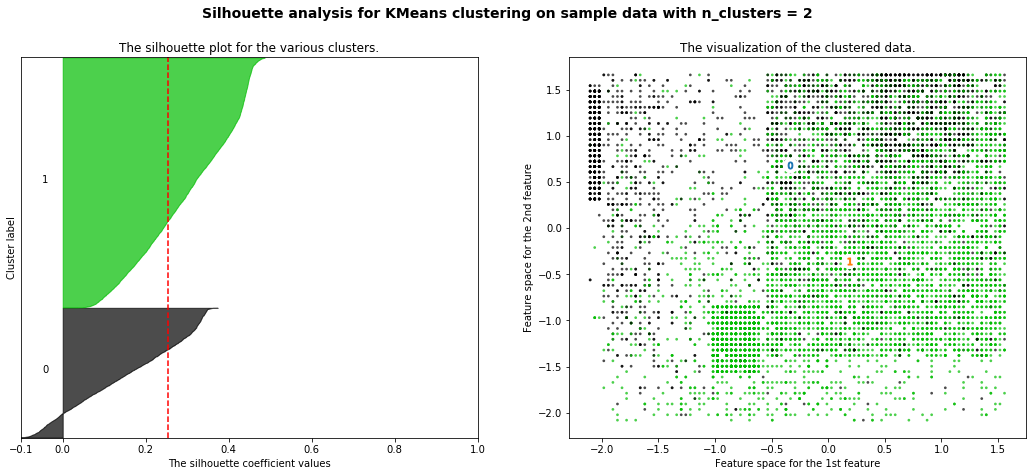

For n_clusters = 3 The average silhouette_score is : 0.242764577423


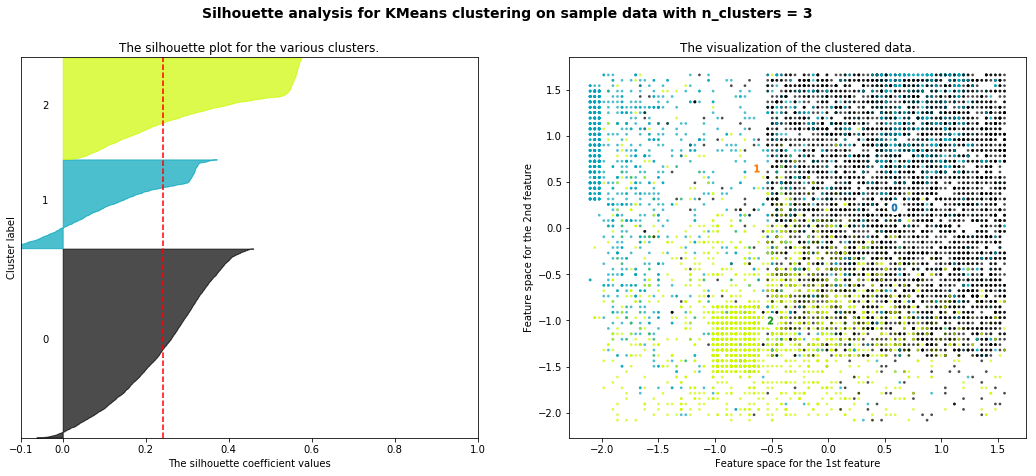

For n_clusters = 4 The average silhouette_score is : 0.27908527329


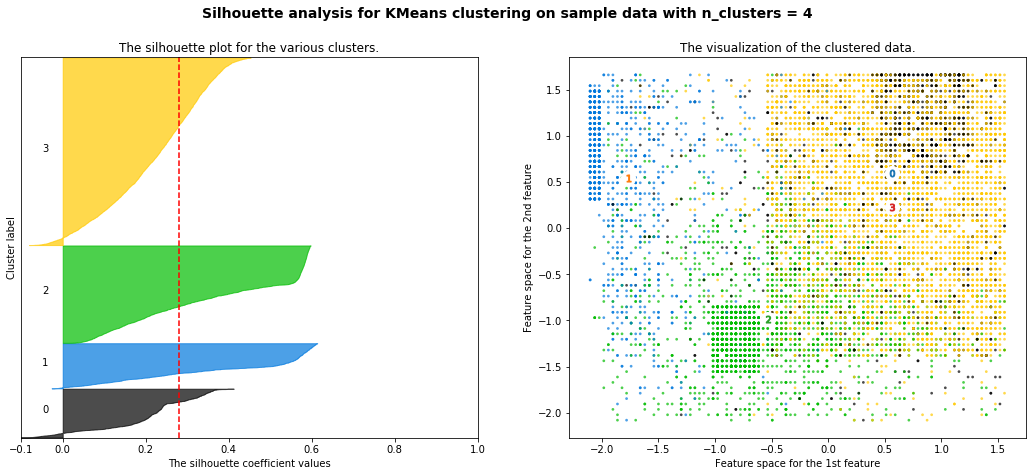

For n_clusters = 5 The average silhouette_score is : 0.261758996432


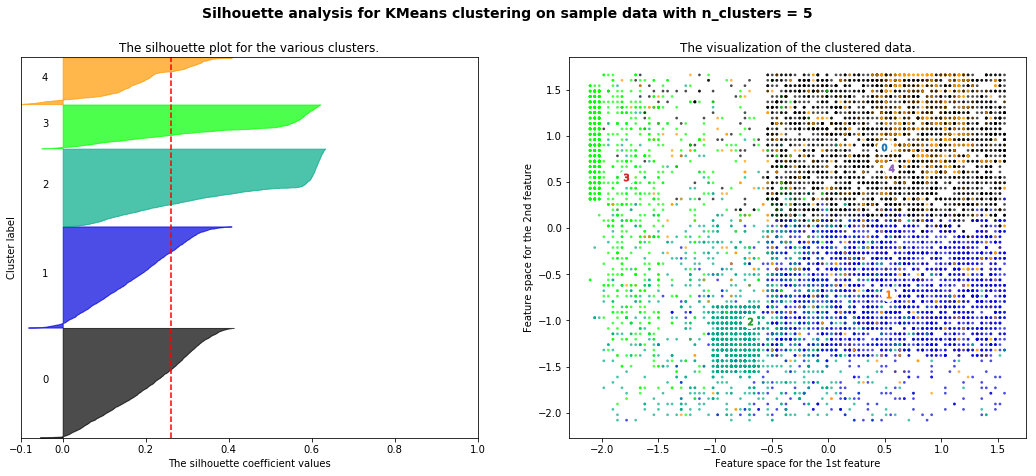

For n_clusters = 6 The average silhouette_score is : 0.267975229722


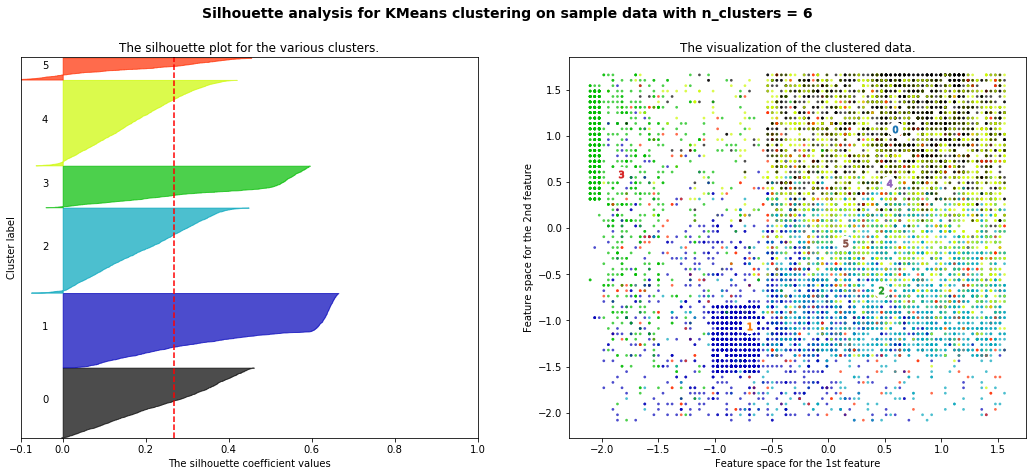

In [167]:
# silhouette analysis
print_silhouette_analysis(X_train_hr.ix[:,:5].values)

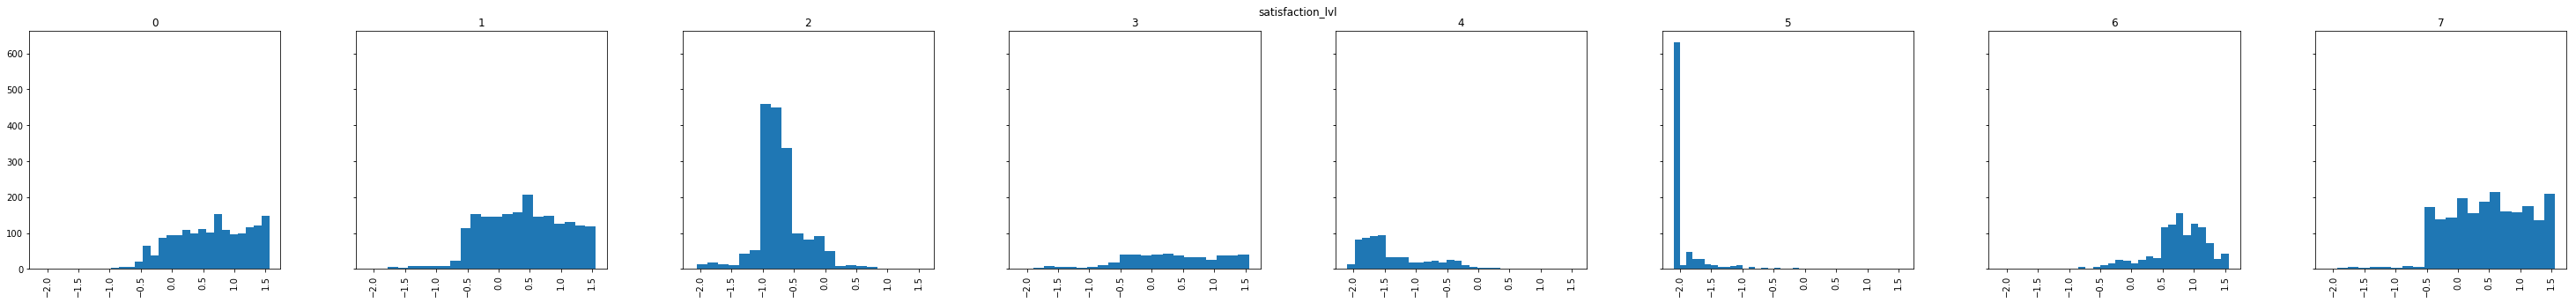

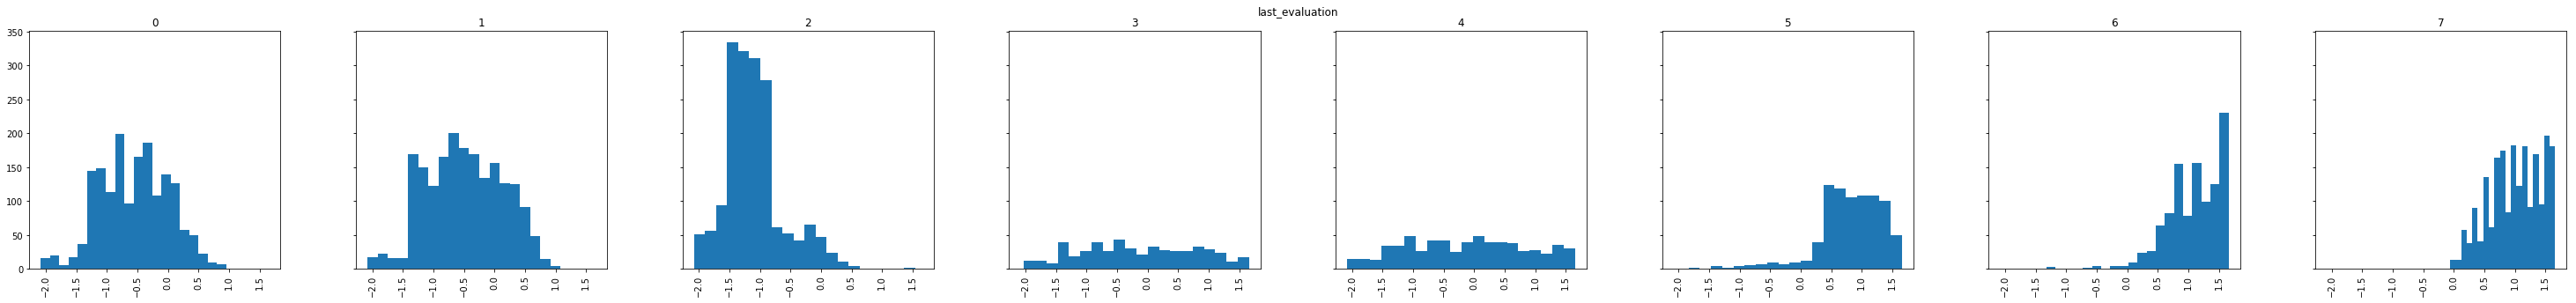

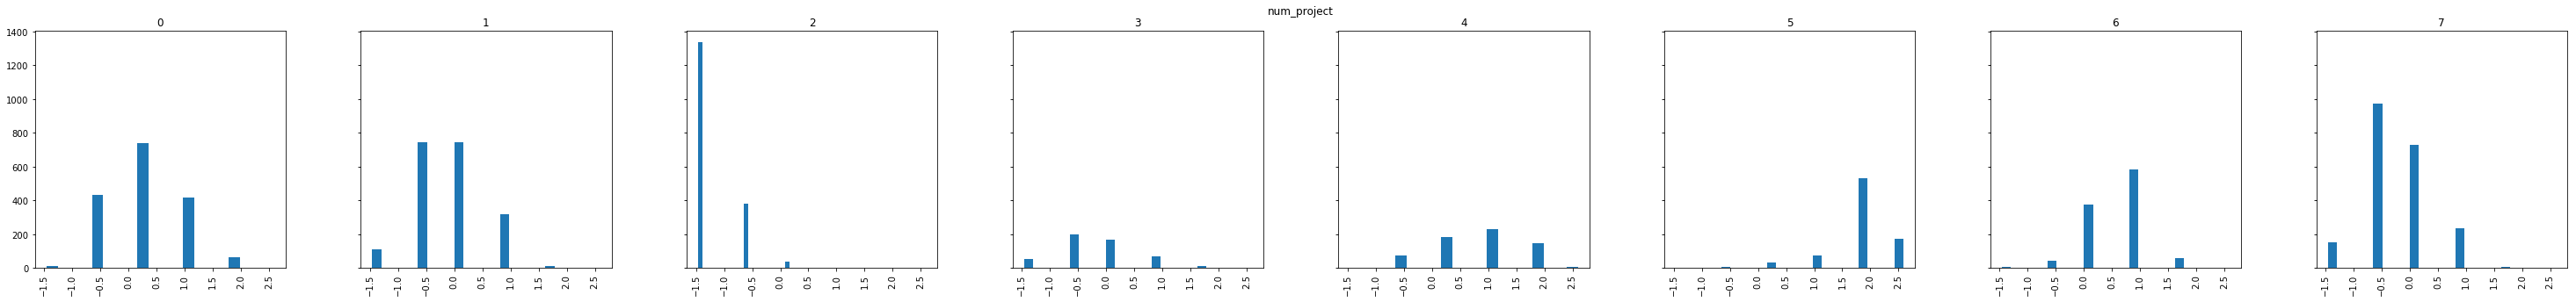

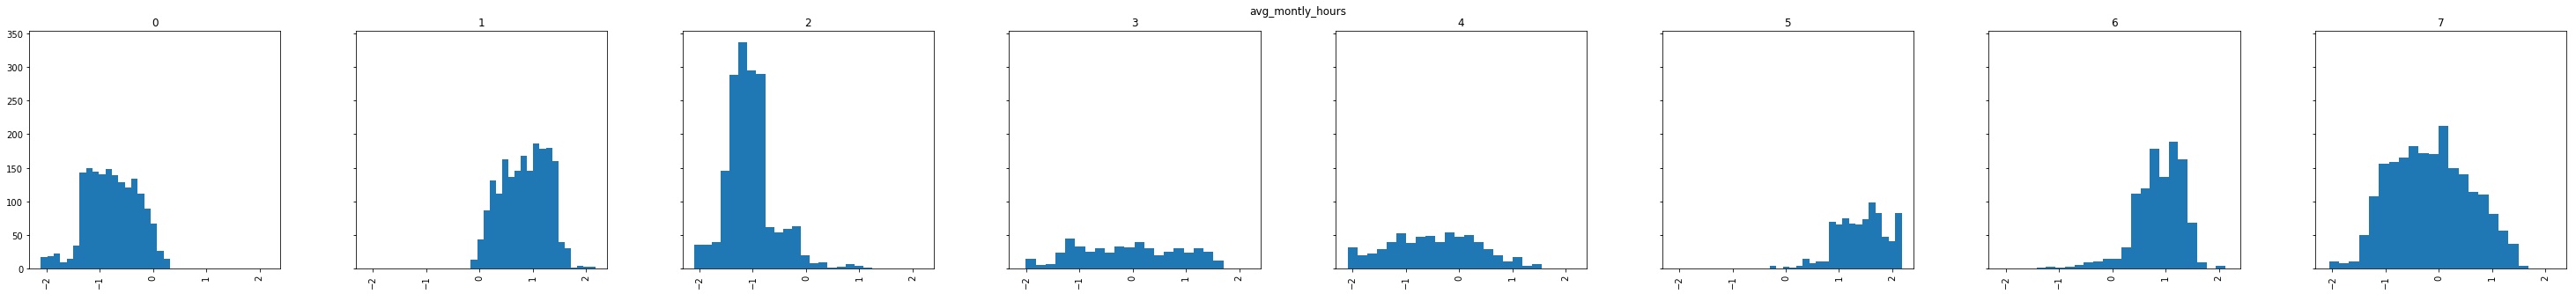

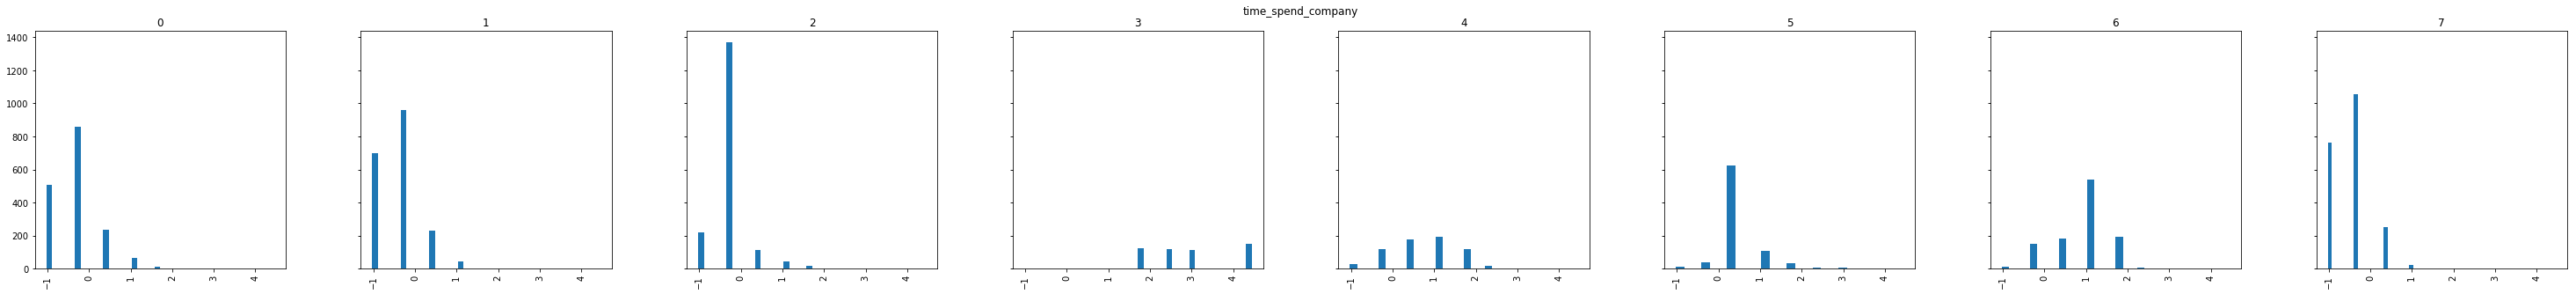

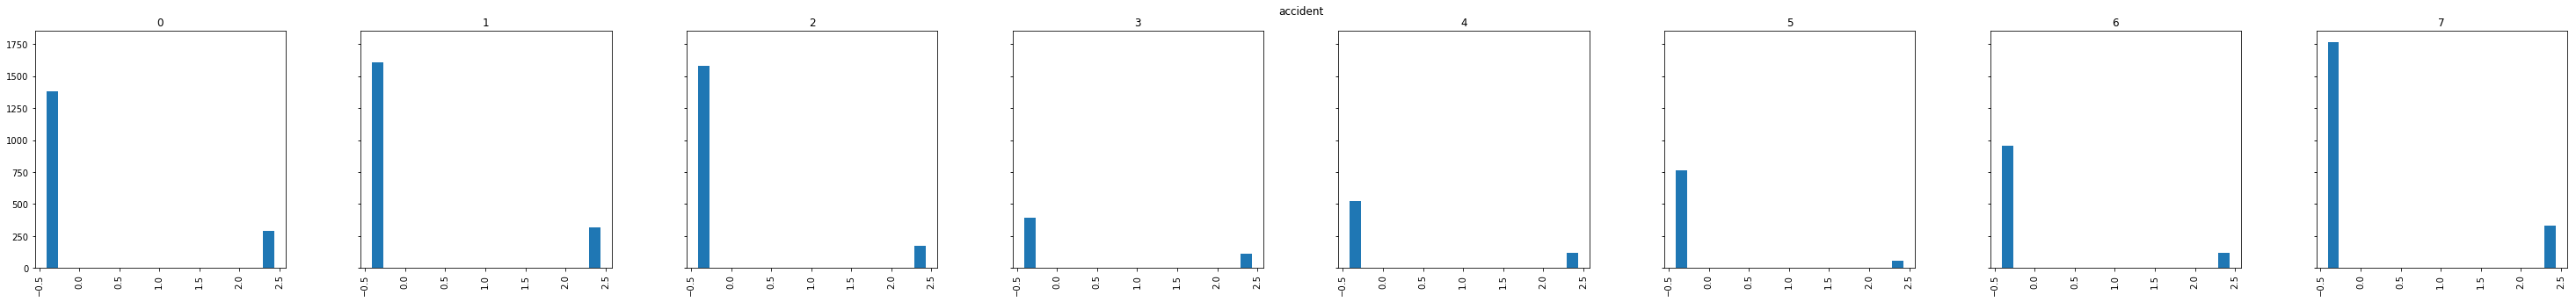

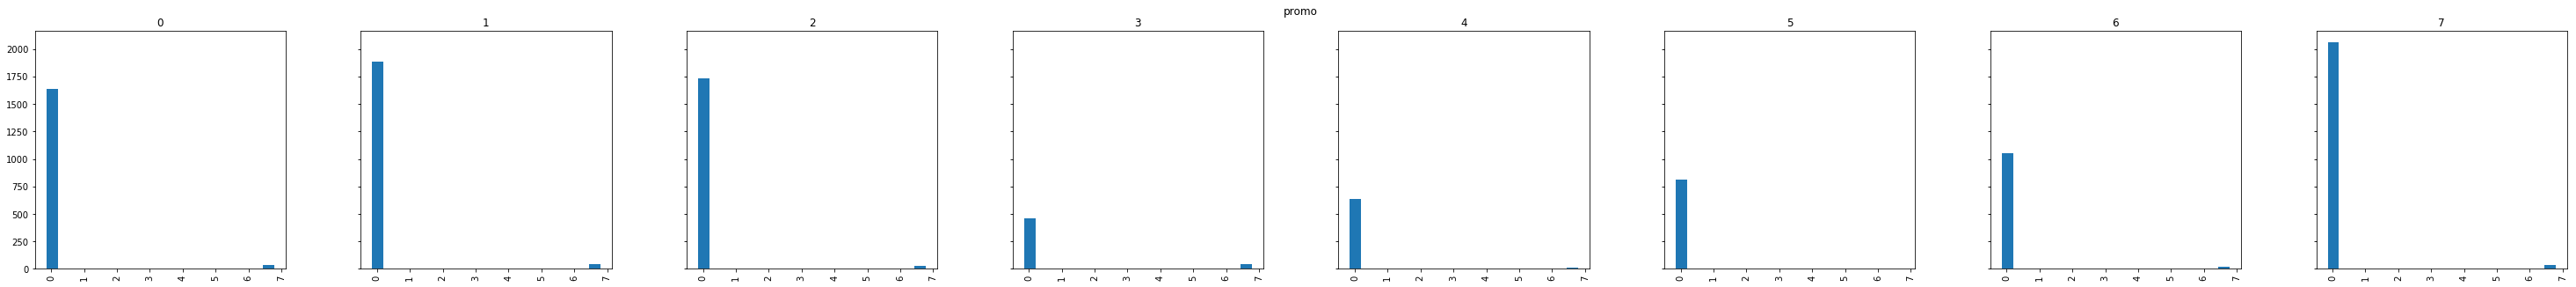

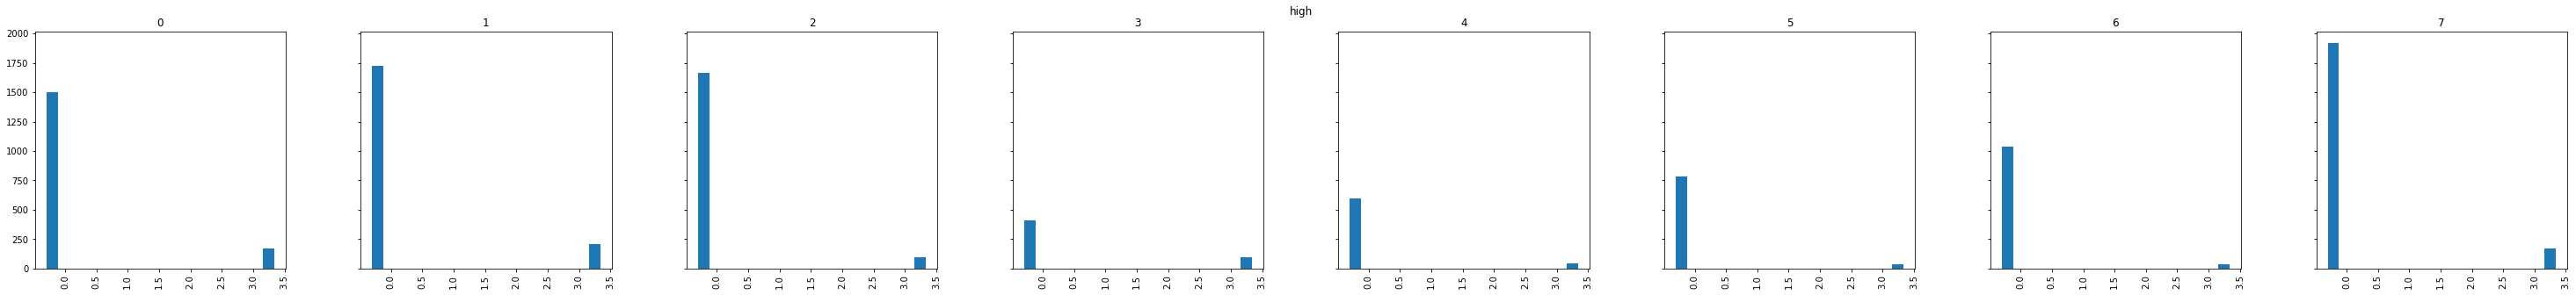

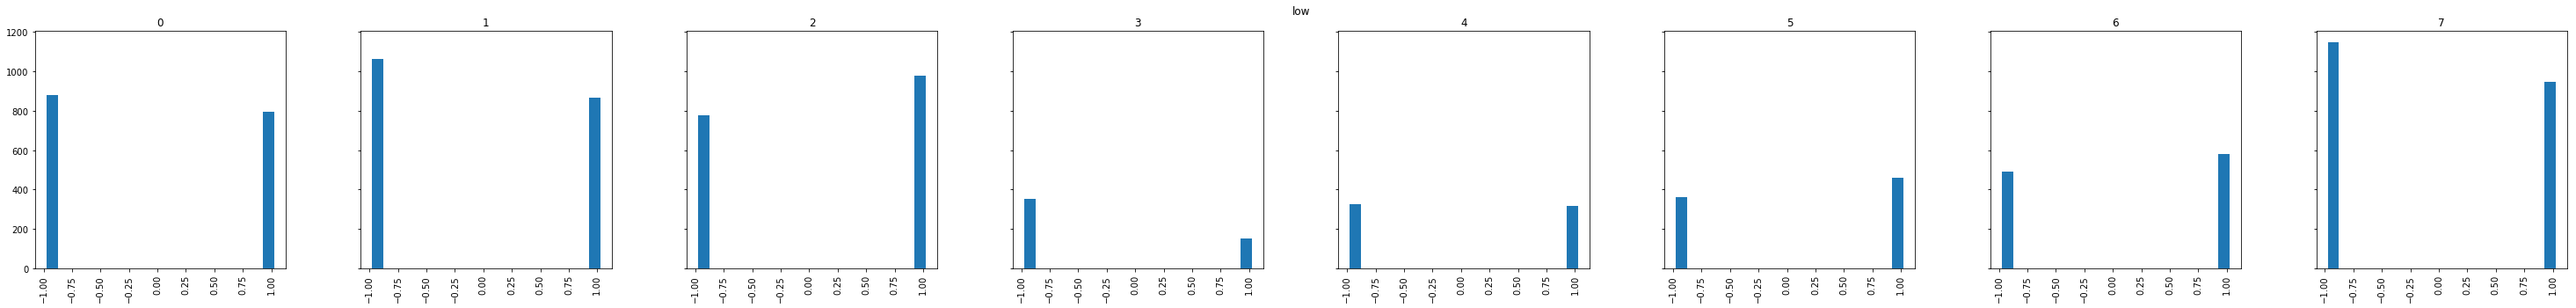

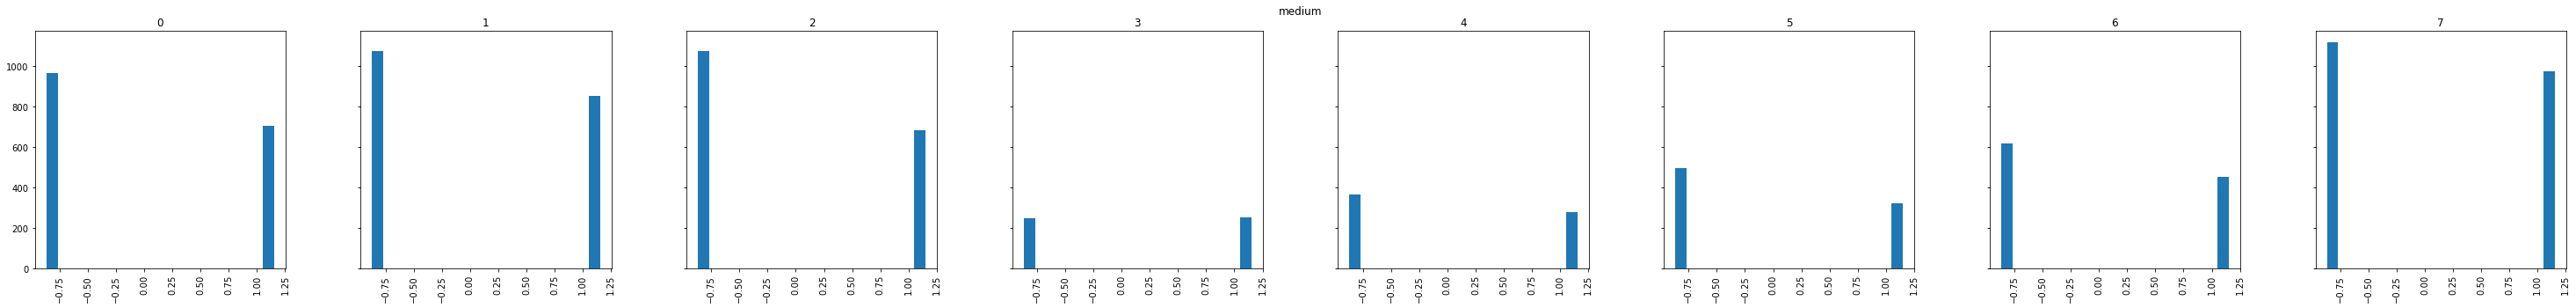

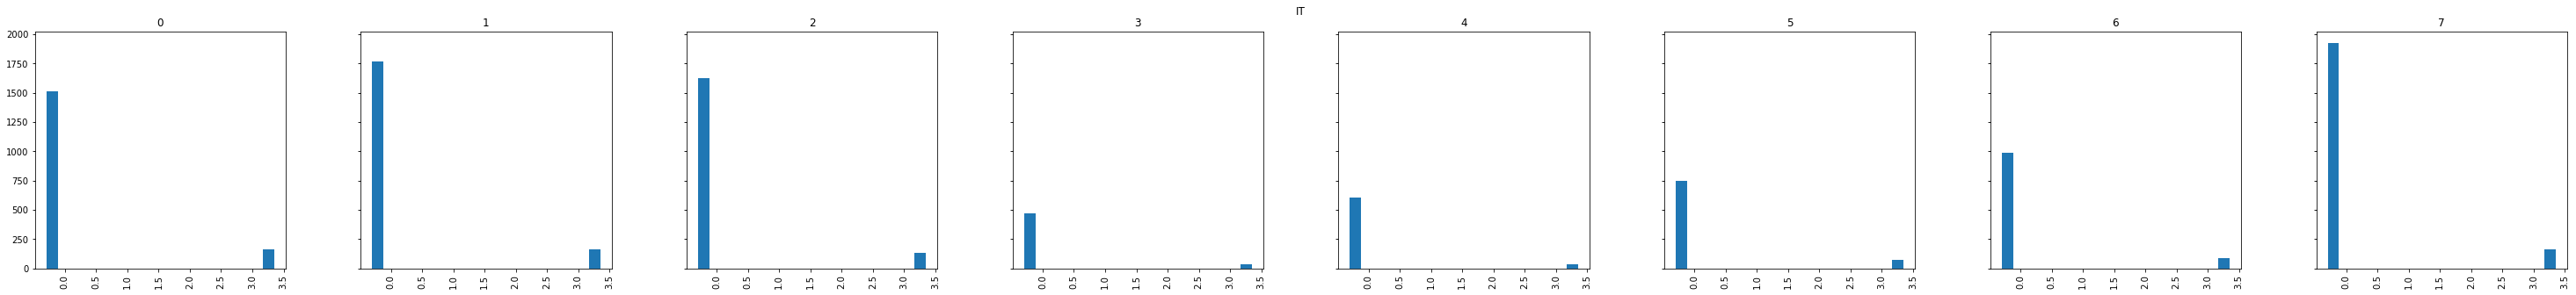

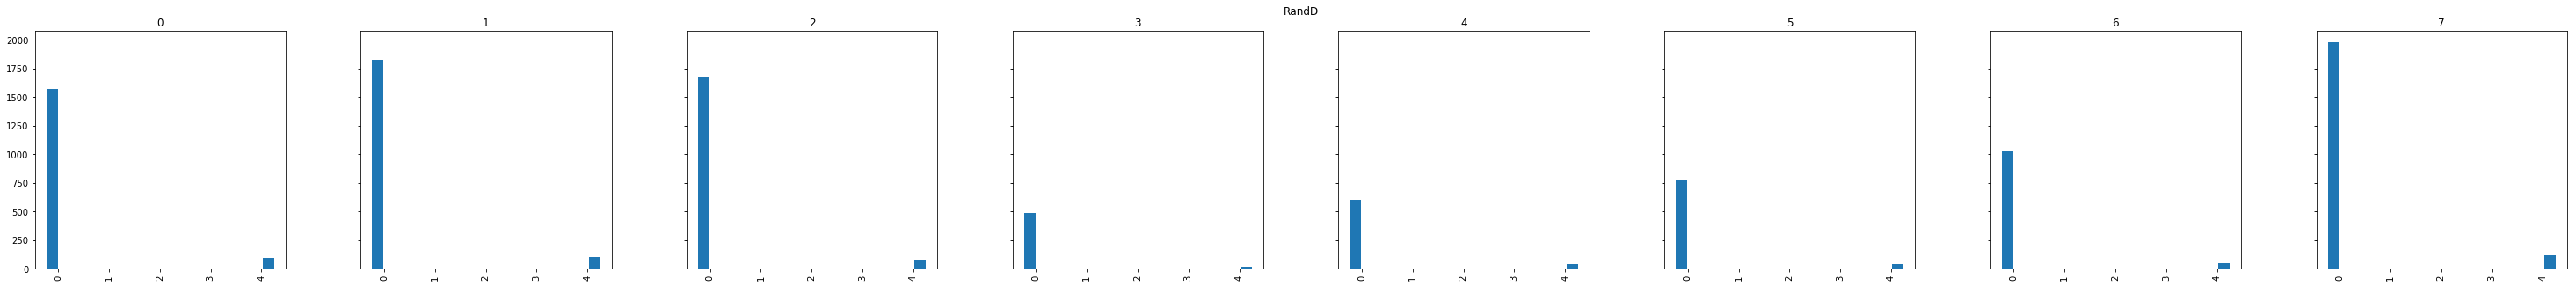

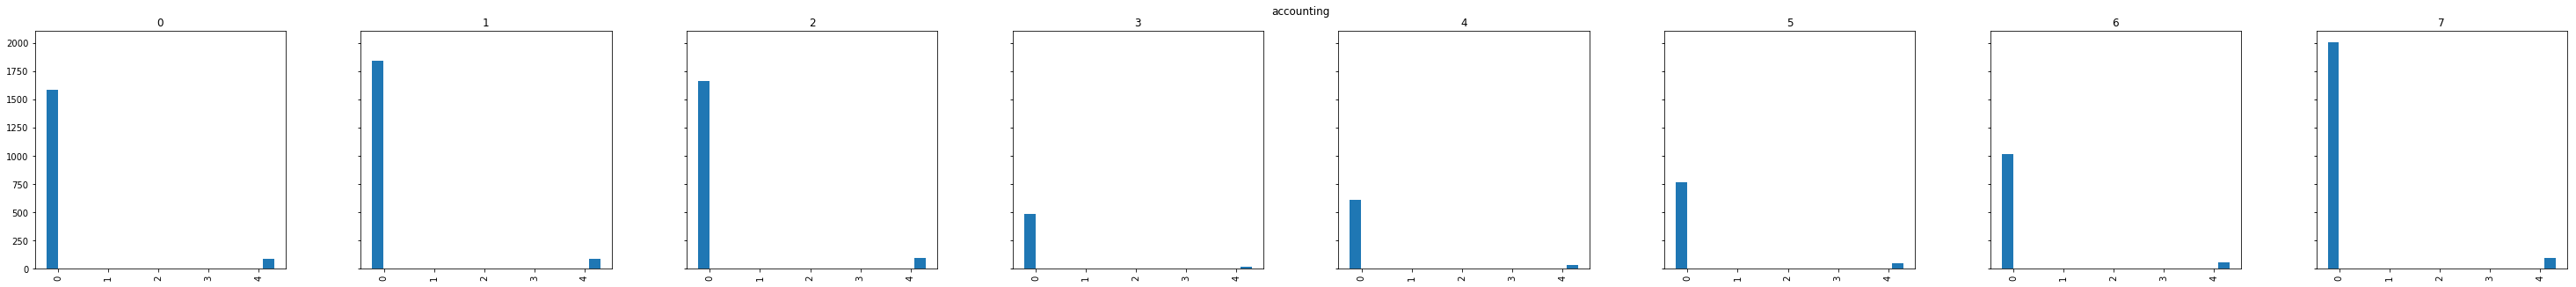

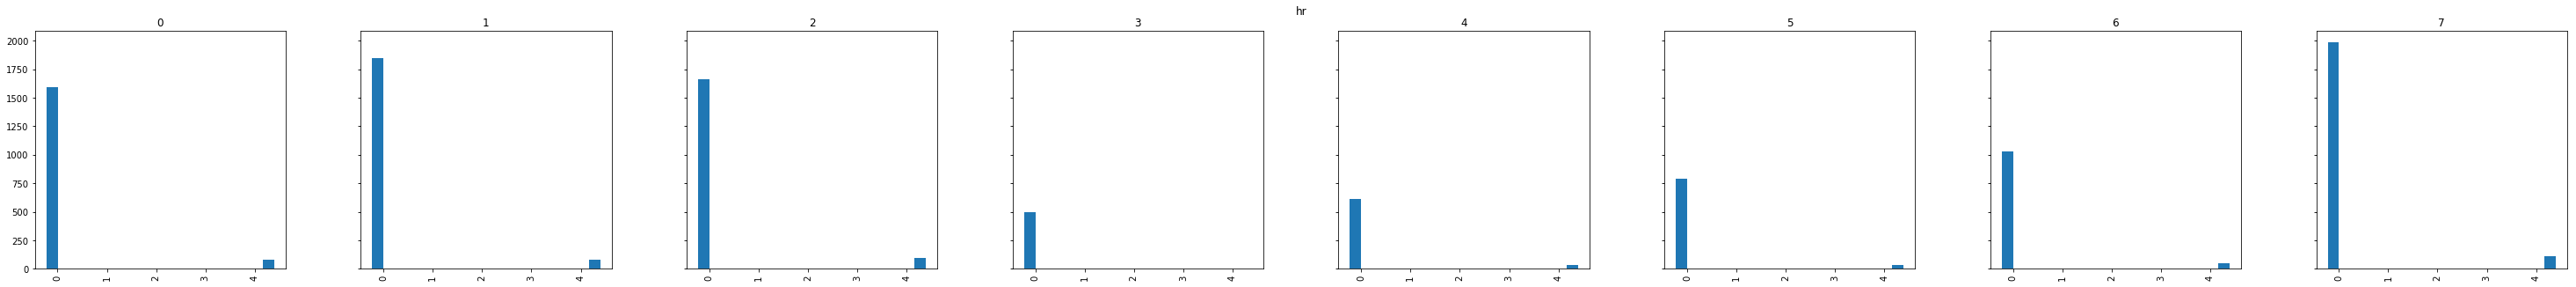

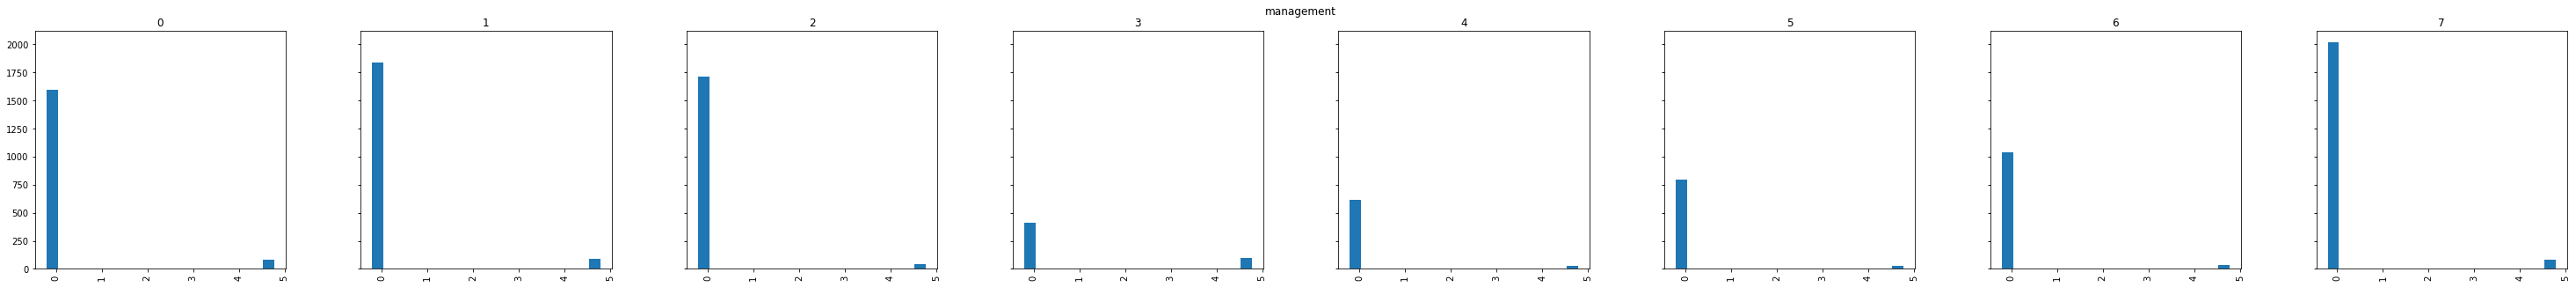

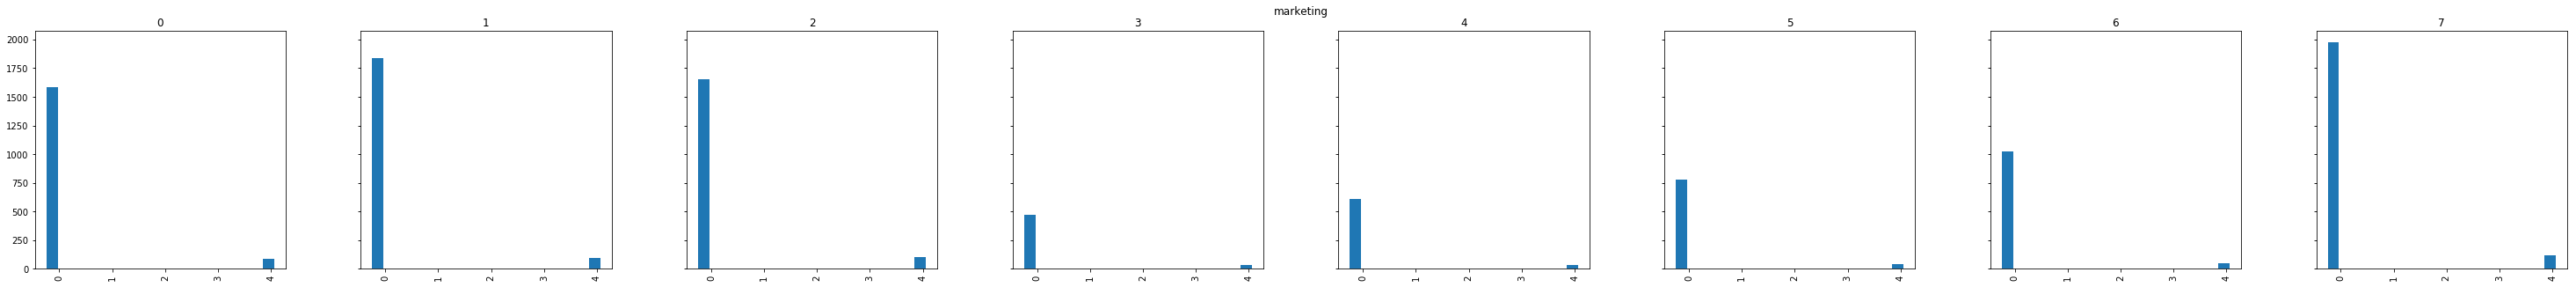

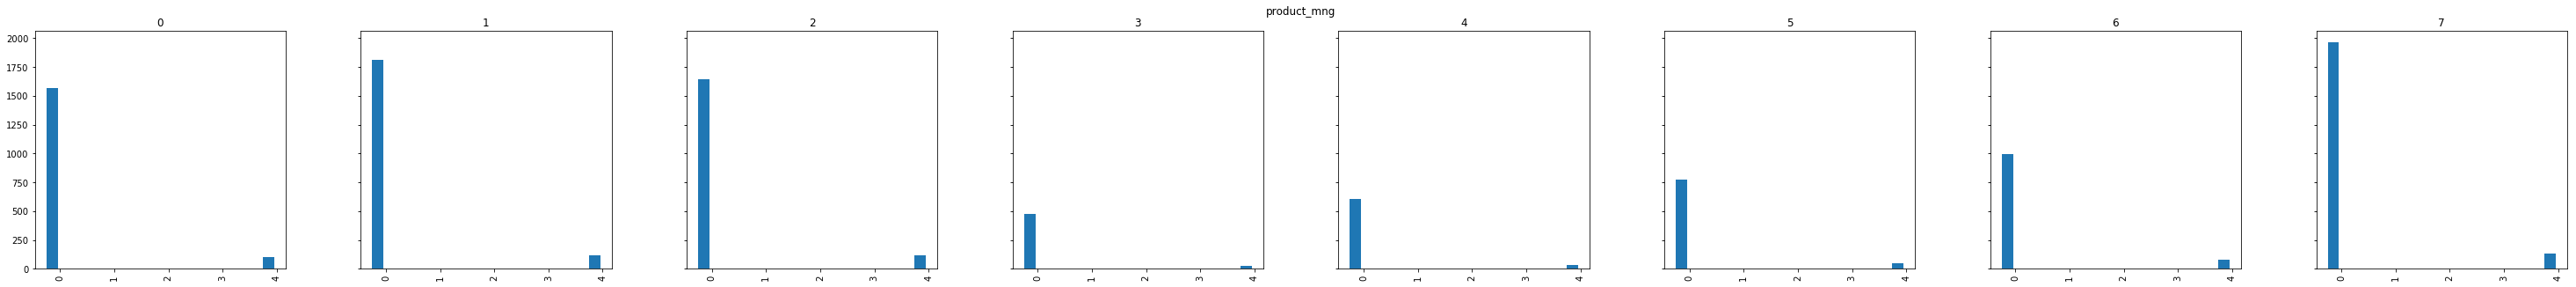

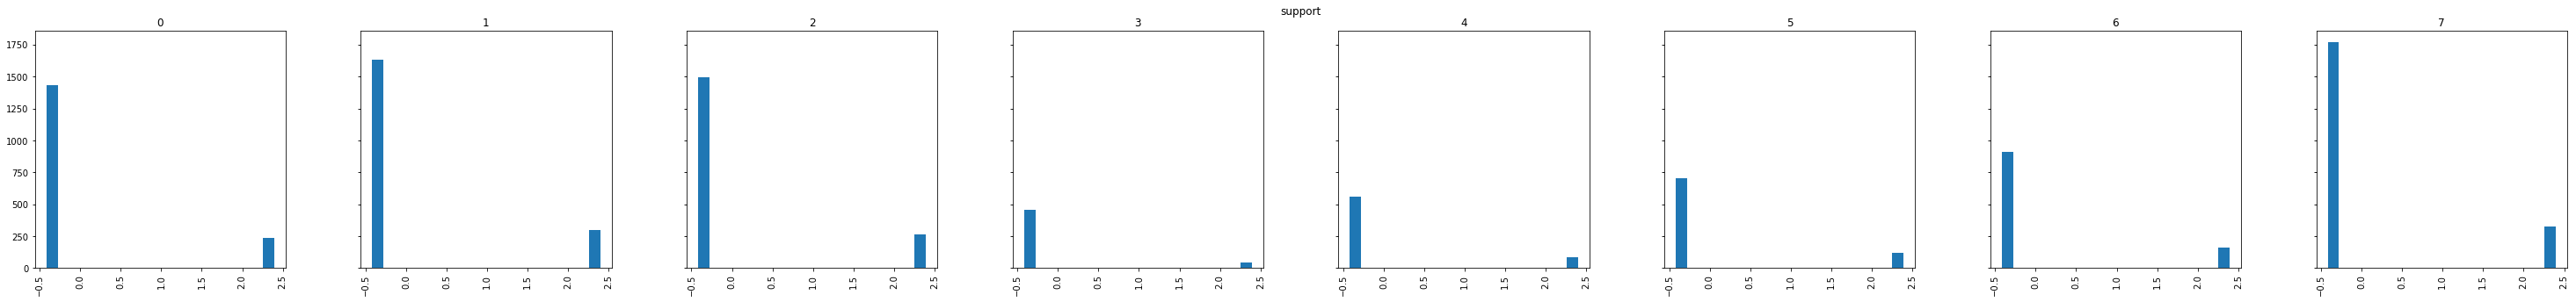

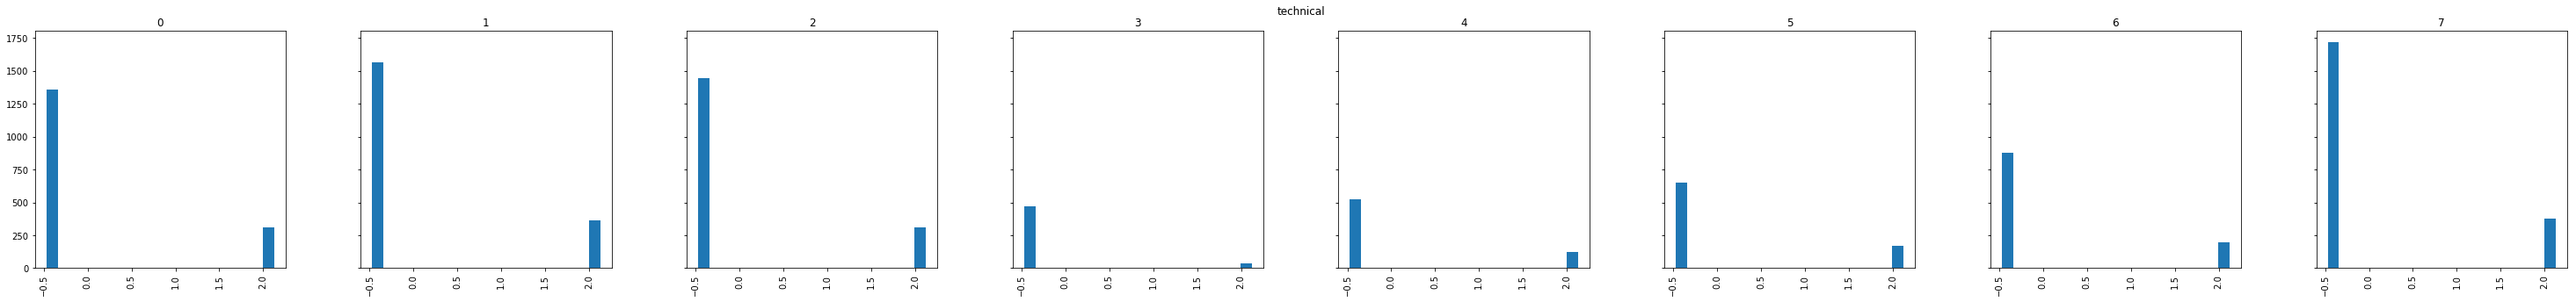

In [168]:
from matplotlib import interactive
interactive(True)

# visualize the distribution of data by using the best k value
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_train_hr.ix[:,:5])
labels = kmeans.labels_

for feature in X_train_hr.columns:
    ax = X_train_hr[feature].hist(figsize=(50,5), bins=20, by=labels, sharex=True, sharey=True, layout=(1,8))
    pl.suptitle(feature)
    
plt.show()

#### EM

In [169]:
bic_scores = []
for i in range(2,20,3):
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='spherical')
    gmm.fit(X_train_hr.ix[:,:5])
    labels = gmm.predict(X_train_hr.ix[:,:5])
    spherical = gmm.bic(X_train_hr.ix[:,:5])
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied')
    gmm.fit(X_train_hr.ix[:,:5])
    labels = gmm.predict(X_train_hr.ix[:,:5])
    tied = gmm.bic(X_train_hr.ix[:,:5])
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='diag')
    gmm.fit(X_train_hr.ix[:,:5])
    labels = gmm.predict(X_train_hr.ix[:,:5])
    diag = gmm.bic(X_train_hr.ix[:,:5])
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='full')
    gmm.fit(X_train_hr.ix[:,:5])
    labels = gmm.predict(X_train_hr.ix[:,:5])
    full = gmm.bic(X_train_hr.ix[:,:5])
    
    bic_scores.append((spherical, tied, diag, full))

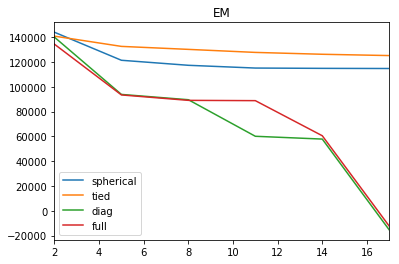

In [173]:
scores_df = pd.DataFrame(bic_scores)
scores_df = scores_df
scores_df.columns = ['spherical', 'tied', 'diag', 'full']
scores_df.index = range(2,20,3)
scores_df.plot(title='EM')
plt.show()

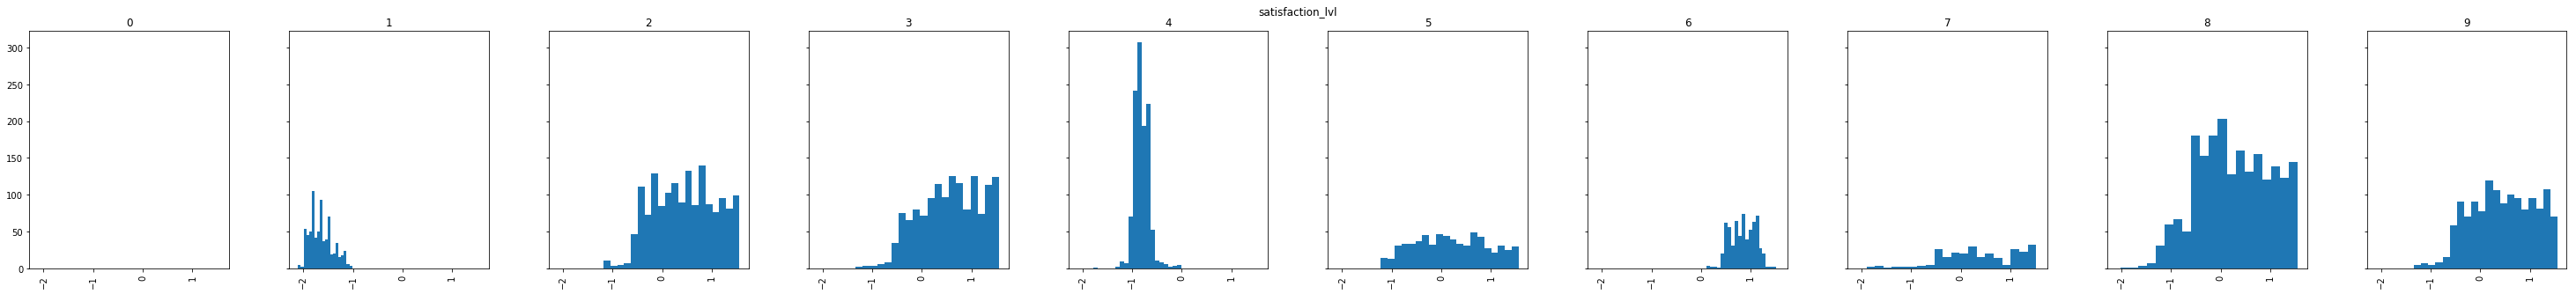

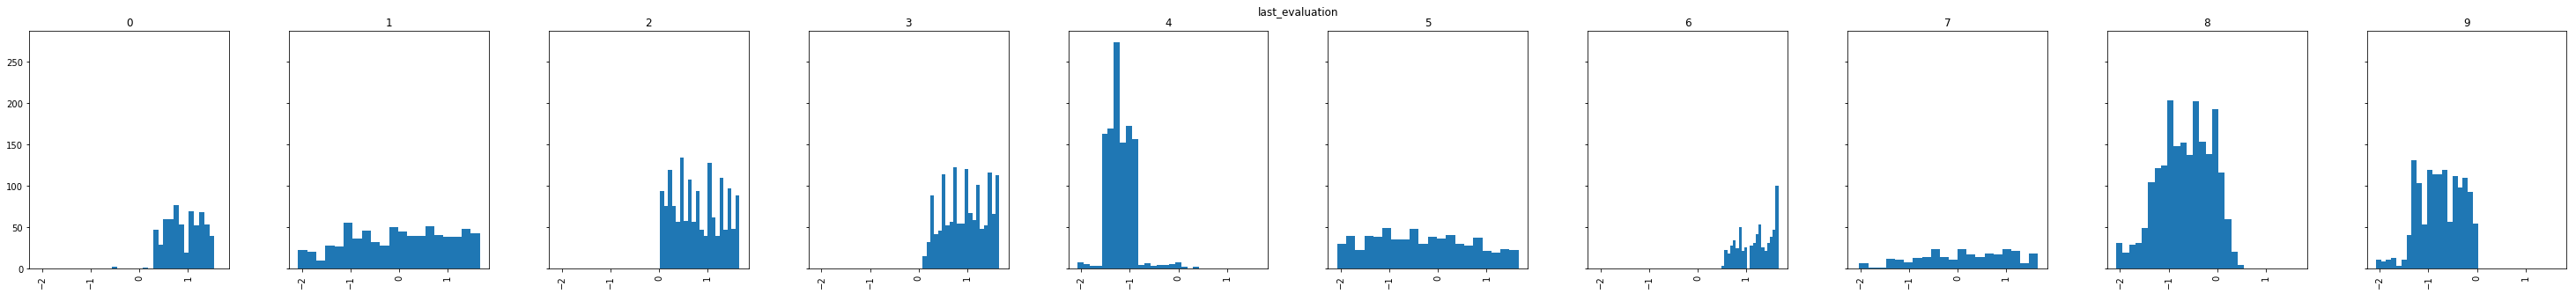

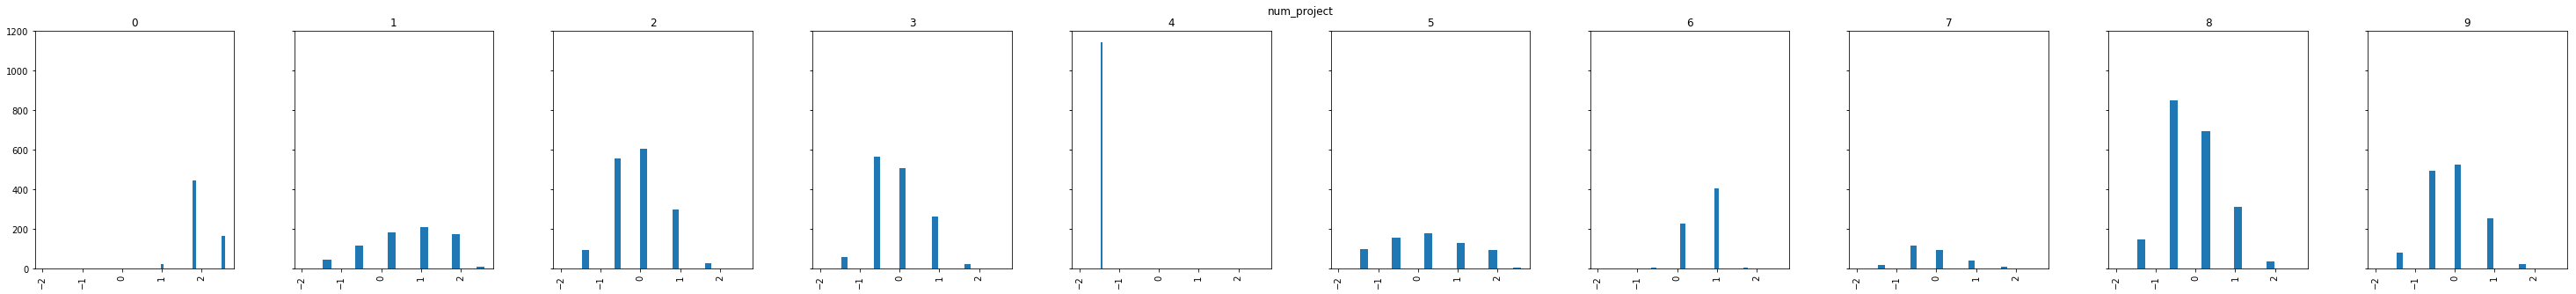

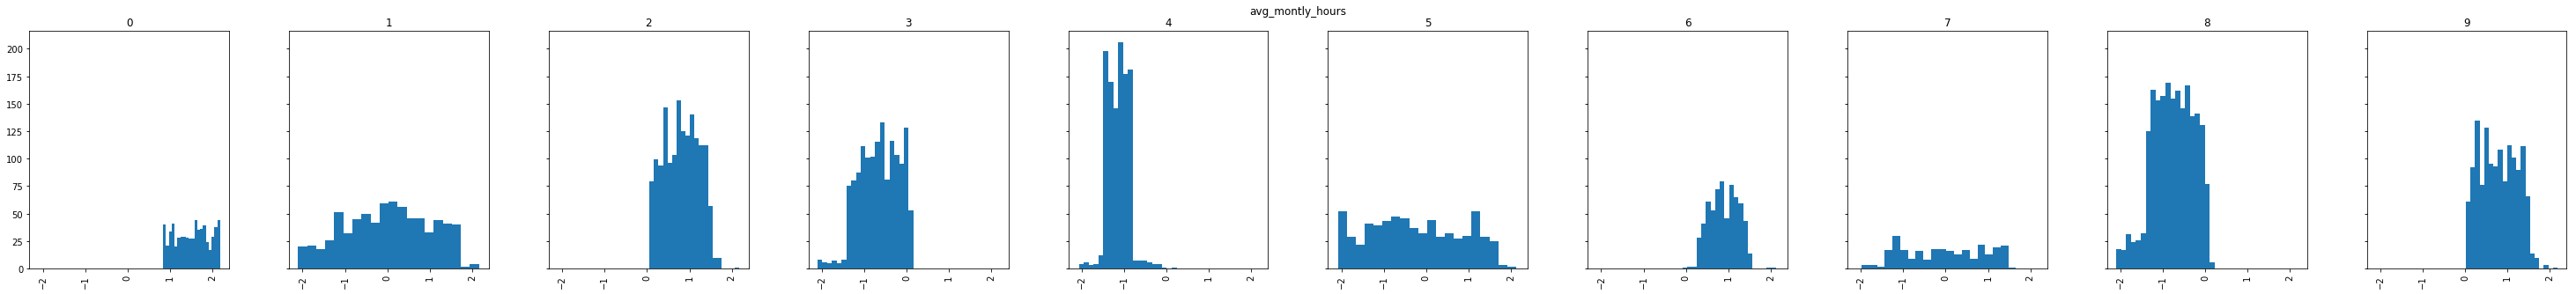

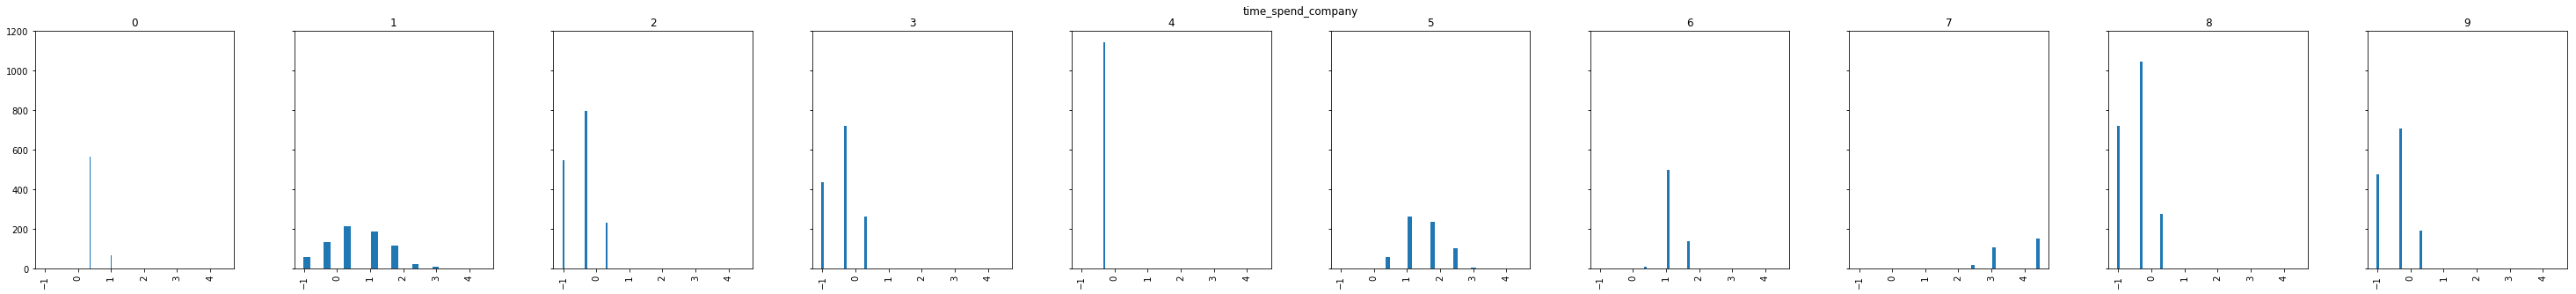

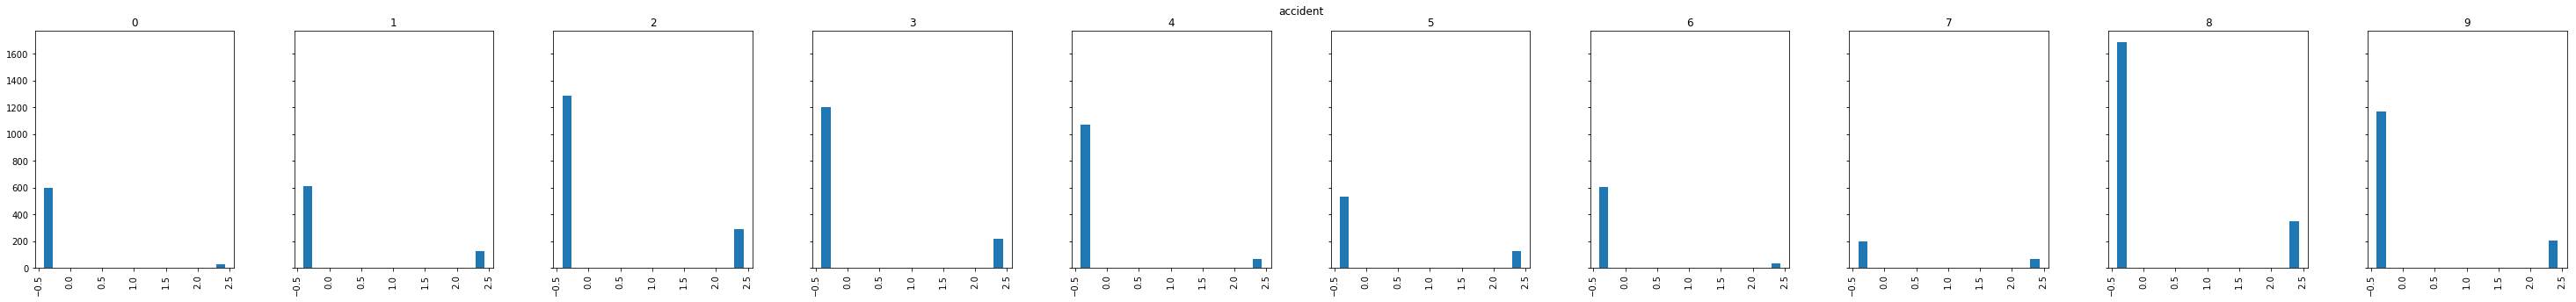

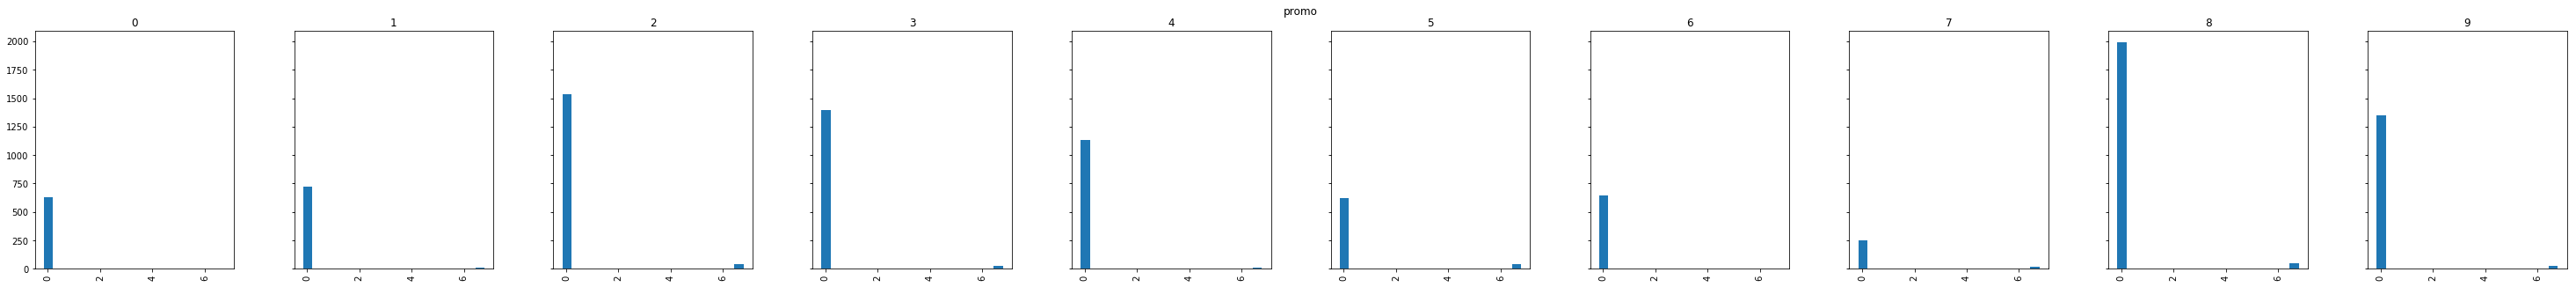

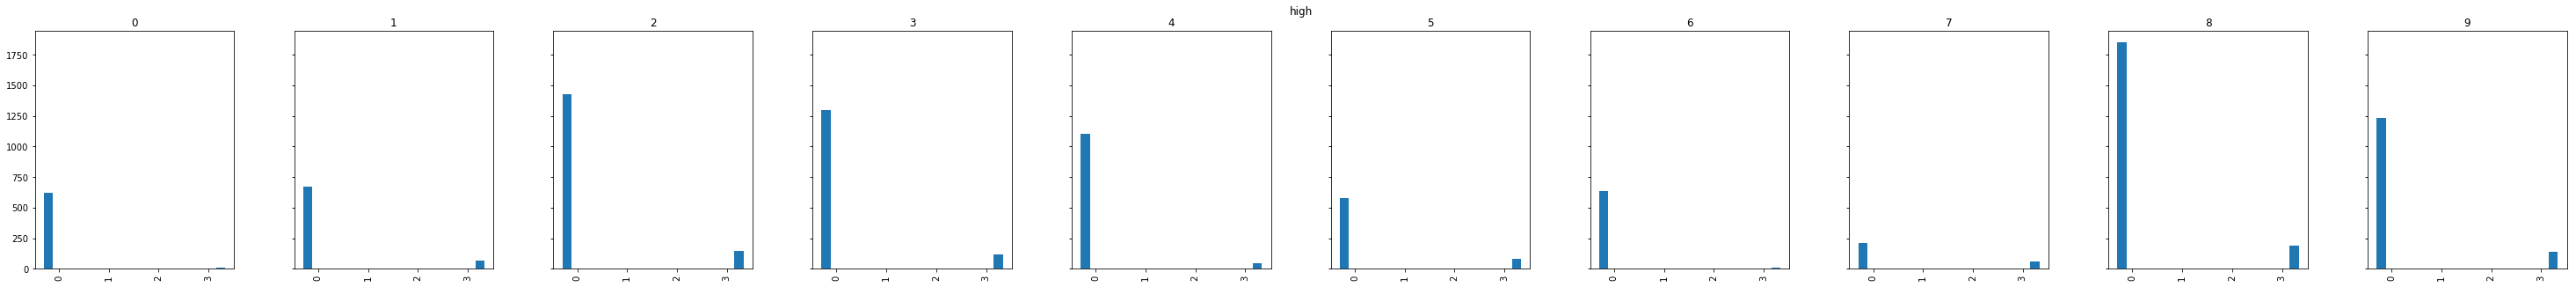

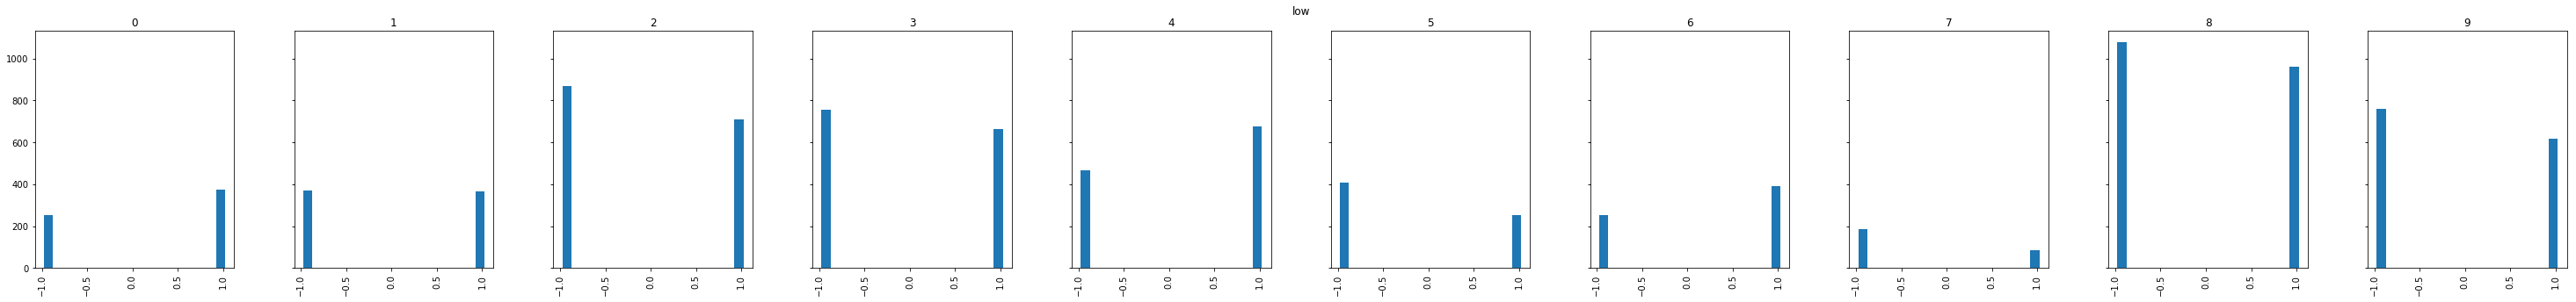

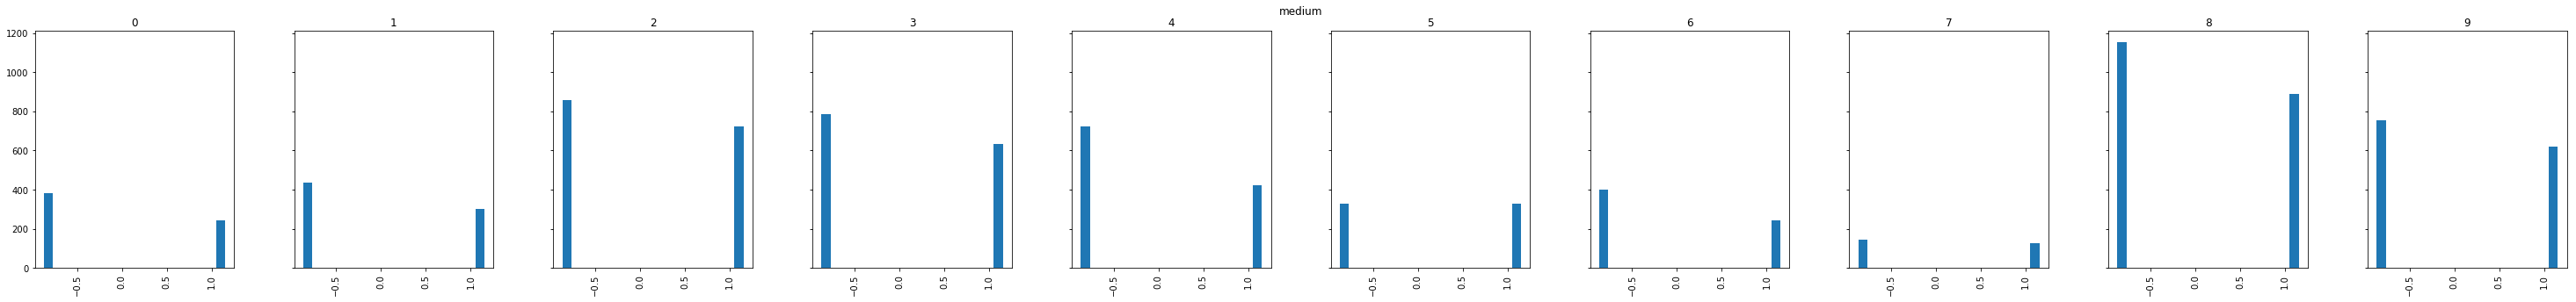

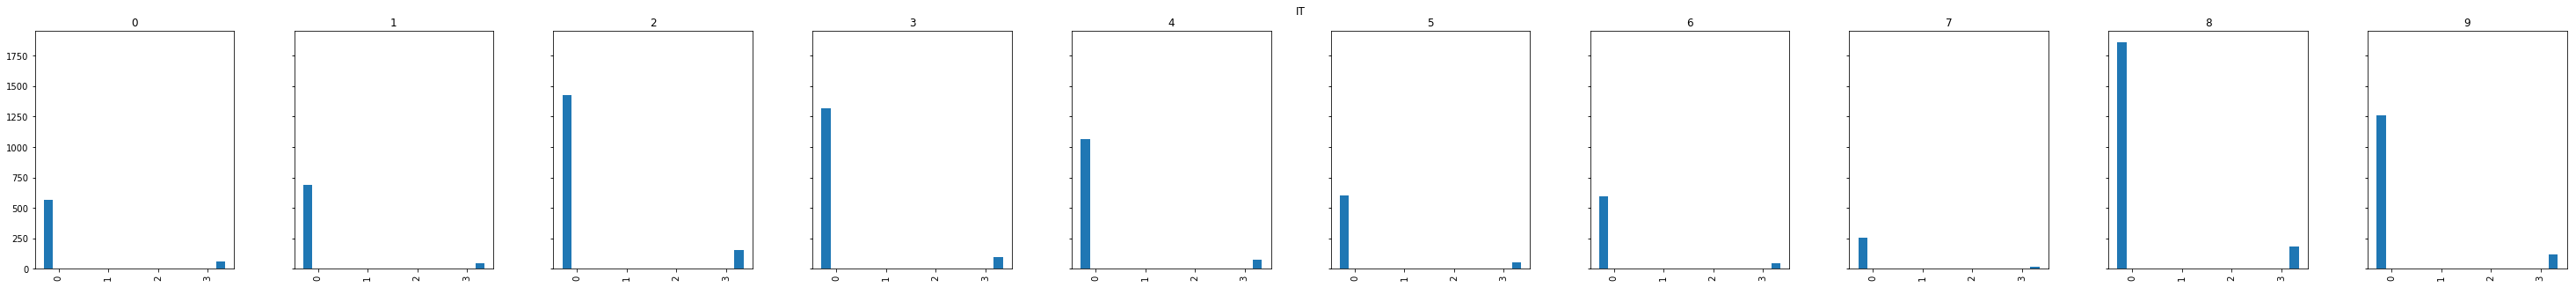

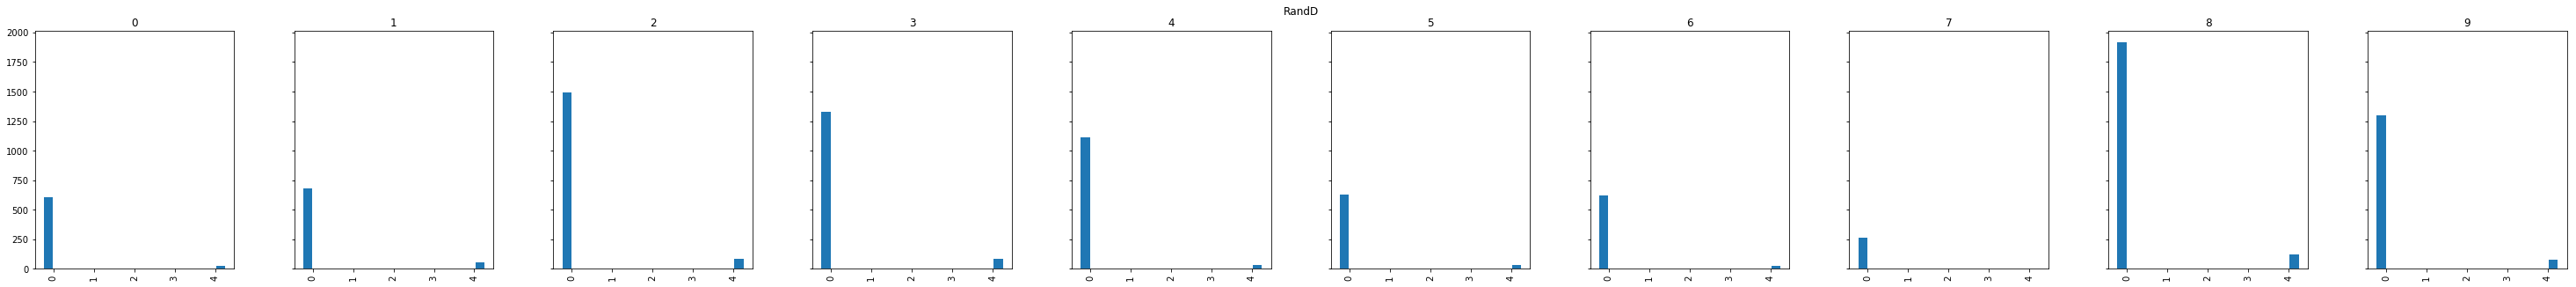

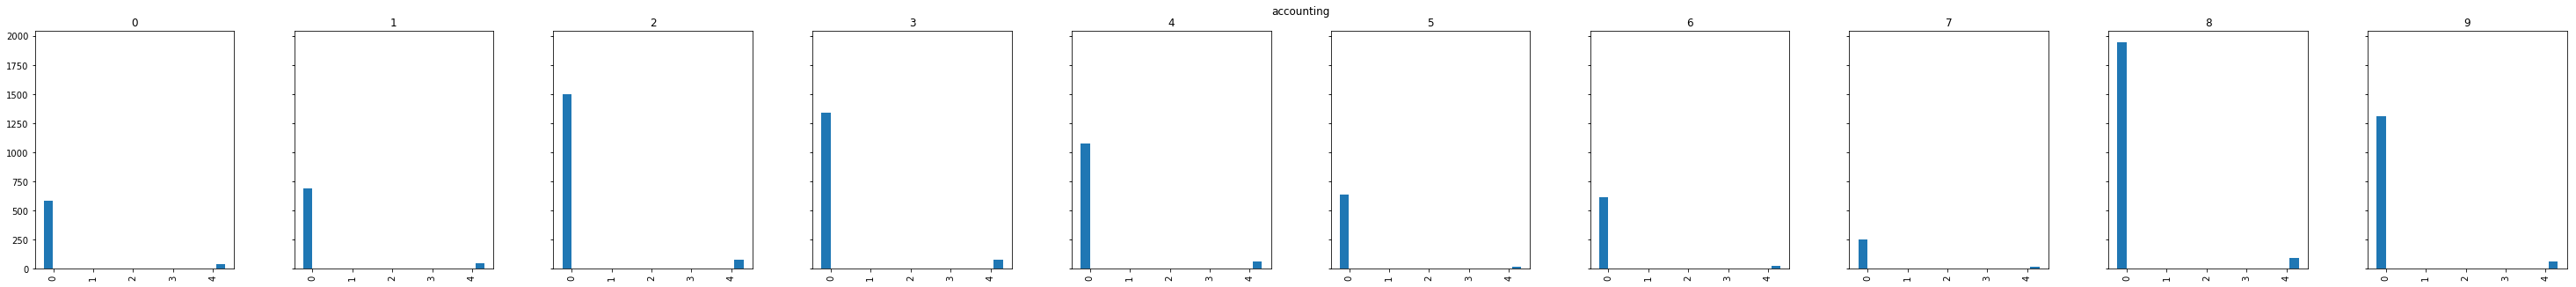

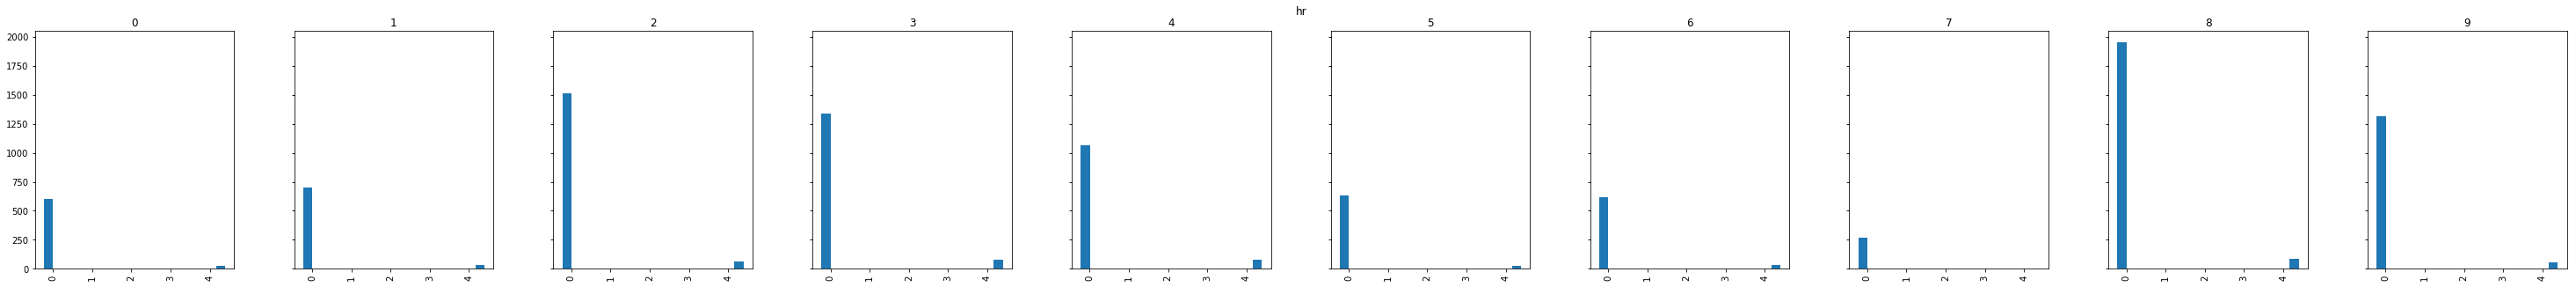

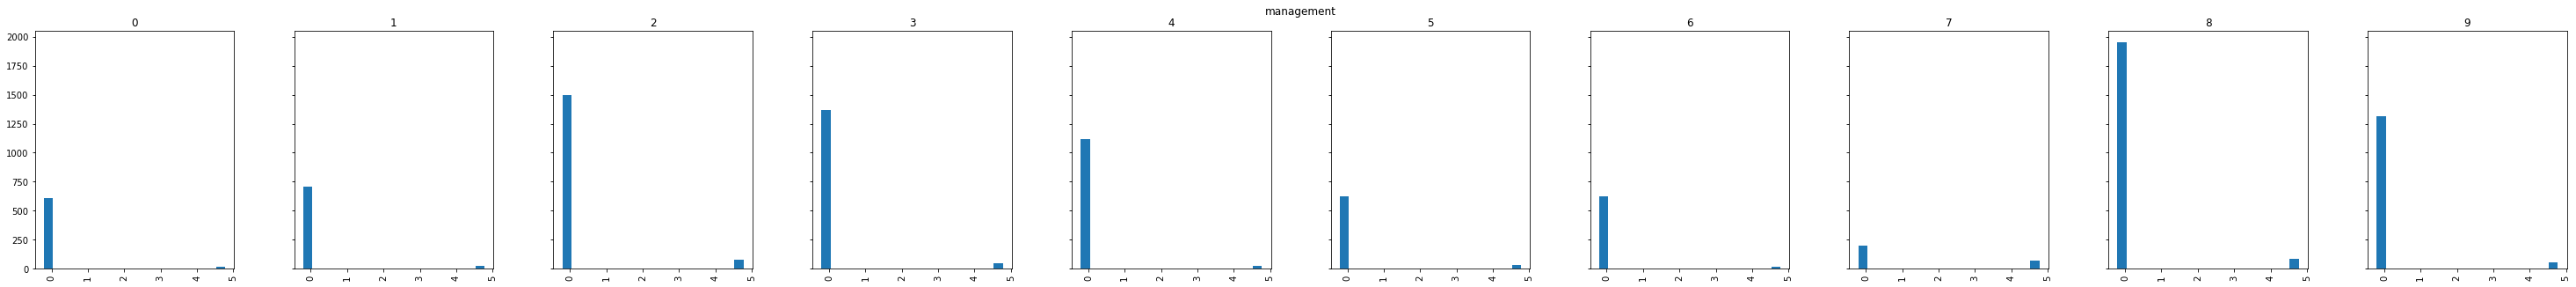

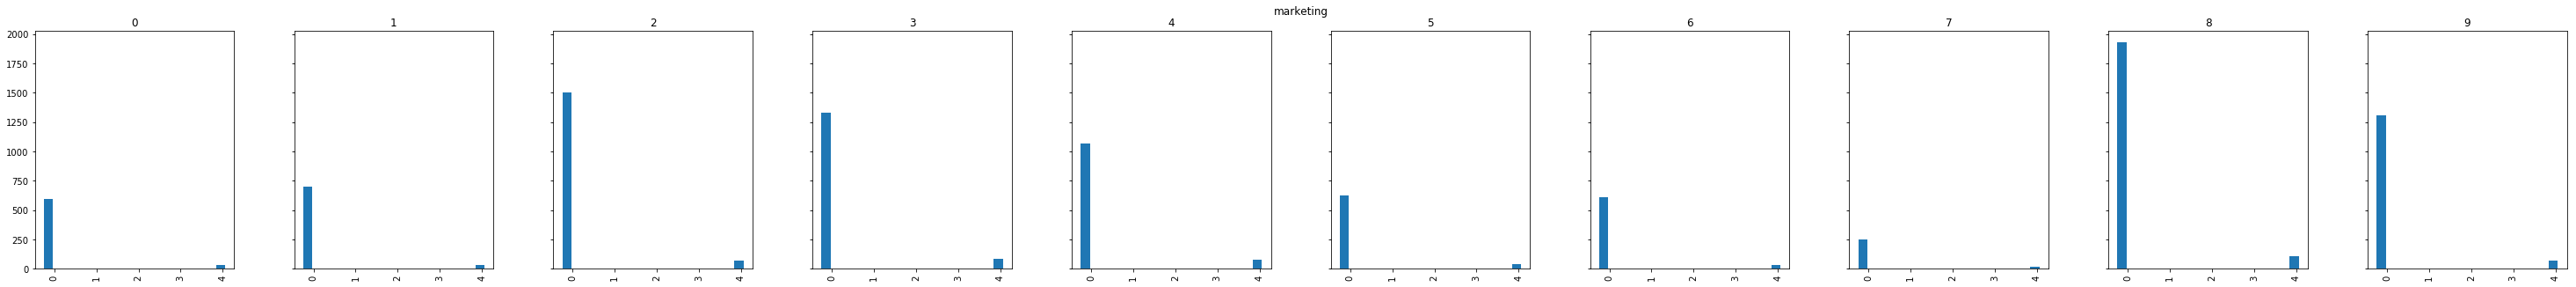

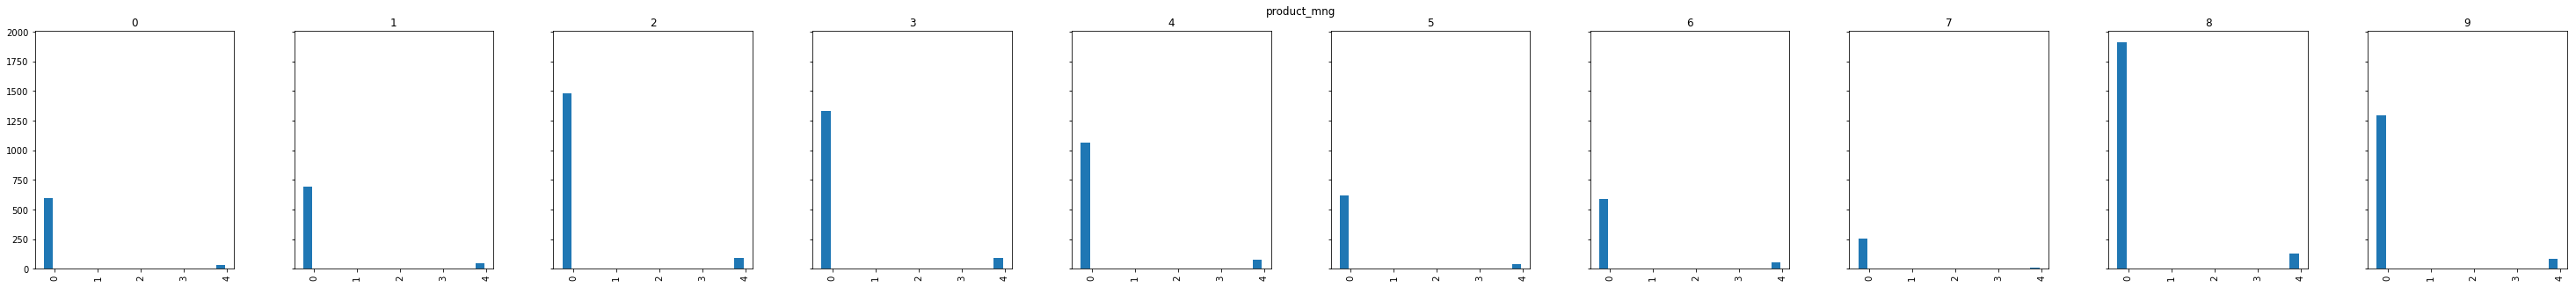

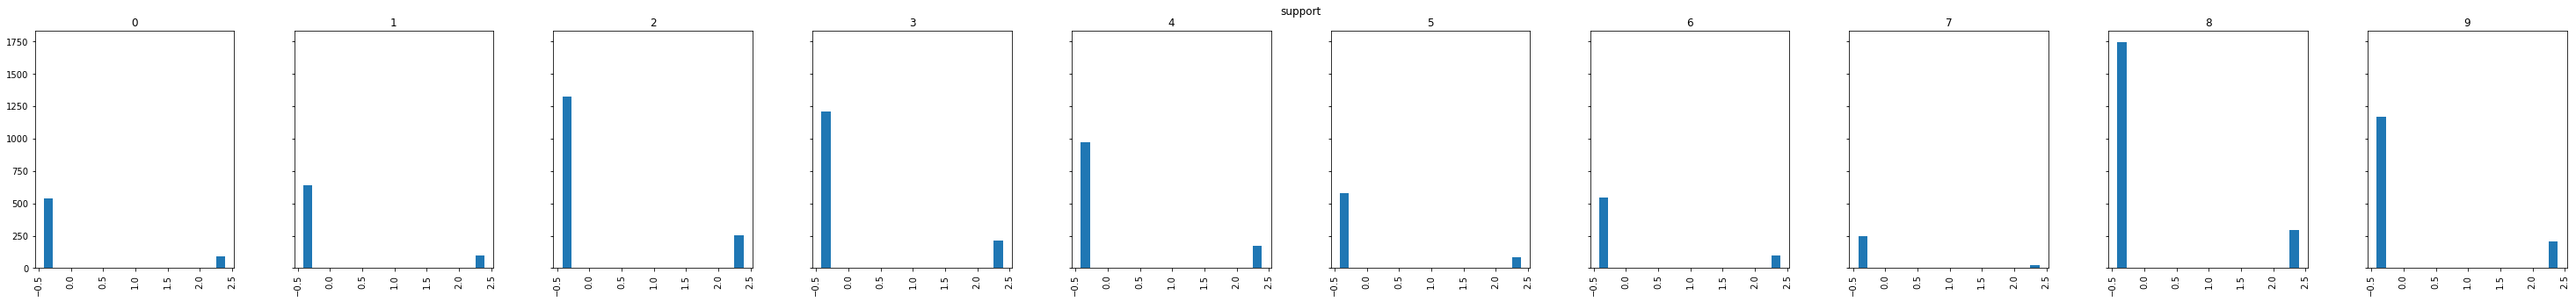

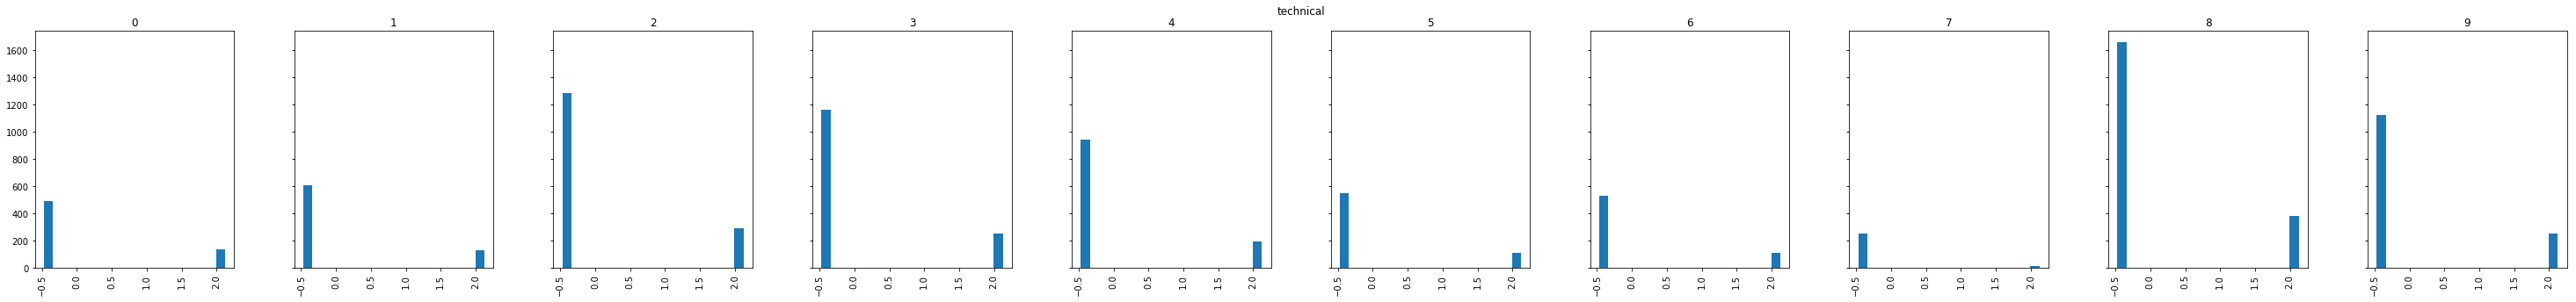

In [171]:
# visualize the distribution of data by using the best k value
gmm = mixture.GaussianMixture(n_components=10, covariance_type='diag')
gmm.fit(X_train_hr.ix[:,:5])
labels = gmm.predict(X_train_hr.ix[:,:5])

for feature in X_train_hr.columns:
    ax = X_train_hr[feature].hist(figsize=(50,5), bins=20, by=labels, sharex=True, sharey=True, layout=(1,10))
    pl.suptitle(feature)
    
plt.show()

### Letter Recognition

#### K-means

In [185]:
silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_train_letter)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_train_letter, labels, metric='euclidean'))

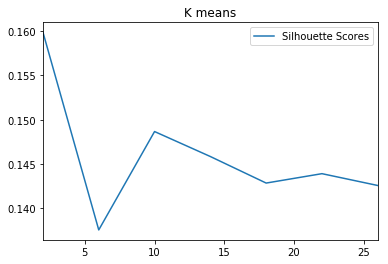

In [186]:
scores_df = pd.DataFrame(silhouette_scores, columns=['Silhouette Scores'], index=range(2,28,4))
scores_df.plot(title='K means')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.159848070252


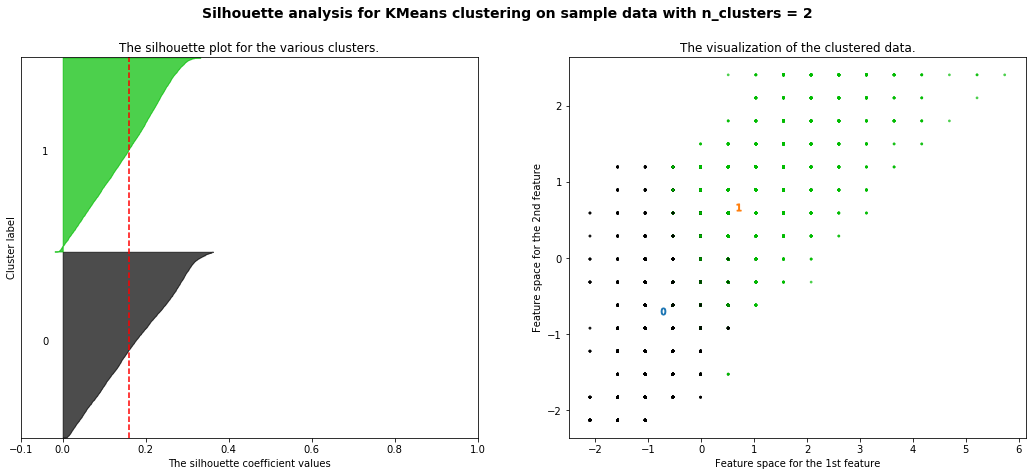

For n_clusters = 3 The average silhouette_score is : 0.150653757493


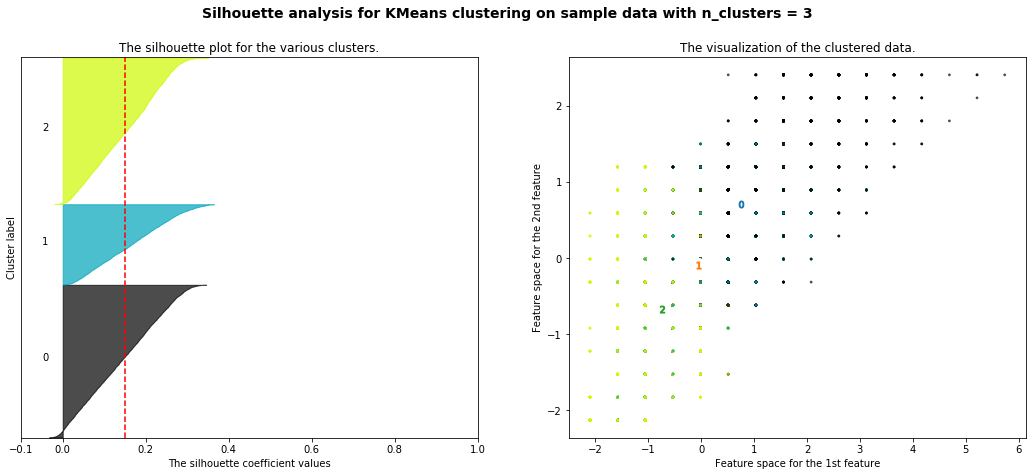

For n_clusters = 4 The average silhouette_score is : 0.123959489606


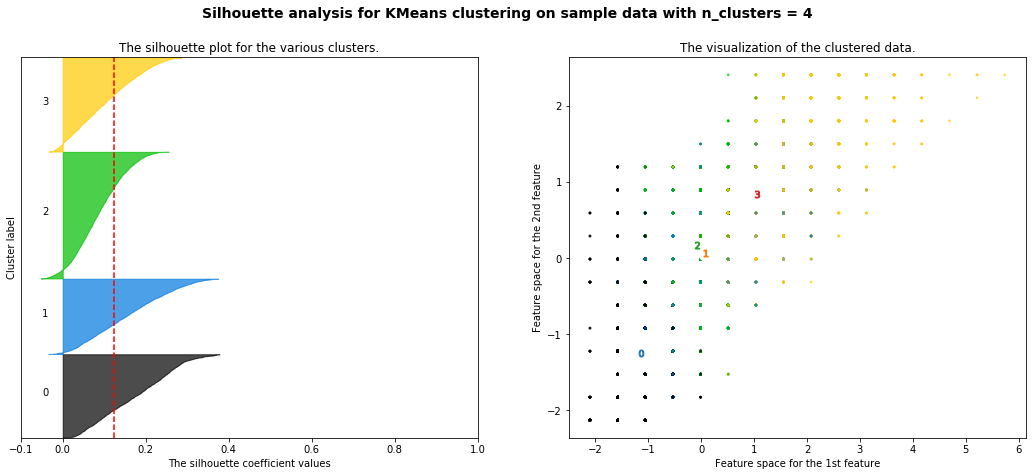

For n_clusters = 5 The average silhouette_score is : 0.131737005936


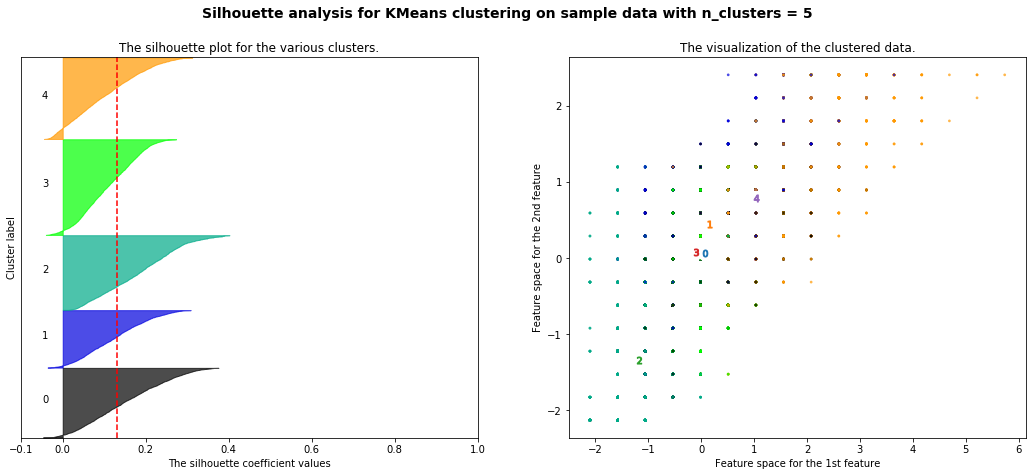

For n_clusters = 6 The average silhouette_score is : 0.137019270571


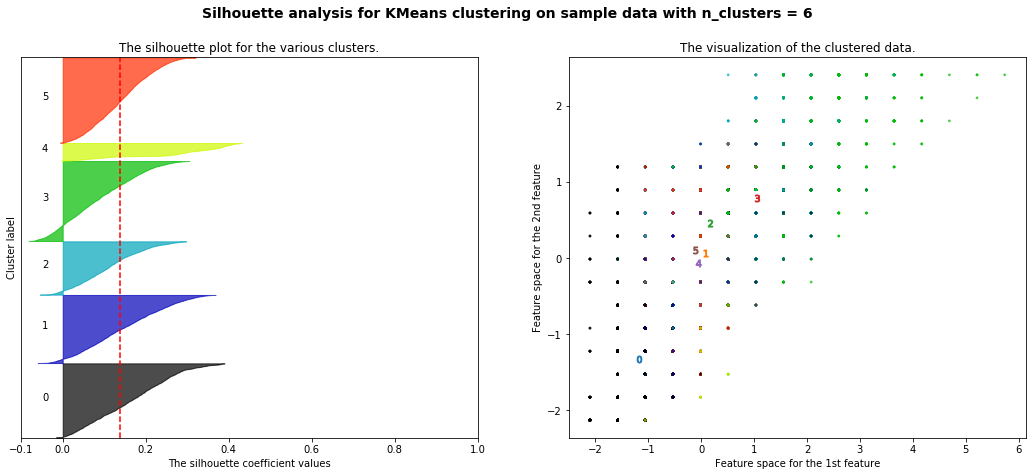

In [177]:
# silhouette analysis
print_silhouette_analysis(X_train_letter.values)

For n_clusters = 2 The average silhouette_score is : 0.159099287531


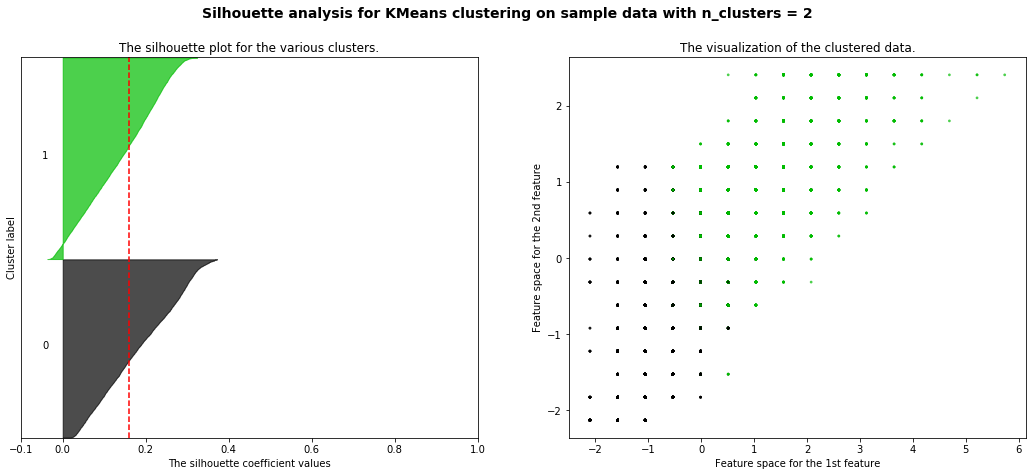

For n_clusters = 3 The average silhouette_score is : 0.159108002561


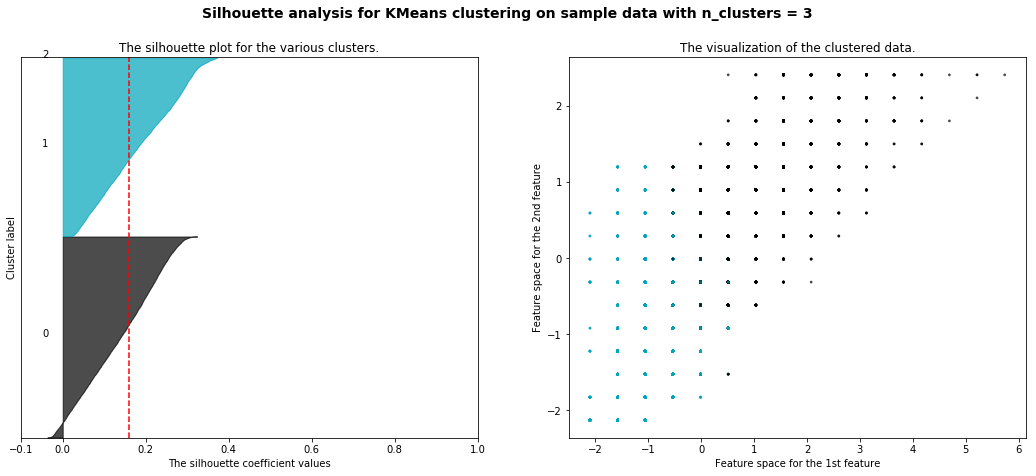

For n_clusters = 4 The average silhouette_score is : 0.159124151443


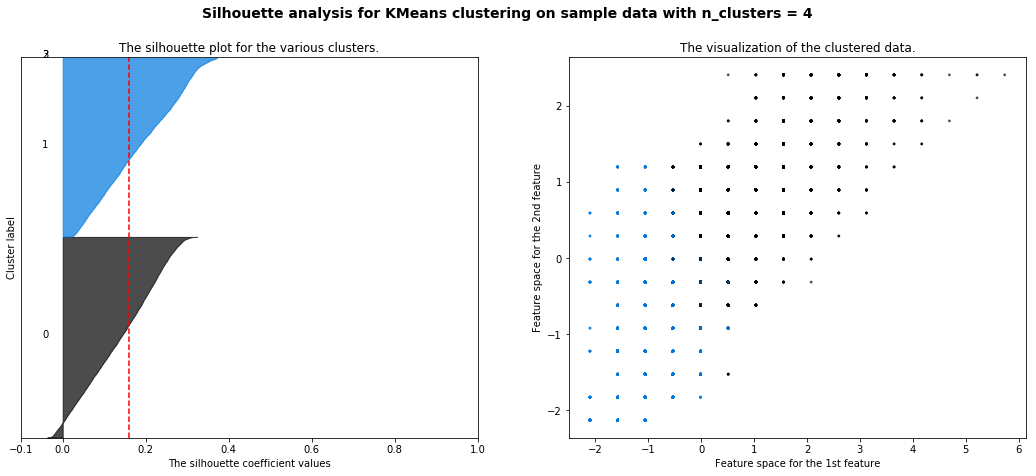

For n_clusters = 5 The average silhouette_score is : 0.159096966617


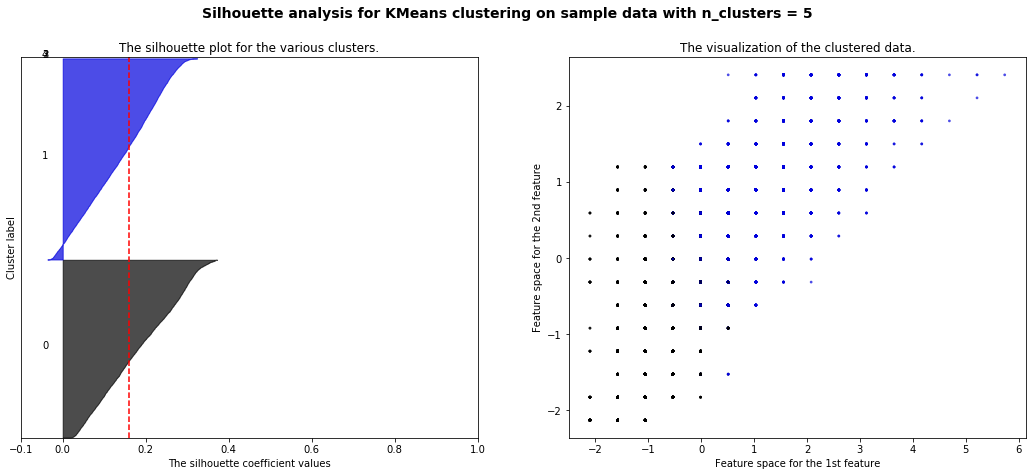

For n_clusters = 6 The average silhouette_score is : 0.159096836295


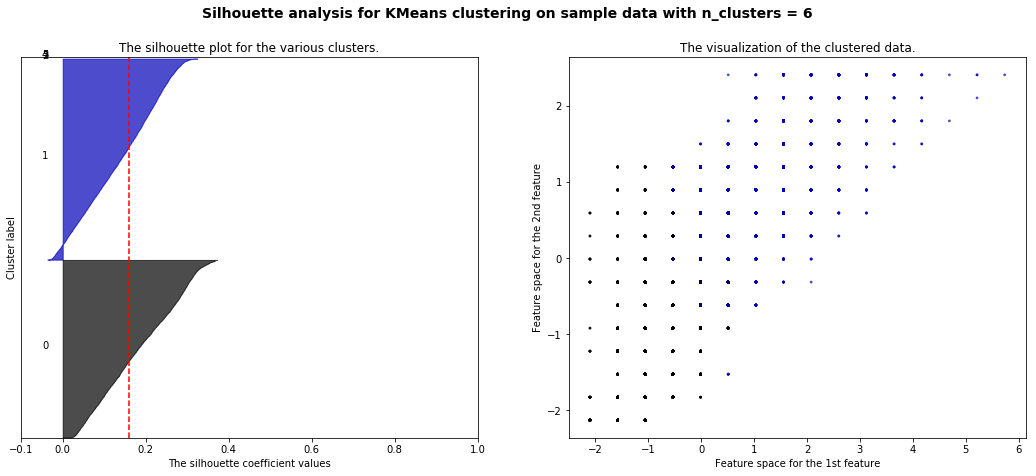

In [300]:
print_silhouette_analysis(X_train_letter.values, clustering='em')

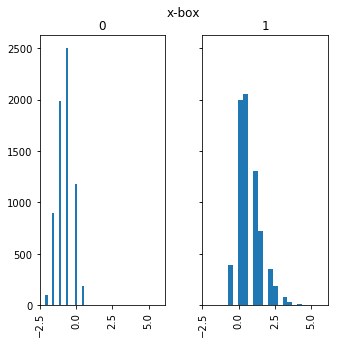

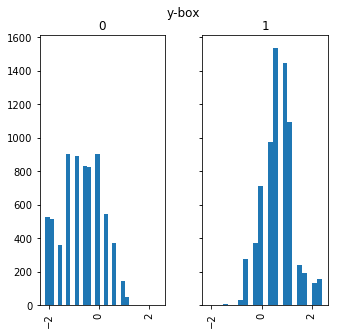

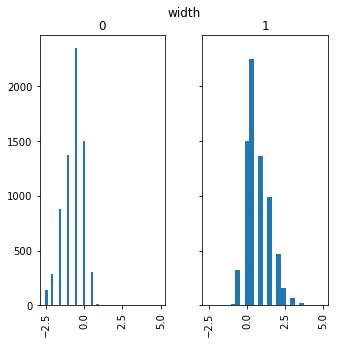

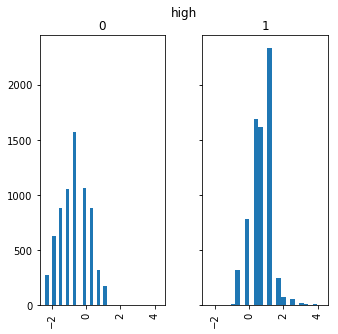

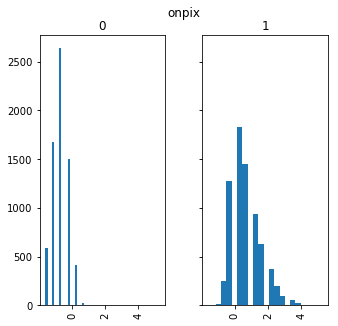

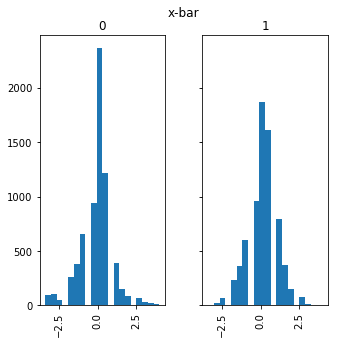

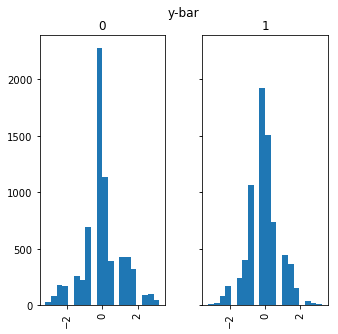

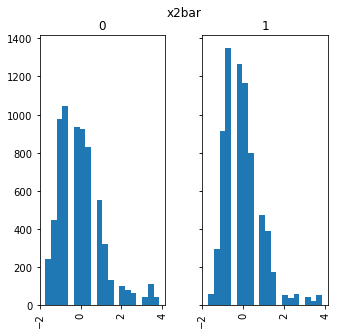

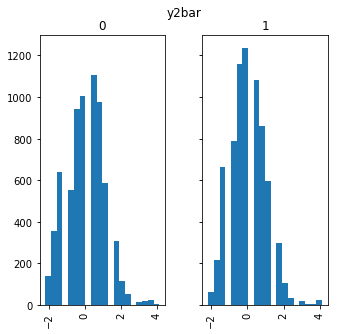

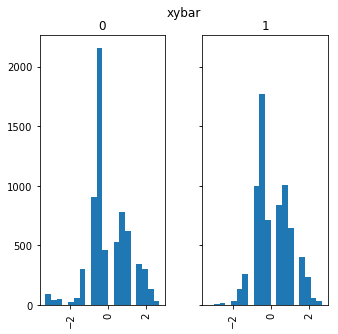

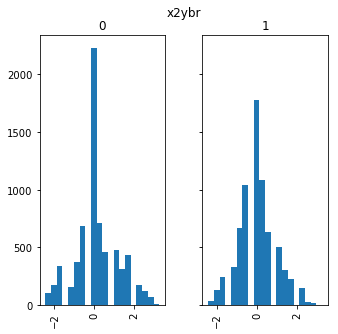

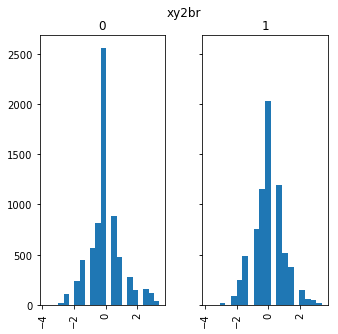

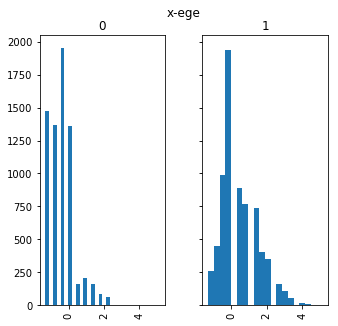

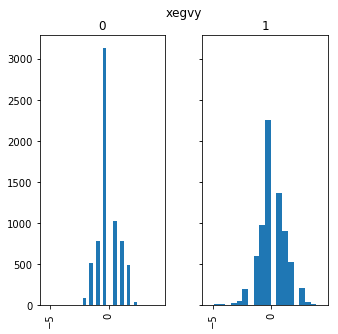

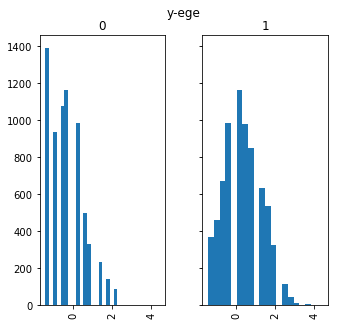

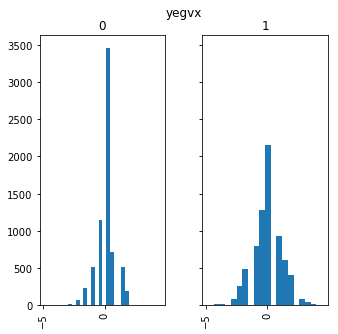

In [178]:
# visualize the distribution of data by using the best k value
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_letter)
labels = kmeans.labels_

for feature in X_train_letter.columns:
    ax = X_train_letter[feature].hist(figsize=(5,5), bins=20, by=labels, sharex=True, sharey=True)
    pl.suptitle(feature)
    
plt.show()

#### EM

In [187]:
bic_scores = []
for i in range(2,28,4):
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='spherical')
    gmm.fit(X_train_letter)
    labels = gmm.predict(X_train_letter)
    spherical = gmm.bic(X_train_letter)
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied')
    gmm.fit(X_train_letter)
    labels = gmm.predict(X_train_letter)
    tied = gmm.bic(X_train_letter)
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='diag')
    gmm.fit(X_train_letter)
    labels = gmm.predict(X_train_letter)
    diag = gmm.bic(X_train_letter)
    
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='full')
    gmm.fit(X_train_letter)
    labels = gmm.predict(X_train_letter)
    full = gmm.bic(X_train_letter)
    
    bic_scores.append((spherical, tied, diag, full))

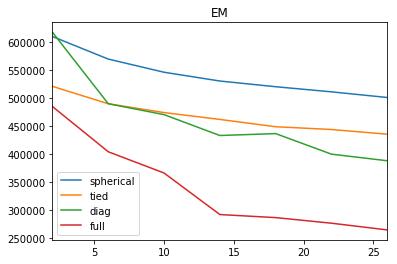

In [188]:
scores_df = pd.DataFrame(bic_scores)
scores_df = scores_df
scores_df.columns = ['spherical', 'tied', 'diag', 'full']
scores_df.index = range(2,28,4)
scores_df.plot(title='EM')
plt.show()

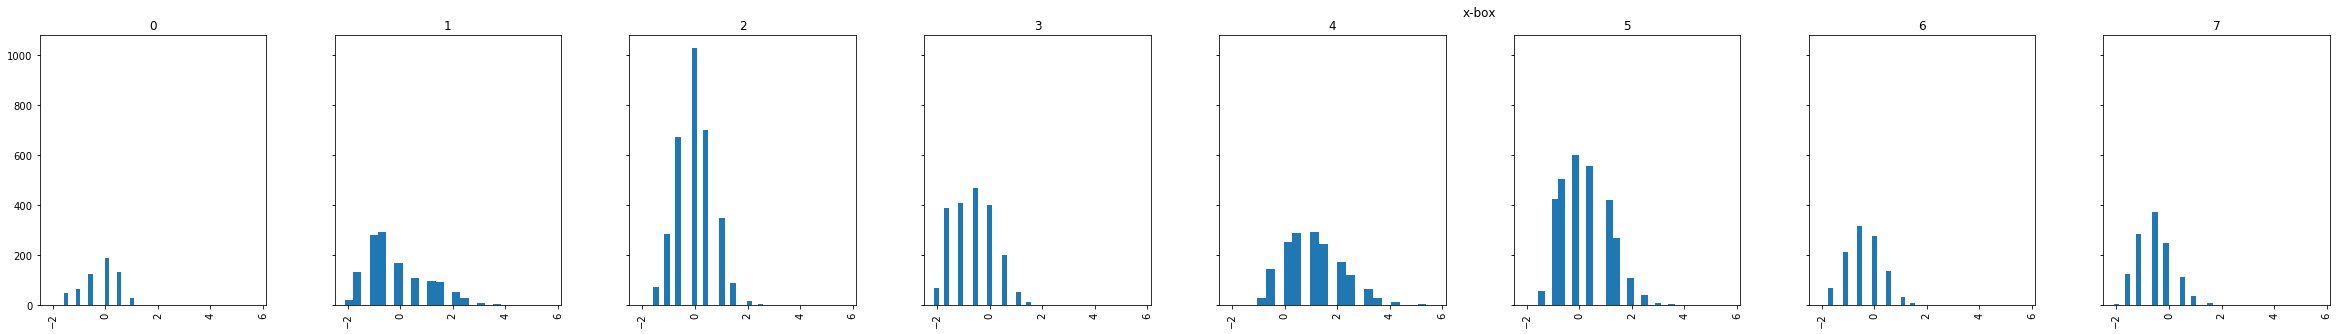

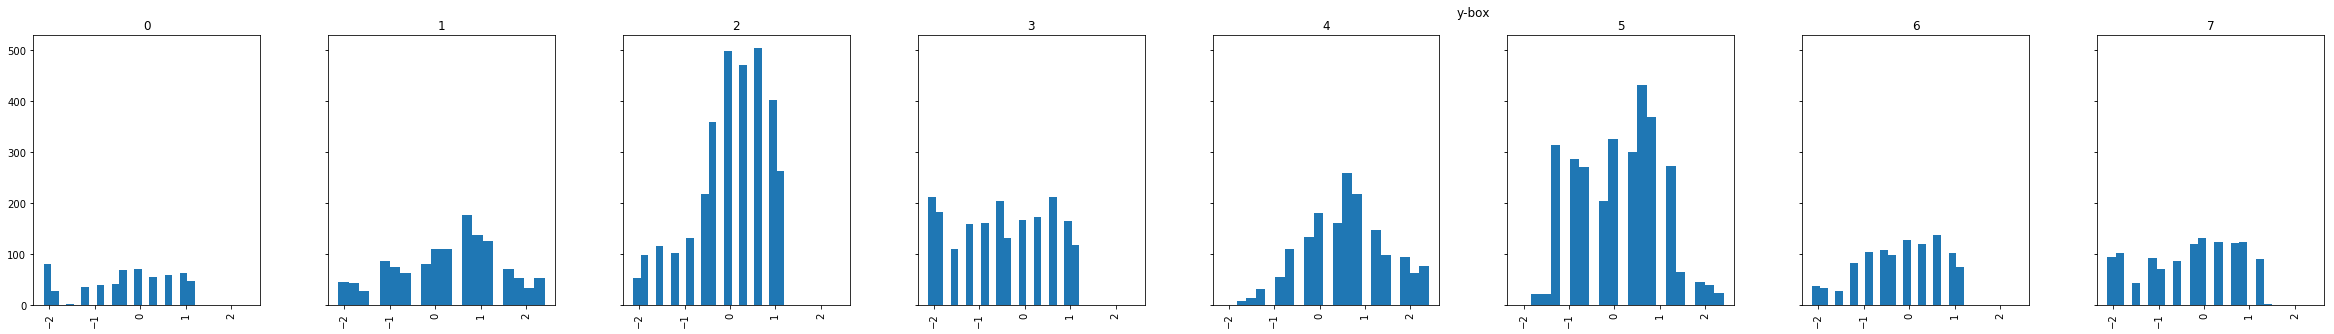

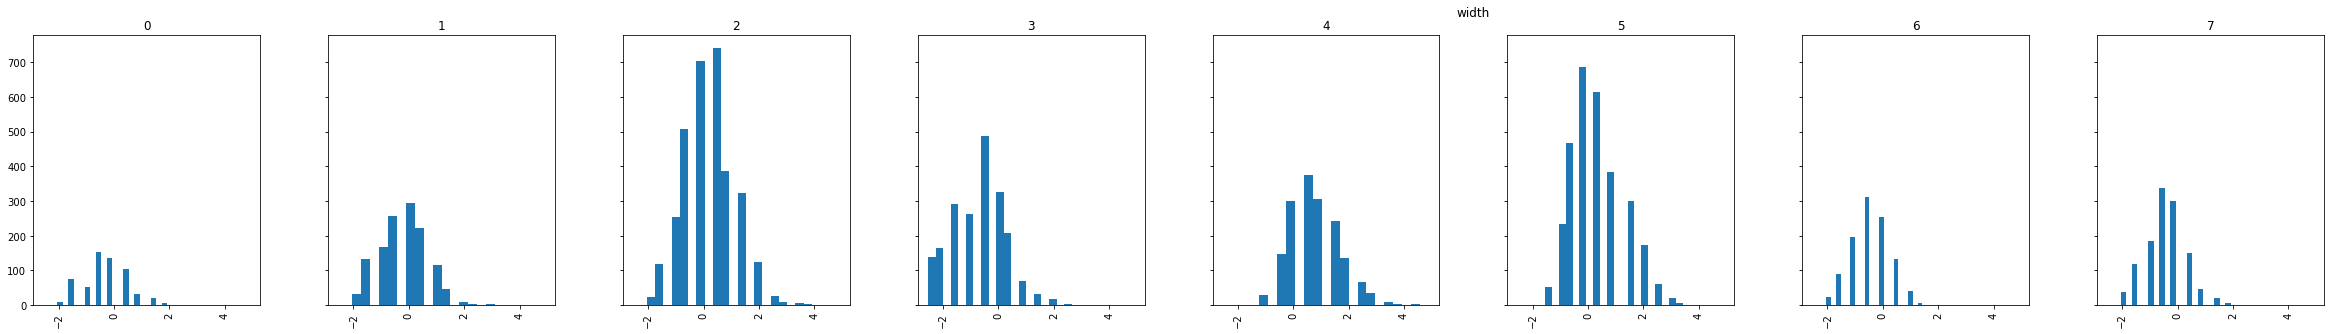

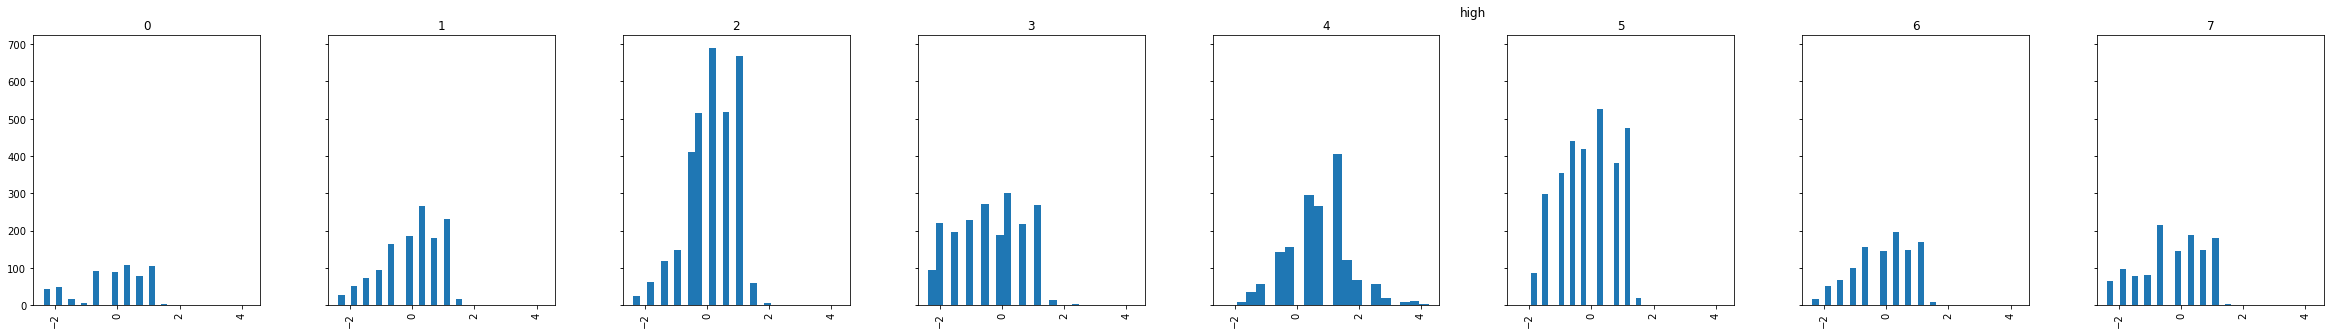

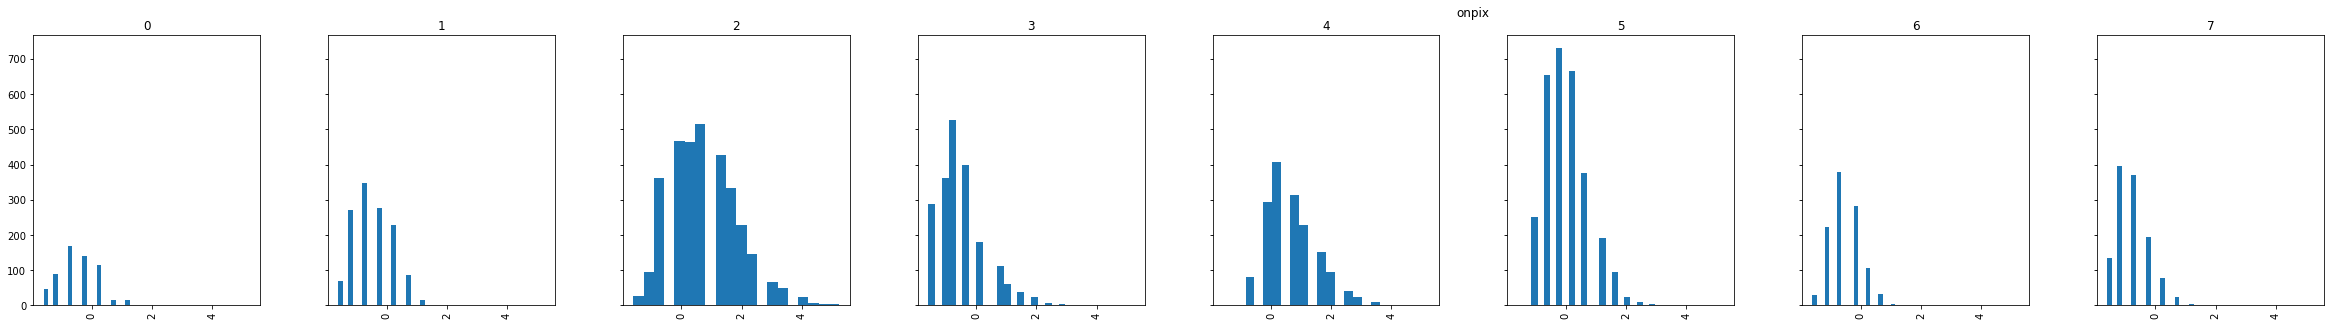

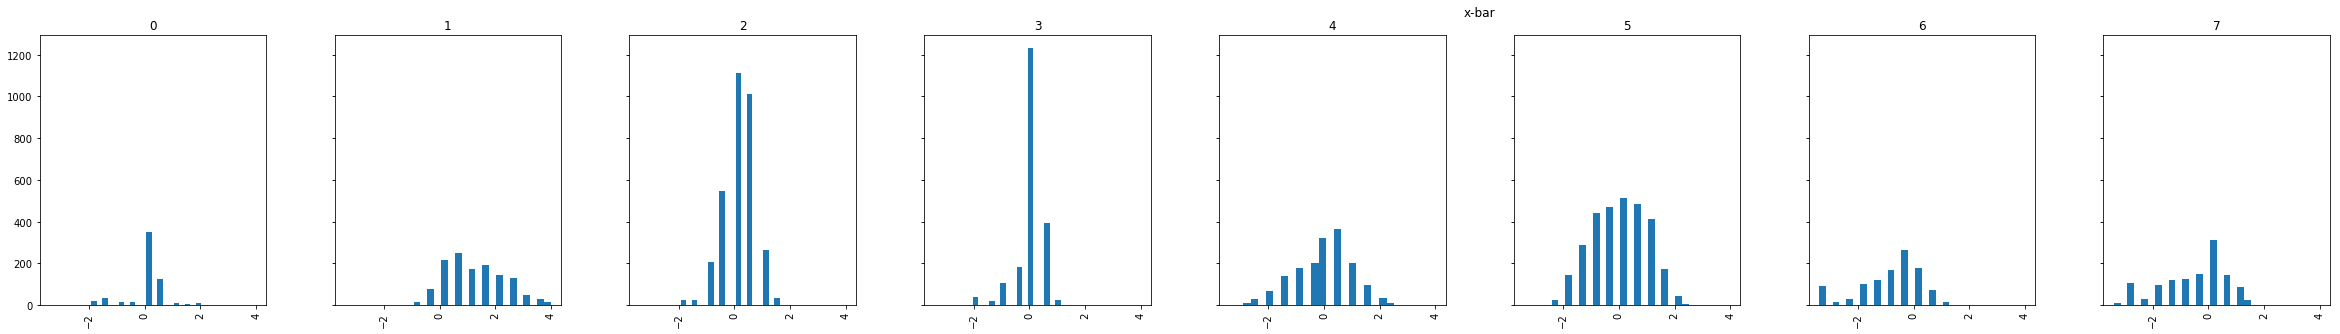

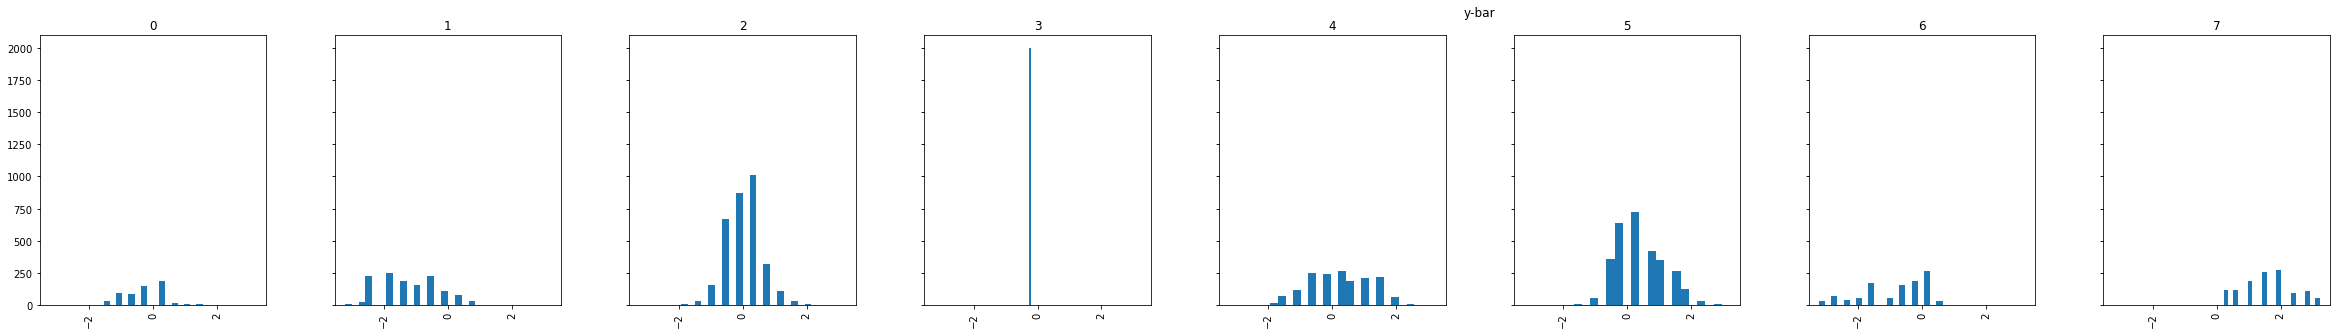

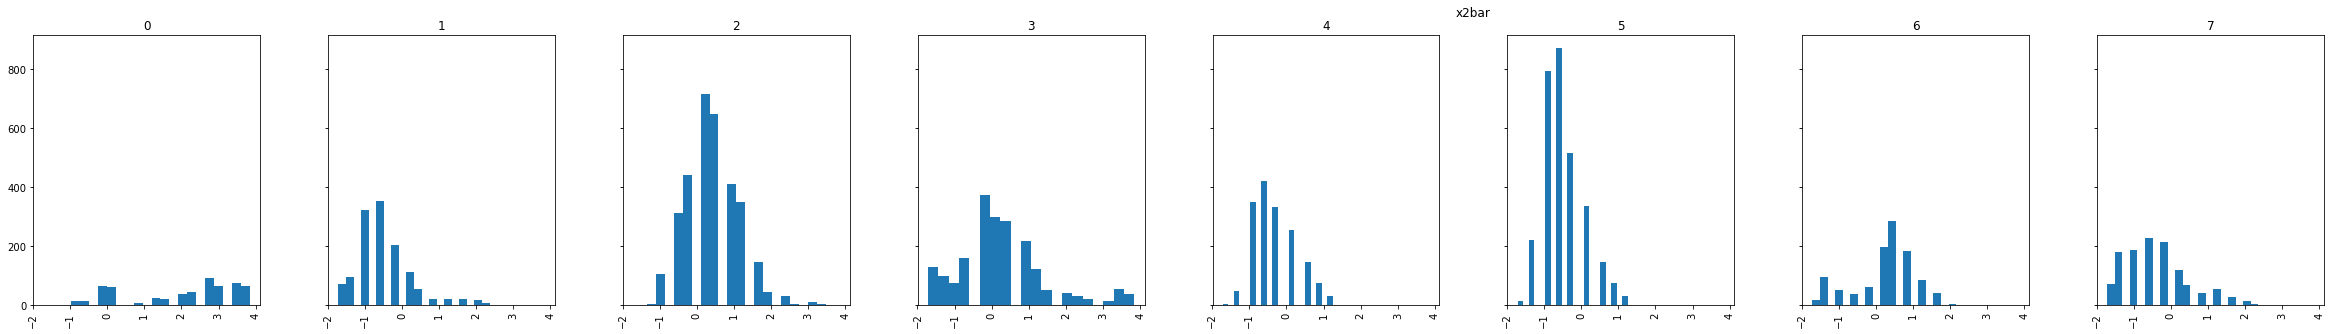

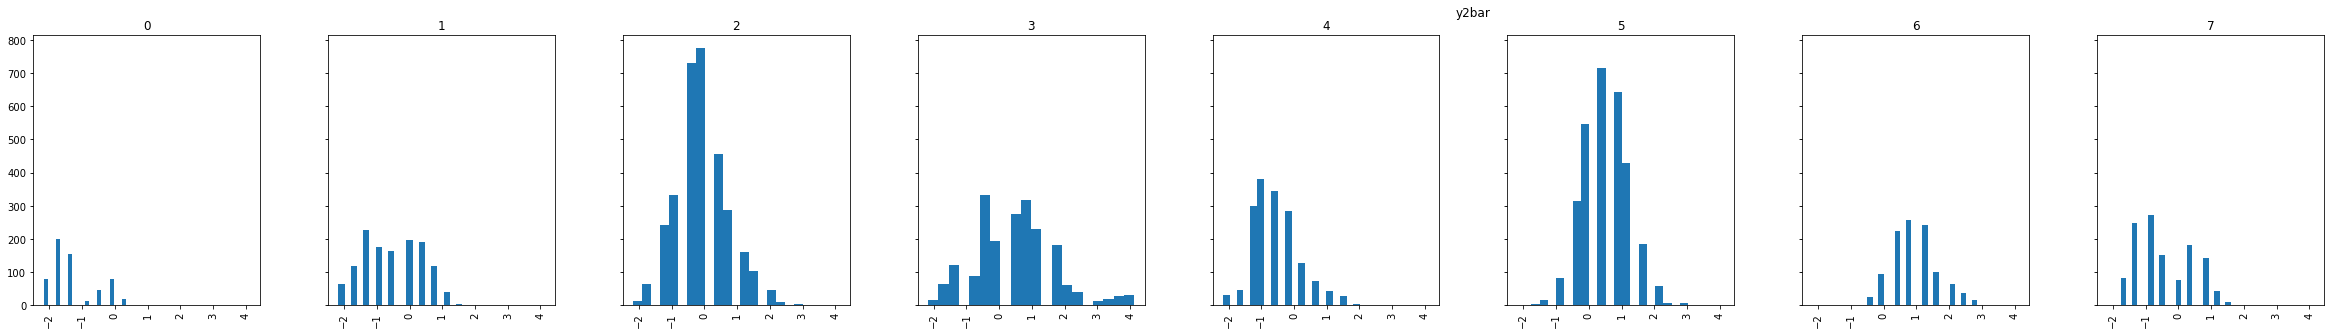

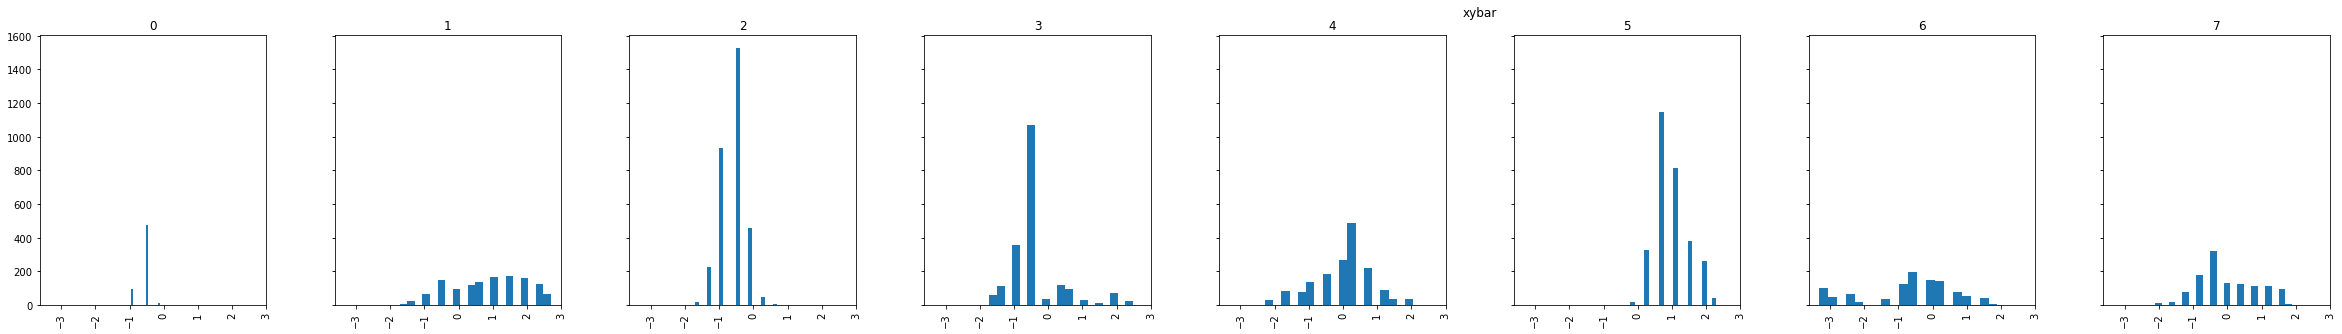

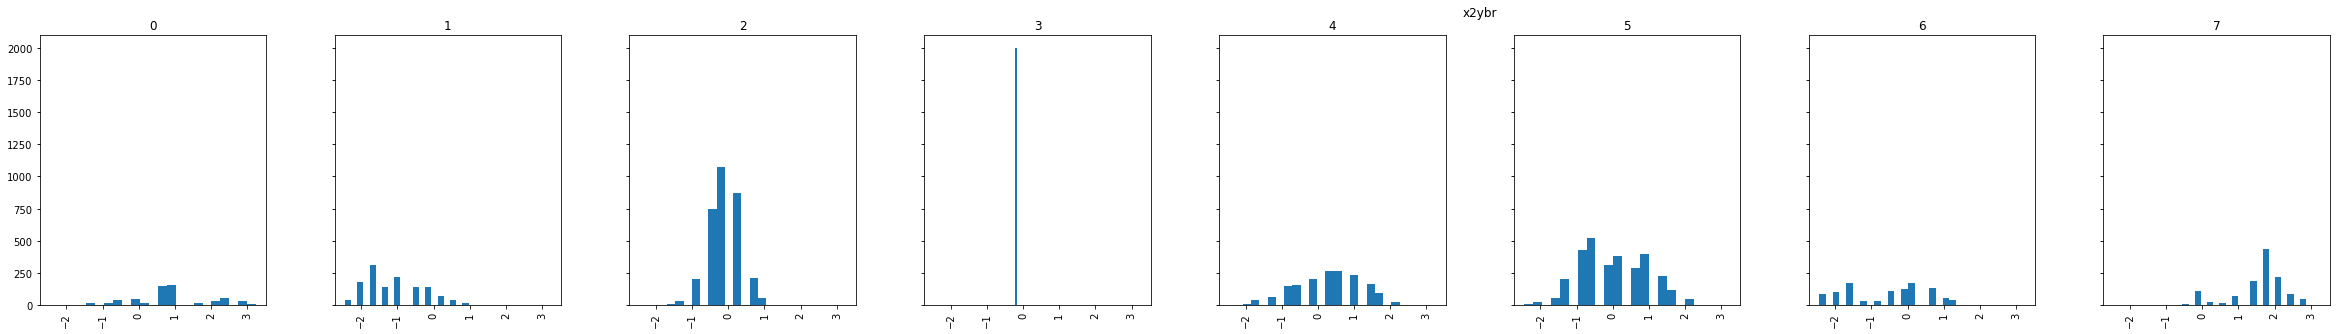

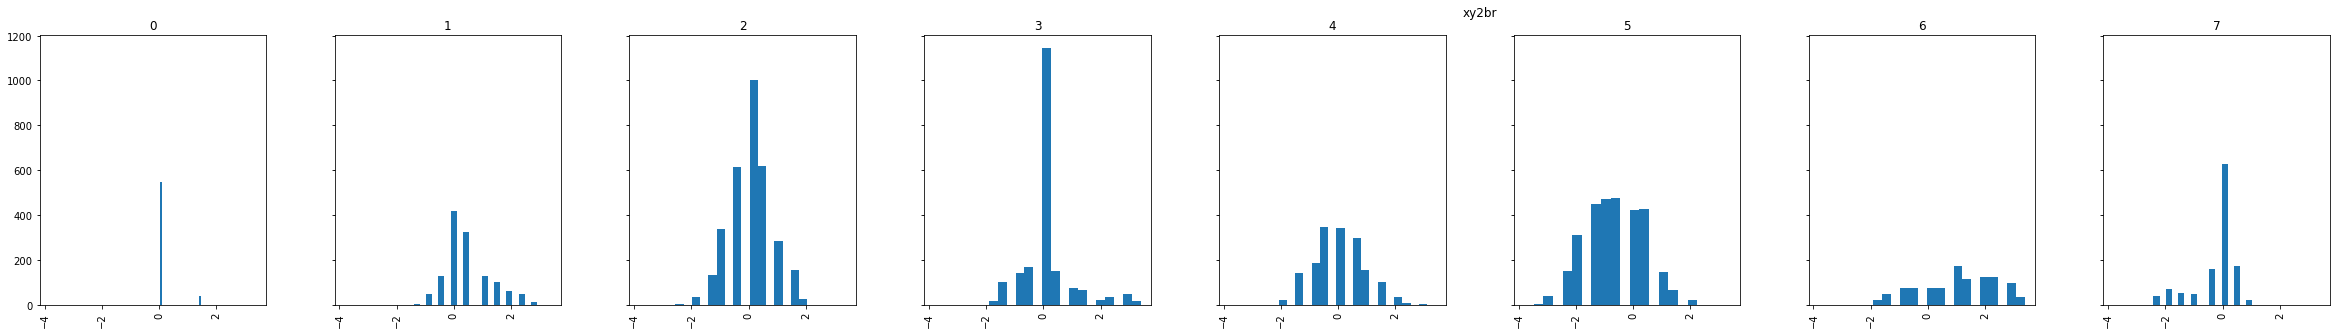

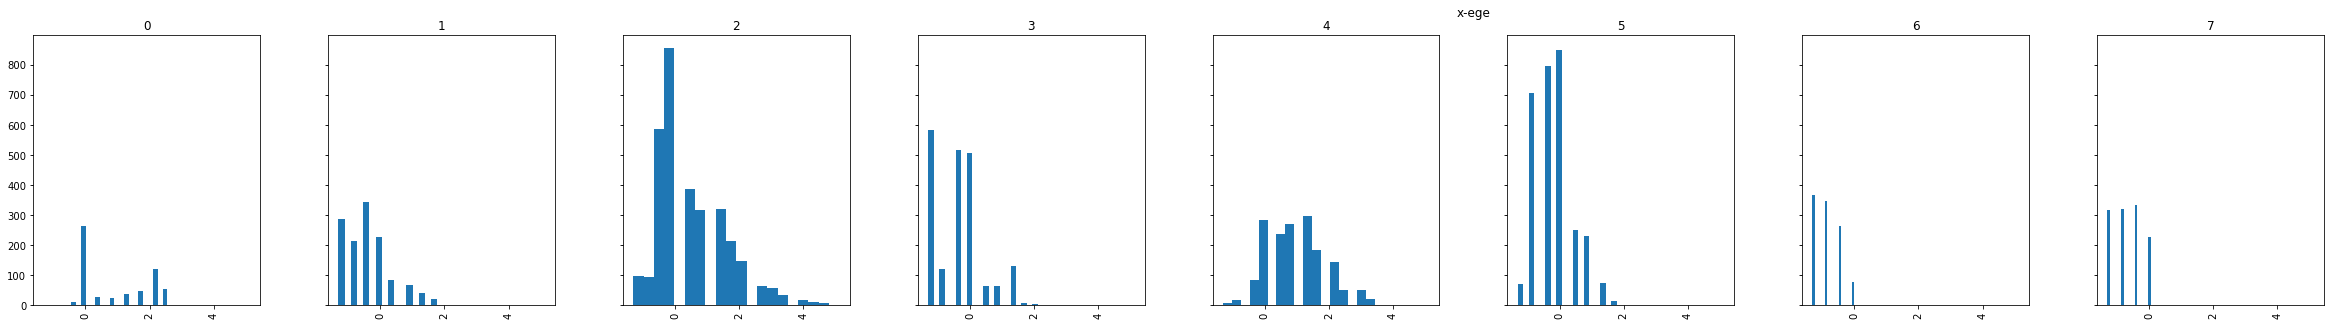

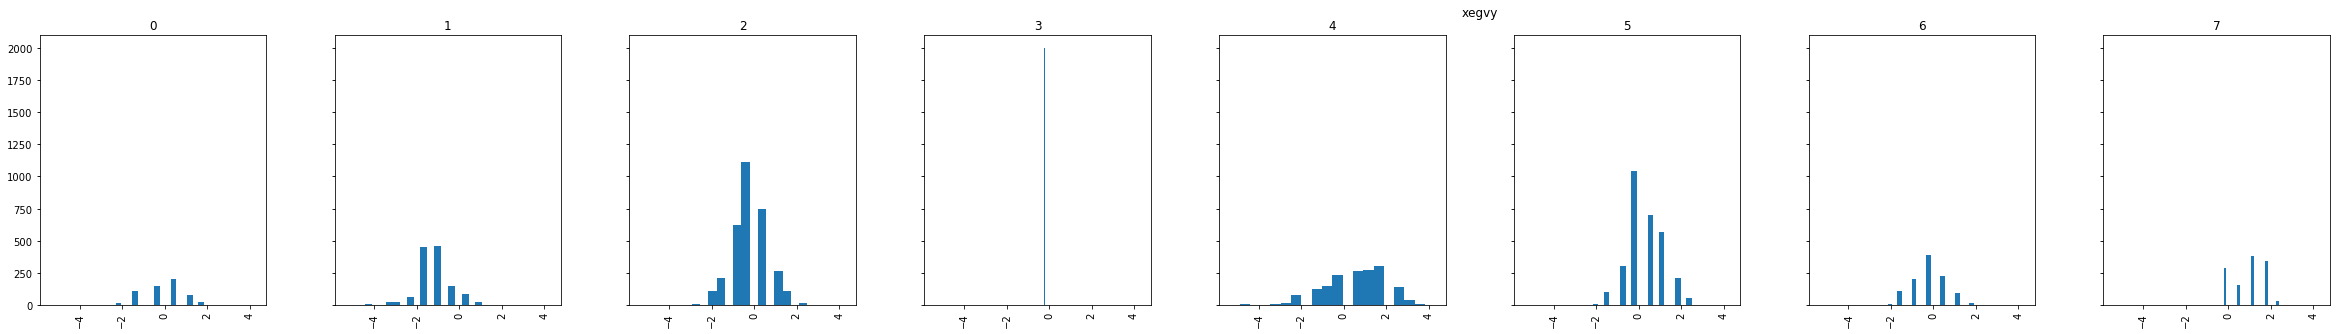

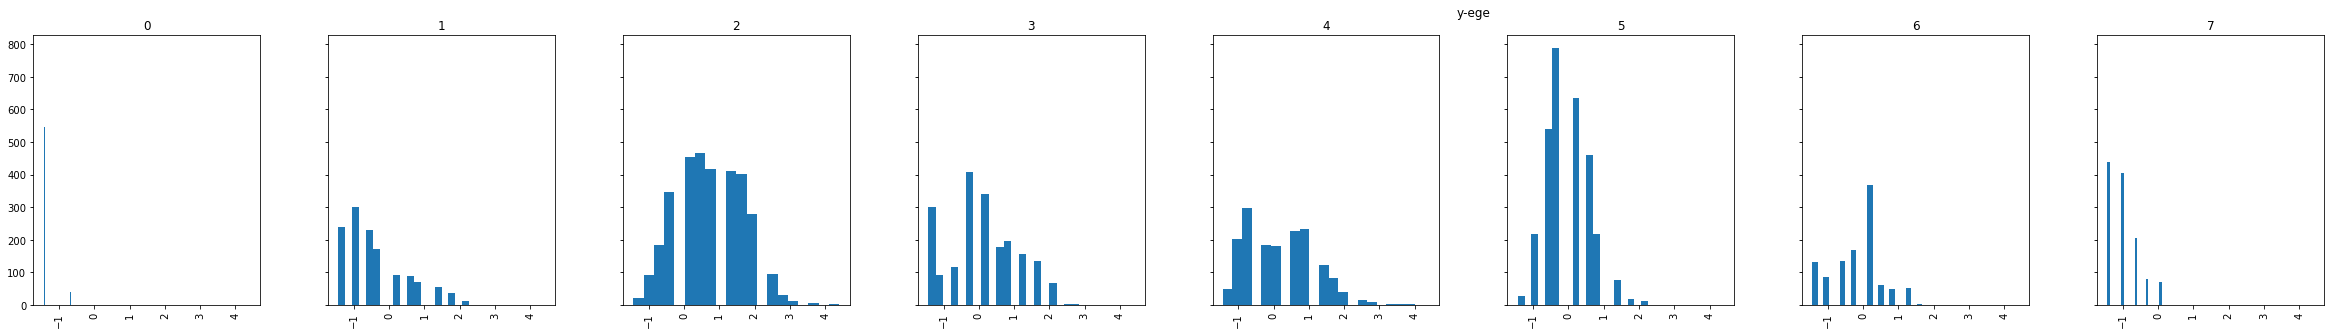

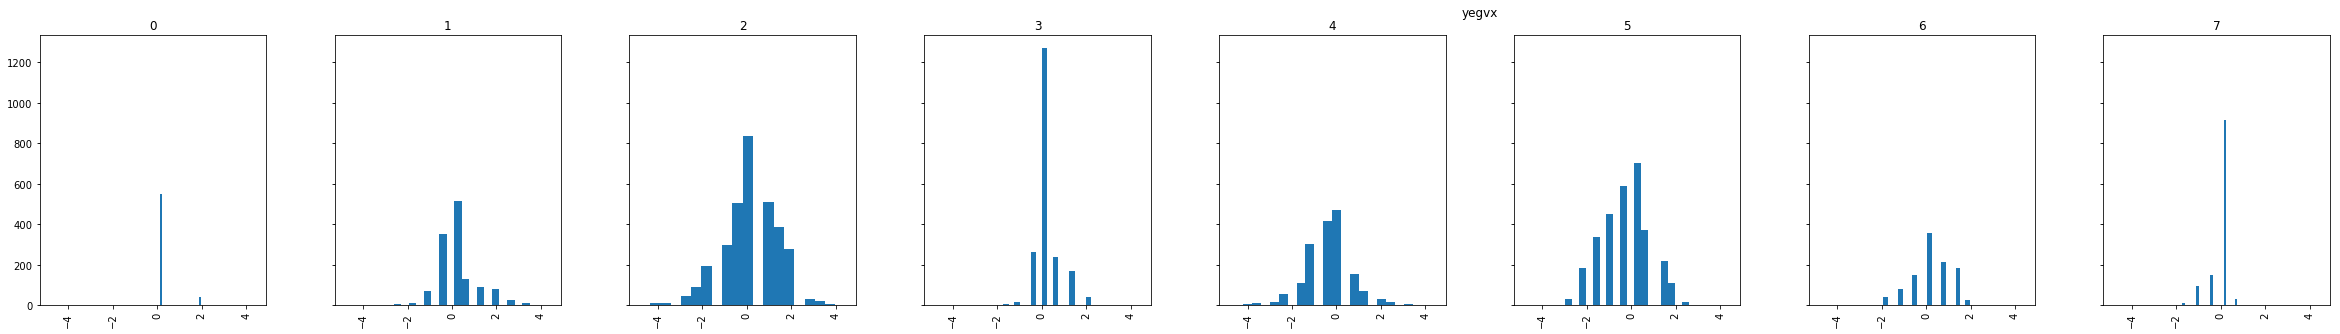

In [184]:
# visualize the distribution of data by using the best k value
gmm = mixture.GaussianMixture(n_components=8, covariance_type='full')
gmm.fit(X_train_letter)
labels = gmm.predict(X_train_letter)

for feature in X_train_letter.columns:
    ax = X_train_letter[feature].hist(figsize=(50,5), bins=20, by=labels, sharex=True, sharey=True, layout=(1,10))
    pl.suptitle(feature)
    
plt.show()

## Dimensionality reduction analysis

### Human Resources

#### PCA

using a wrapping method to determine what is the best number of components to reduce to

In [238]:
pca_accuracy = []
for i in range(1, len(X_train_hr.columns), 3):
    pca = PCA(n_components=i)
    x_train_transformed = pca.fit_transform(X_train_hr)
    x_test_transformed = pca.fit_transform(X_test_hr)

    tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
    ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
    ann_clf.fit(x_train_transformed, y_train_hr)
    pca_accuracy.append(ann_clf.score(x_test_transformed, y_test_hr))


#### ICA

In [239]:
ica_accuracy = []
for i in range(1, len(X_train_hr.columns), 3):
    ica = FastICA(n_components=i)
    x_train_transformed = ica.fit_transform(X_train_hr)
    x_test_transformed = ica.fit_transform(X_test_hr)

    tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
    ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
    ann_clf.fit(x_train_transformed, y_train_hr)
    ica_accuracy.append(ann_clf.score(x_test_transformed, y_test_hr))

#### RCA

In [236]:
rca_accuracy = []
for i in range(1, len(X_train_hr.columns), 3):
    rca = random_projection.GaussianRandomProjection(n_components=i)
    x_train_transformed = rca.fit_transform(X_train_hr)
    x_test_transformed = rca.fit_transform(X_test_hr)

    tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
    ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
    ann_clf.fit(x_train_transformed, y_train_hr)
    rca_accuracy.append(ann_clf.score(x_test_transformed, y_test_hr))

#### kbest

In [125]:
kbest_accuracy = []
for i in range(1, len(X_train_hr.columns), 3):
    kbest = SelectKBest(mutual_info_classif, k=i)
    x_train_transformed = kbest.fit_transform(X_train_hr, y_train_hr)
    x_test_transformed = kbest.fit_transform(X_test_hr, y_test_hr)

    tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
    ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
    ann_clf.fit(x_train_transformed, y_train_hr)
    kbest_accuracy.append(ann_clf.score(x_test_transformed, y_test_hr))

#### tree based selection

In [240]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
clf = clf.fit(X_train_hr, y_train_hr)
model = SelectFromModel(clf, prefit=True)
x_train_transformed = model.transform(X_train_hr)

clf = clf.fit(X_test_hr, y_test_hr)
model = SelectFromModel(clf, prefit=True)
x_test_transformed = model.transform(X_test_hr)

tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(x_train_transformed, y_train_hr)
tree_accuracy = (ann_clf.score(x_test_transformed, y_test_hr), x_test_transformed.shape[1])

In [196]:
print(tree_accuracy)

(0.95533333333333337, 5)


Analysis of the dimensionality reduction algorithms when applied to the ANN

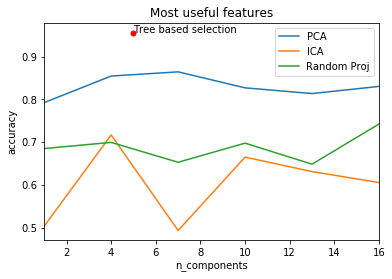

In [244]:
accuracy_scores = [pca_accuracy, ica_accuracy, rca_accuracy]
dim_red_accuracies = pd.DataFrame(accuracy_scores)
dim_red_accuracies = dim_red_accuracies.T
dim_red_accuracies.columns = ['PCA', 'ICA', 'Random Proj']
dim_red_accuracies.index = range(1, len(X_train_hr.columns), 3)
ax = dim_red_accuracies.plot(title='Most useful features')
plt.plot(tree_accuracy[1], tree_accuracy[0], marker='o', markersize=5, color="red")
ax.annotate('Tree based selection', xy=(tree_accuracy[1], tree_accuracy[0]))
ax.set_xlabel('n_components')
ax.set_ylabel('accuracy')
plt.show()

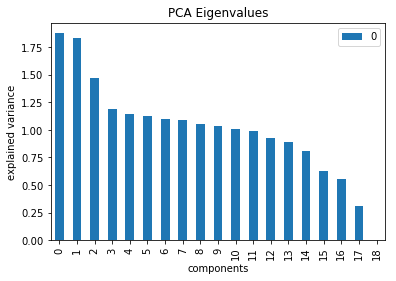

In [246]:
pca = PCA()
pca.fit(X_train_hr)
ax = pd.DataFrame(pca.explained_variance_).plot(kind='bar', title='PCA Eigenvalues')
ax.set_xlabel('components')
ax.set_ylabel('explained variance')
plt.show()

In [248]:
ica = FastICA(n_components=i)
ica.fit(X_train_hr)
mixing = ica.mixing_ 
mixing.shape

(19, 16)

#### Comparison to project 1

In [260]:
start_time = time.time()
tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(X_train_hr, y_train_hr)
raw_accuracy = ann_clf.score(X_test_hr, y_test_hr)
raw_time = time.time() - start_time

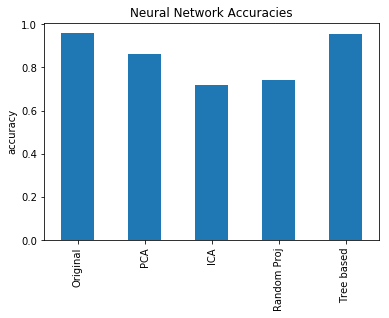

In [257]:
accuracies = pd.DataFrame([raw_accuracy, max(pca_accuracy), max(ica_accuracy), max(rca_accuracy), tree_accuracy[0]], index=['Original', 'PCA', 'ICA', 'Random Proj', 'Tree based'])
ax = accuracies.plot(kind='bar', title='Neural Network Accuracies', legend=False)
ax.set_ylabel('accuracy')
plt.show()

In [262]:
start_time = time.time()
pca = PCA(n_components=7)
x_train_transformed = pca.fit_transform(X_train_hr)
x_test_transformed = pca.fit_transform(X_test_hr)

tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(x_train_transformed, y_train_hr)
ann_clf.score(x_test_transformed, y_test_hr)
pca_time = time.time() - start_time

In [263]:
start_time = time.time()
ica = FastICA(n_components=4)
x_train_transformed = ica.fit_transform(X_train_hr)
x_test_transformed = ica.fit_transform(X_test_hr)

tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(x_train_transformed, y_train_hr)
ann_clf.score(x_test_transformed, y_test_hr)
ica_time = time.time() - start_time

In [264]:
start_time = time.time()
rca = random_projection.GaussianRandomProjection(n_components=16)
x_train_transformed = rca.fit_transform(X_train_hr)
x_test_transformed = rca.fit_transform(X_test_hr)

tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(x_train_transformed, y_train_hr)
ann_clf.score(x_test_transformed, y_test_hr)
rca_time = time.time() - start_time

In [265]:
start_time = time.time()
clf = ExtraTreesClassifier()
clf = clf.fit(X_train_hr, y_train_hr)
model = SelectFromModel(clf, prefit=True)
x_train_transformed = model.transform(X_train_hr)

clf = clf.fit(X_test_hr, y_test_hr)
model = SelectFromModel(clf, prefit=True)
x_test_transformed = model.transform(X_test_hr)

tuned_parameters = [{'hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (6, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]}]
ann_clf = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), tuned_parameters, cv=10)
ann_clf.fit(x_train_transformed, y_train_hr)
tree_accuracy = (ann_clf.score(x_test_transformed, y_test_hr), x_test_transformed.shape[1])
tree_time = time.time() - start_time

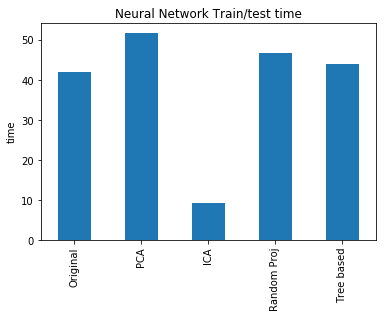

In [267]:
times = pd.DataFrame([raw_time, pca_time, ica_time, rca_time, tree_time], index=['Original', 'PCA', 'ICA', 'Random Proj', 'Tree based'])
ax = times.plot(kind='bar', title='Neural Network Train/test time', legend=False)
ax.set_ylabel('time')
plt.show()

### Letter Recognition

#### PCA

In [211]:
ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(X_train_letter, y_train_letter)
ann_clf.score(X_test_letter, y_test_letter)

0.9351666666666667

In [279]:
pca_accuracy = []
for i in range(1, len(X_train_letter.columns), 3):
    pca = PCA(n_components=i)
    x_train_transformed = pca.fit_transform(X_train_letter)
    x_test_transformed = pca.fit_transform(X_test_letter)

    ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
    ann_clf.fit(x_train_transformed, y_train_letter)
    pca_accuracy.append(ann_clf.score(x_test_transformed, y_test_letter))


In [280]:
print(pca_accuracy)

[0.00033333333333333332, 0.43416666666666665, 0.78400000000000003, 0.84883333333333333, 0.70350000000000001]


#### ICA

In [312]:
ica_accuracy = []
for i in range(1, len(X_train_letter.columns), 3):
    ica = FastICA(n_components=i)
    x_train_transformed = ica.fit_transform(X_train_letter)
    x_test_transformed = ica.fit_transform(X_test_letter)

    ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
    ann_clf.fit(x_train_transformed, y_train_letter)
    ica_accuracy.append(ann_clf.score(x_test_transformed, y_test_letter))

#### RCA

In [272]:
rca_accuracy = []
for i in range(1, len(X_train_letter.columns), 3):
    rca = random_projection.GaussianRandomProjection(n_components=i)
    x_train_transformed = rca.fit_transform(X_train_letter)
    x_test_transformed = rca.fit_transform(X_test_letter)

    ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
    ann_clf.fit(x_train_transformed, y_train_letter)
    rca_accuracy.append(ann_clf.score(x_test_transformed, y_test_letter))

In [277]:
print(rca_accuracy)

[0.0, 0.017166666666666667, 0.017333333333333333, 0.017000000000000001, 0.014666666666666666]


#### tree based feature selection

In [273]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
clf = clf.fit(X_train_letter, y_train_letter)
model = SelectFromModel(clf, prefit=True)
x_train_transformed = model.transform(X_train_letter)

clf = clf.fit(X_test_letter, y_test_letter)
model = SelectFromModel(clf, prefit=True)
x_test_transformed = model.transform(X_test_letter)

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(x_train_transformed, y_train_letter)
tree_accuracy = (ann_clf.score(x_test_transformed, y_test_letter), x_test_transformed.shape[1])

Analysis of the dimensionality reduction algorithms when applied to the ANN

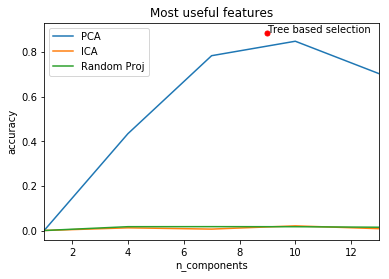

In [281]:
accuracy_scores = [pca_accuracy, ica_accuracy, rca_accuracy]
dim_red_accuracies = pd.DataFrame(accuracy_scores)
dim_red_accuracies = dim_red_accuracies.T
dim_red_accuracies.columns = ['PCA', 'ICA', 'Random Proj']
dim_red_accuracies.index = range(1, len(X_train_letter.columns), 3)
ax = dim_red_accuracies.plot(title='Most useful features')
plt.plot(tree_accuracy[1], tree_accuracy[0], marker='o', markersize=5, color="red")
ax.annotate('Tree based selection', xy=(tree_accuracy[1], tree_accuracy[0]))
ax.set_xlabel('n_components')
ax.set_ylabel('accuracy')
plt.show()

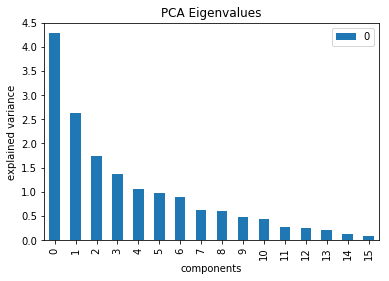

In [313]:
pca = PCA()
pca.fit(X_train_letter)
ax = pd.DataFrame(pca.explained_variance_).plot(kind='bar', title='PCA Eigenvalues')
ax.set_xlabel('components')
ax.set_ylabel('explained variance')
plt.show()

#### Comparison to project 1

In [275]:
start_time = time.time()
ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(X_train_letter, y_train_letter)
raw_accuracy = ann_clf.score(X_test_letter, y_test_letter)
raw_time = time.time() - start_time

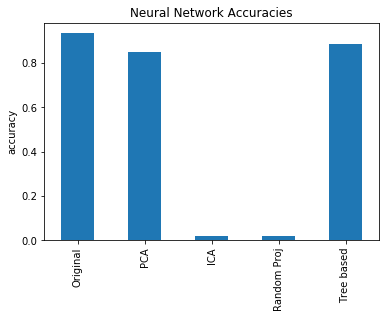

In [282]:
accuracies = pd.DataFrame([raw_accuracy, max(pca_accuracy), max(ica_accuracy), max(rca_accuracy), tree_accuracy[0]], index=['Original', 'PCA', 'ICA', 'Random Proj', 'Tree based'])
ax = accuracies.plot(kind='bar', title='Neural Network Accuracies', legend=False)
ax.set_ylabel('accuracy')
plt.show()

In [314]:
start_time = time.time()
pca = PCA(n_components=10)
x_train_transformed = pca.fit_transform(X_train_letter)
x_test_transformed = pca.fit_transform(X_test_letter)

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(x_train_transformed, y_train_letter)
ann_clf.score(x_test_transformed, y_test_letter)
pca_time = time.time() - start_time

In [315]:
start_time = time.time()
ica = FastICA(n_components=10)
x_train_transformed = ica.fit_transform(X_train_letter)
x_test_transformed = ica.fit_transform(X_test_letter)

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(x_train_transformed, y_train_letter)
ann_clf.score(x_test_transformed, y_test_letter)
ica_time = time.time() - start_time

In [316]:
start_time = time.time()
rca = random_projection.GaussianRandomProjection(n_components=10)
x_train_transformed = rca.fit_transform(X_train_letter)
x_test_transformed = rca.fit_transform(X_test_letter)

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(x_train_transformed, y_train_letter)
ann_clf.score(x_test_transformed, y_test_letter)
rca_time = time.time() - start_time

In [317]:
start_time = time.time()
clf = ExtraTreesClassifier()
clf = clf.fit(X_train_letter, y_train_letter)
model = SelectFromModel(clf, prefit=True)
x_train_transformed = model.transform(X_train_letter)

clf = clf.fit(X_test_letter, y_test_letter)
model = SelectFromModel(clf, prefit=True)
x_test_transformed = model.transform(X_test_letter)

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 200), random_state=1)
ann_clf.fit(x_train_transformed, y_train_letter)
tree_accuracy = (ann_clf.score(x_test_transformed, y_test_letter), x_test_transformed.shape[1])
tree_time = time.time() - start_time

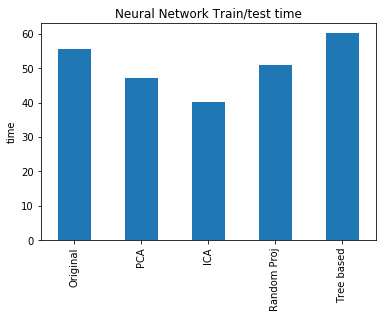

In [318]:
times = pd.DataFrame([raw_time, pca_time, ica_time, rca_time, tree_time], index=['Original', 'PCA', 'ICA', 'Random Proj', 'Tree based'])
ax = times.plot(kind='bar', title='Neural Network Train/test time', legend=False)
ax.set_ylabel('time')
plt.show()

## Clustering after dimensionality reduction

### Human Resources

#### kmeans

In [292]:
pca = PCA(n_components=7)
x_train_transformed_pca = pca.fit_transform(X_train_hr)

pca_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_pca)
    labels = kmeans.labels_
    pca_silhouette_scores.append(silhouette_score(x_train_transformed_pca, labels, metric='euclidean'))

In [293]:
ica = FastICA(n_components=4)
x_train_transformed_ica = ica.fit_transform(X_train_hr)

ica_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_ica)
    labels = kmeans.labels_
    ica_silhouette_scores.append(silhouette_score(x_train_transformed_ica, labels, metric='euclidean'))

In [294]:
rca = random_projection.GaussianRandomProjection(n_components=16)
x_train_transformed_rca = rca.fit_transform(X_train_hr)

rca_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_rca)
    labels = kmeans.labels_
    rca_silhouette_scores.append(silhouette_score(x_train_transformed_rca, labels, metric='euclidean'))

In [295]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train_hr, y_train_hr)
model = SelectFromModel(clf, prefit=True)
x_train_transformed_tree = model.transform(X_train_hr)

tree_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_tree)
    labels = kmeans.labels_
    tree_silhouette_scores.append(silhouette_score(x_train_transformed_tree, labels, metric='euclidean'))

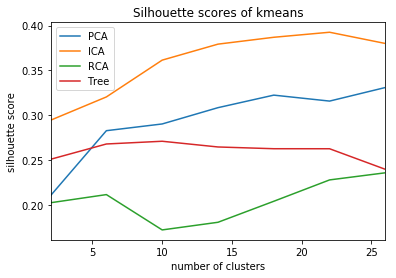

In [299]:
silhouette_df = pd.DataFrame([pca_silhouette_scores, ica_silhouette_scores, rca_silhouette_scores, tree_silhouette_scores])
silhouette_df = silhouette_df.T
silhouette_df.columns= ['PCA', 'ICA', 'RCA', 'Tree']
silhouette_df.index = range(2,28,4)
ax = silhouette_df.plot(title='Silhouette scores of kmeans')
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouette score')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.210469334056


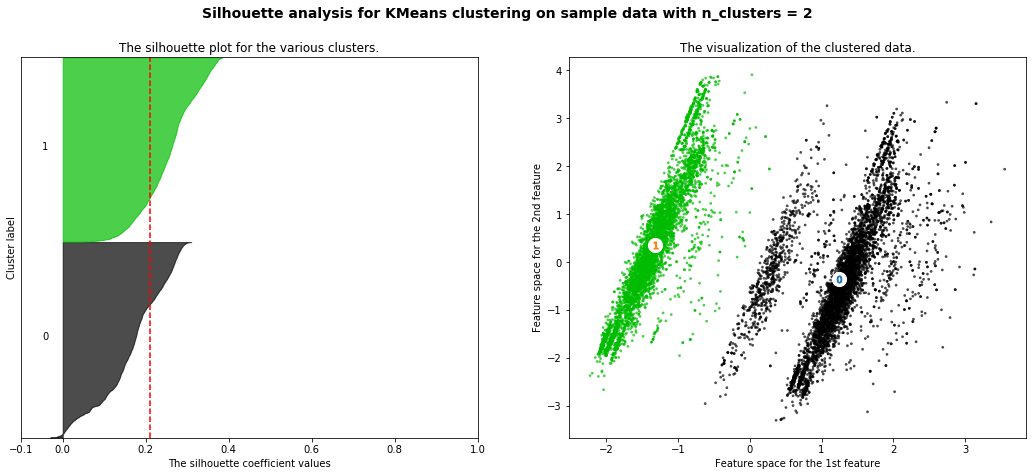

For n_clusters = 3 The average silhouette_score is : 0.250488087317


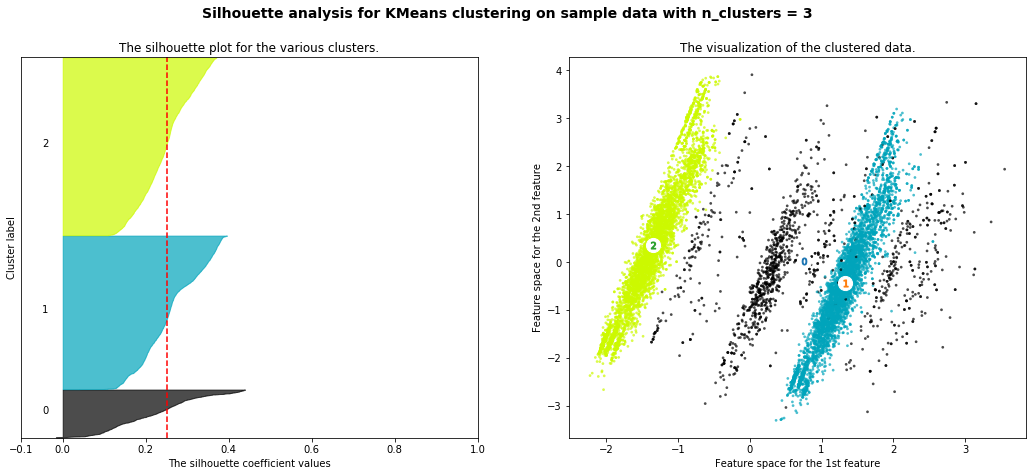

For n_clusters = 4 The average silhouette_score is : 0.278536231166


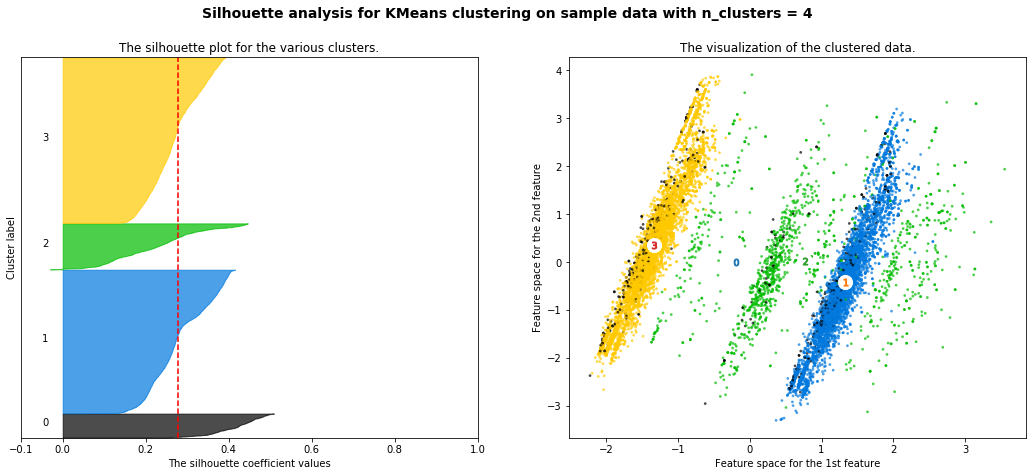

For n_clusters = 5 The average silhouette_score is : 0.282770905068


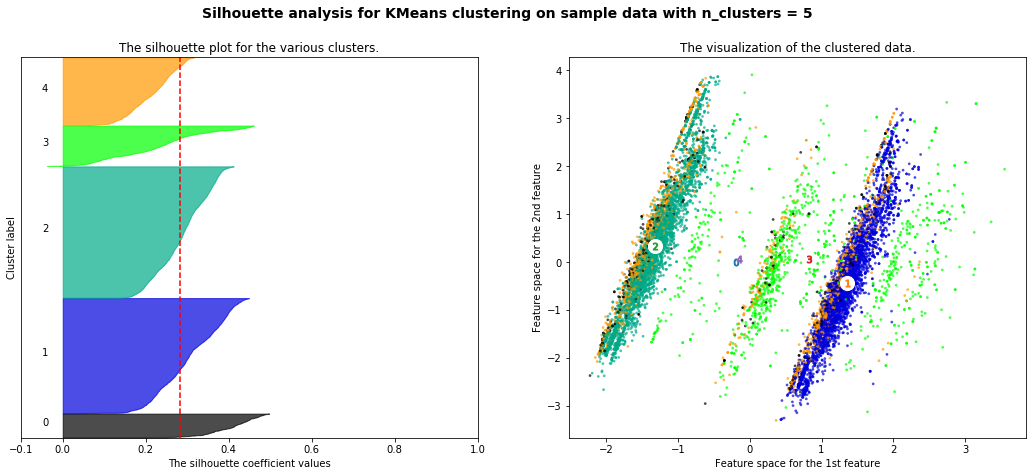

For n_clusters = 6 The average silhouette_score is : 0.282615565228


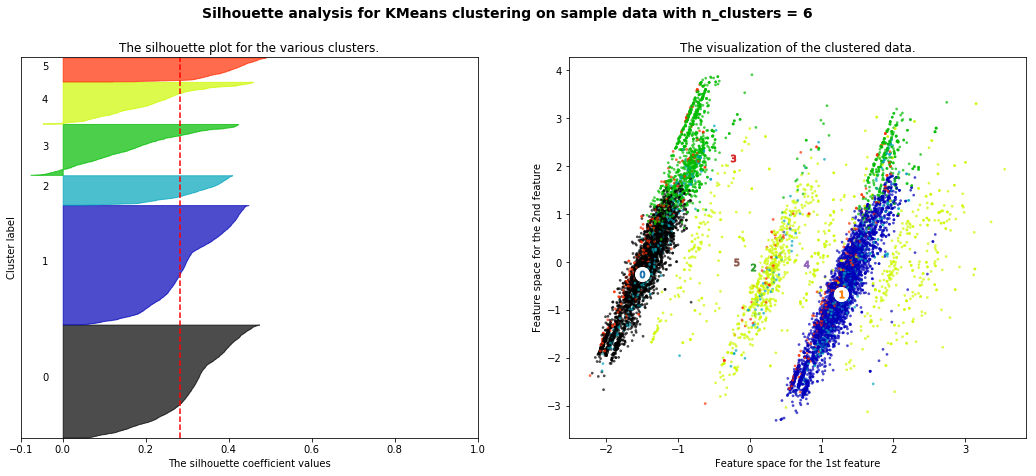

In [296]:
print_silhouette_analysis(x_train_transformed_pca)

For n_clusters = 2 The average silhouette_score is : 0.294457965975


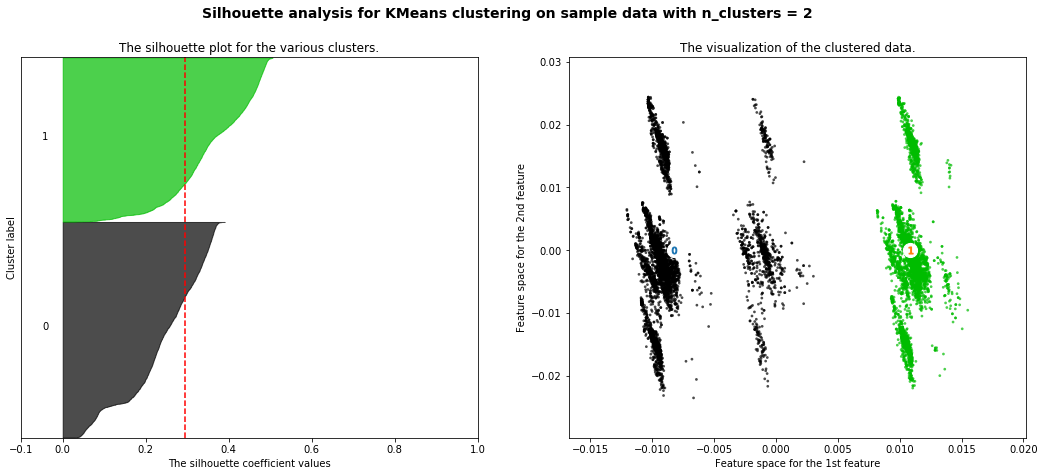

For n_clusters = 3 The average silhouette_score is : 0.355482253143


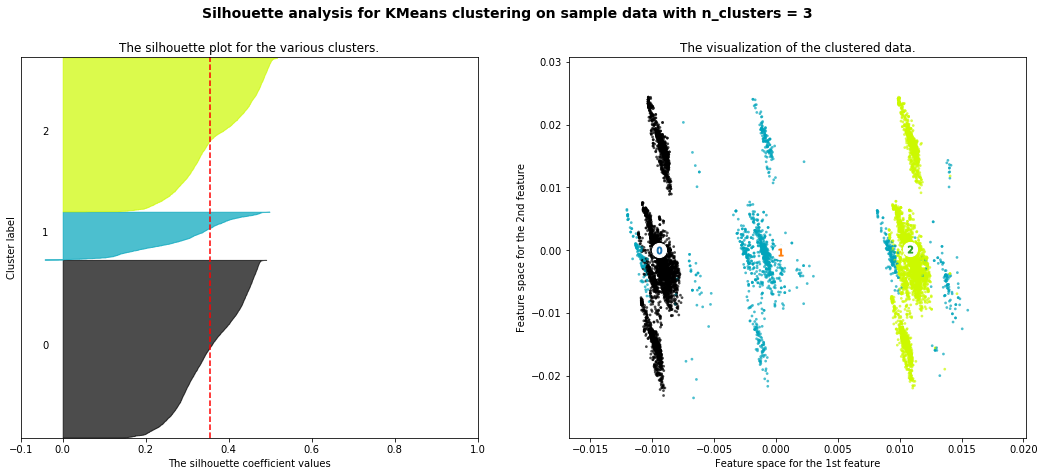

For n_clusters = 4 The average silhouette_score is : 0.376554798296


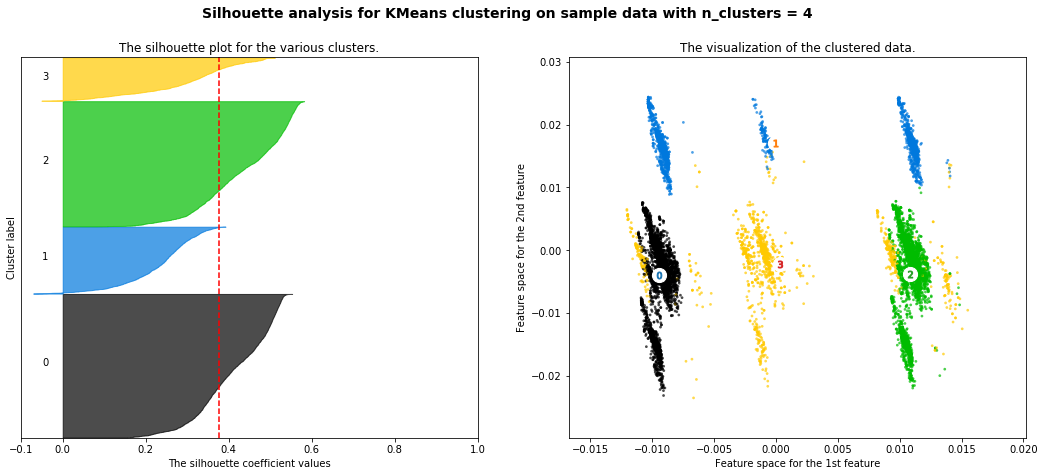

For n_clusters = 5 The average silhouette_score is : 0.348882110478


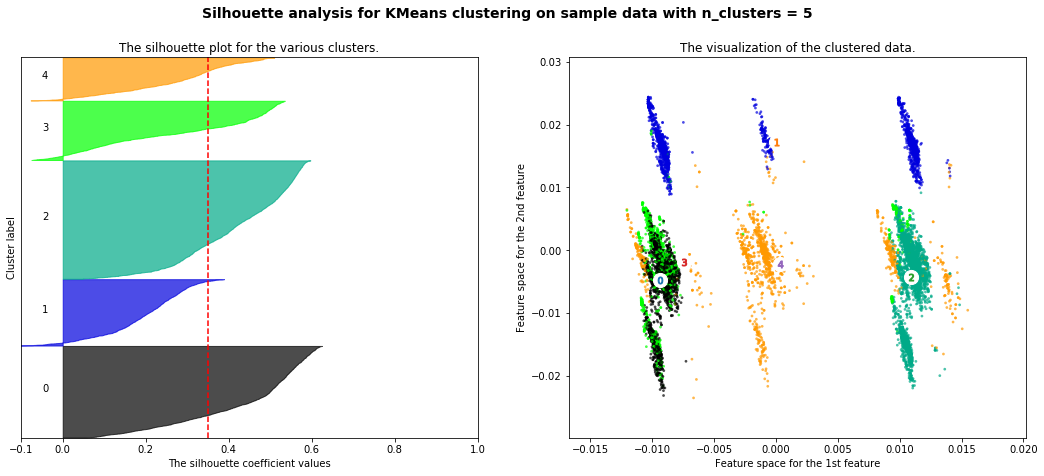

For n_clusters = 6 The average silhouette_score is : 0.319903869928


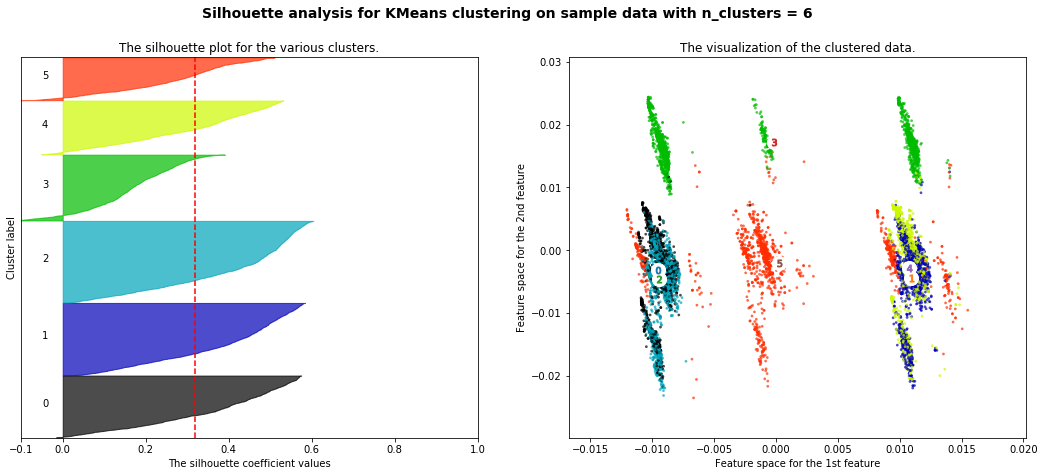

In [298]:
print_silhouette_analysis(x_train_transformed_ica)

For n_clusters = 2 The average silhouette_score is : 0.254627364629


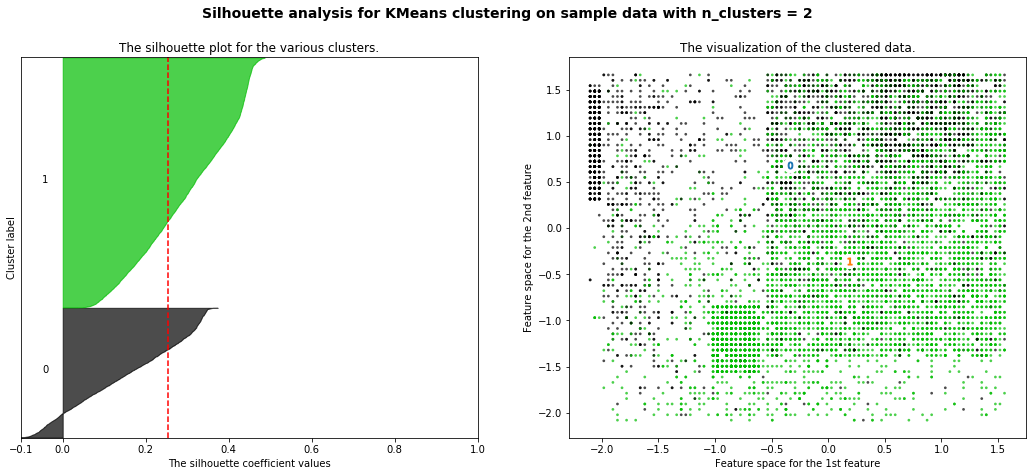

For n_clusters = 3 The average silhouette_score is : 0.242764577423


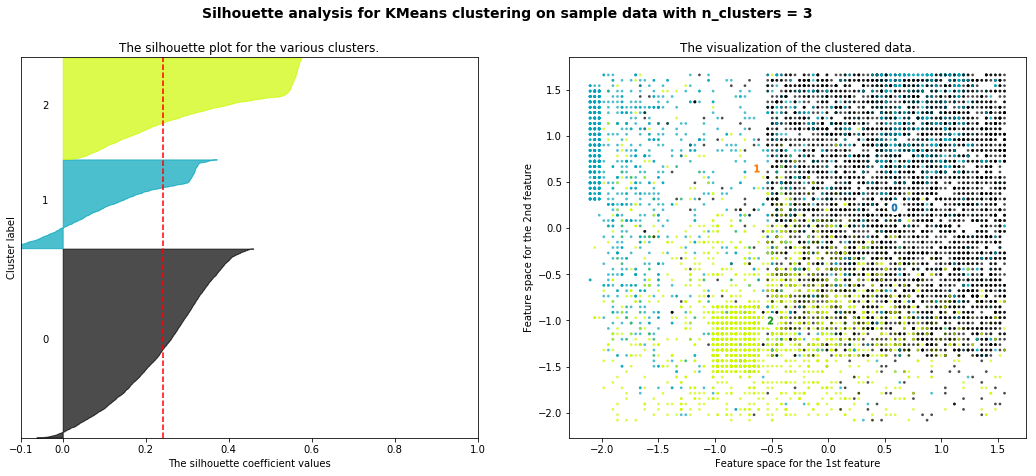

For n_clusters = 4 The average silhouette_score is : 0.27908527329


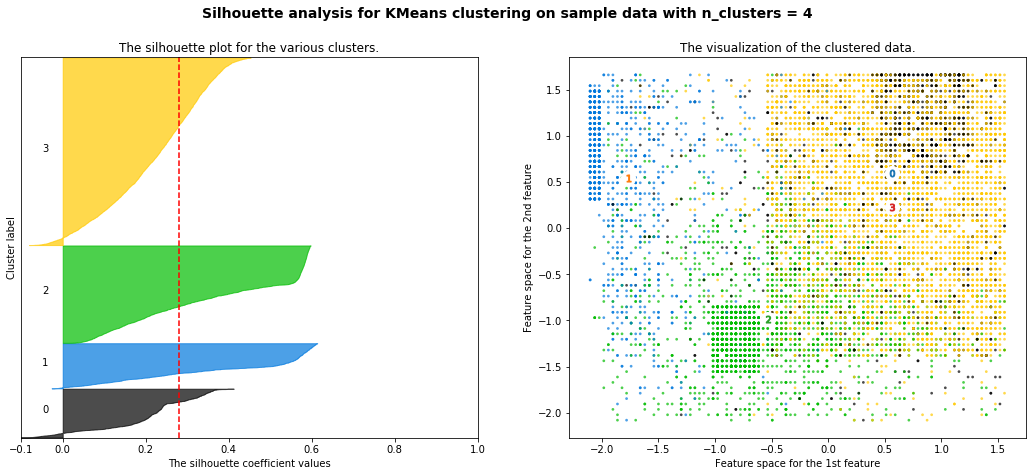

For n_clusters = 5 The average silhouette_score is : 0.261758996432


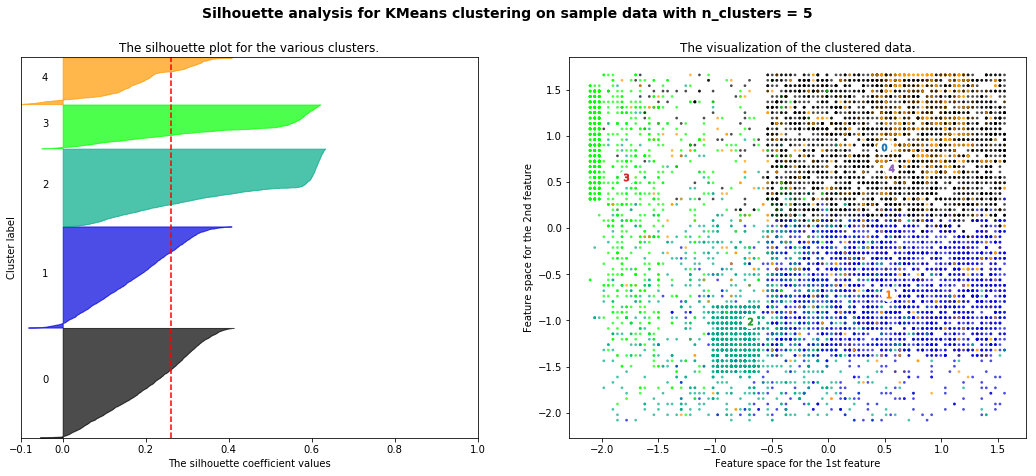

For n_clusters = 6 The average silhouette_score is : 0.267975229722


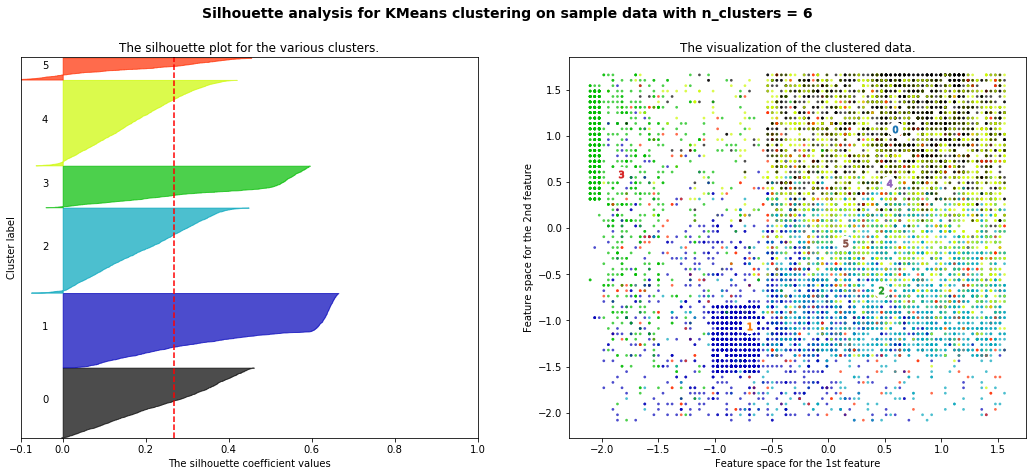

In [297]:
print_silhouette_analysis(x_train_transformed_tree)

#### EM

### Letter Recognition

In [346]:
pca = PCA(n_components=10)
x_train_transformed_pca = pca.fit_transform(X_train_letter)

pca_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_pca)
    labels = kmeans.labels_
    pca_silhouette_scores.append(silhouette_score(x_train_transformed_pca, labels, metric='euclidean'))

In [347]:
ica = FastICA(n_components=4)
x_train_transformed_ica = ica.fit_transform(X_train_letter)

ica_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_ica)
    labels = kmeans.labels_
    ica_silhouette_scores.append(silhouette_score(x_train_transformed_ica, labels, metric='euclidean'))

In [348]:
rca = random_projection.GaussianRandomProjection(n_components=10)
x_train_transformed_rca = rca.fit_transform(X_train_letter)

rca_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_rca)
    labels = kmeans.labels_
    rca_silhouette_scores.append(silhouette_score(x_train_transformed_rca, labels, metric='euclidean'))

In [349]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train_letter, y_train_letter)
model = SelectFromModel(clf, prefit=True)
x_train_transformed_tree = model.transform(X_train_letter)

tree_silhouette_scores = []
for i in range(2,28,4):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_train_transformed_tree)
    labels = kmeans.labels_
    tree_silhouette_scores.append(silhouette_score(x_train_transformed_tree, labels, metric='euclidean'))

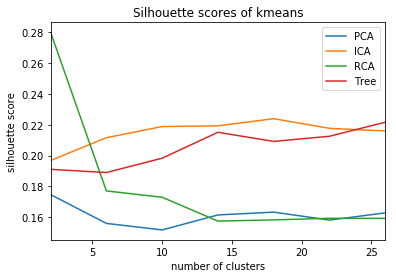

In [350]:
silhouette_df = pd.DataFrame([pca_silhouette_scores, ica_silhouette_scores, rca_silhouette_scores, tree_silhouette_scores])
silhouette_df = silhouette_df.T
silhouette_df.columns= ['PCA', 'ICA', 'RCA', 'Tree']
silhouette_df.index = range(2,28,4)
ax = silhouette_df.plot(title='Silhouette scores of kmeans')
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouette score')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.196356206419


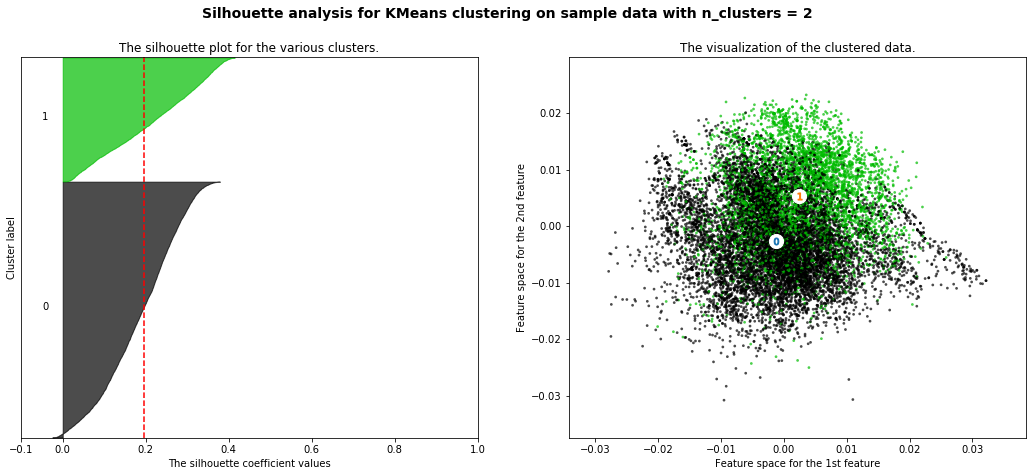

For n_clusters = 3 The average silhouette_score is : 0.213952643715


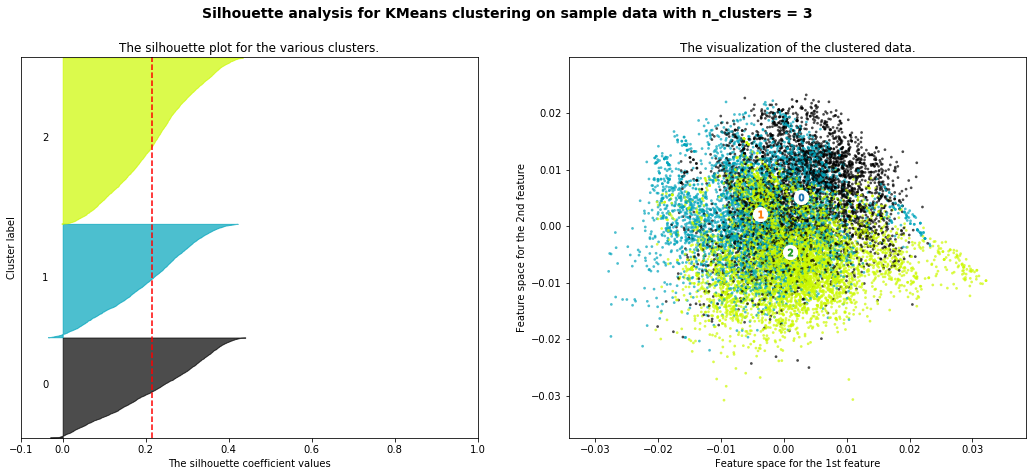

For n_clusters = 4 The average silhouette_score is : 0.218907046272


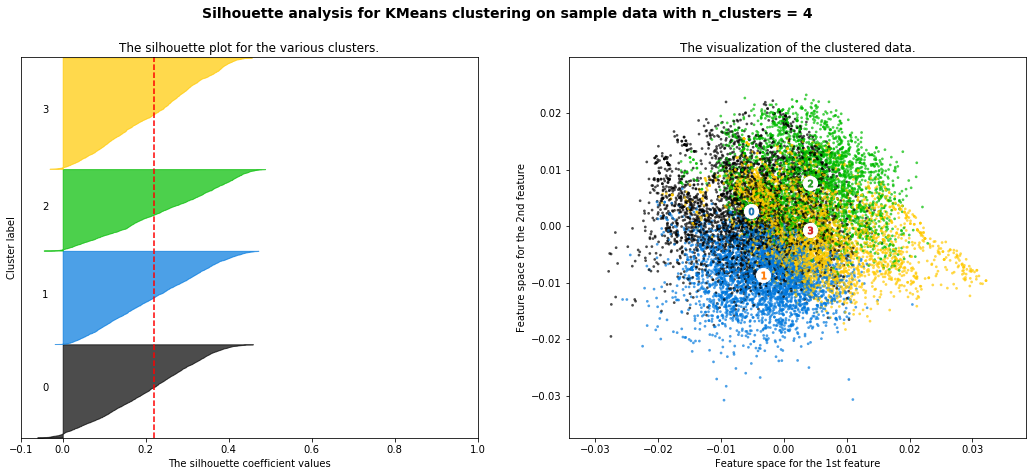

For n_clusters = 5 The average silhouette_score is : 0.22079808288


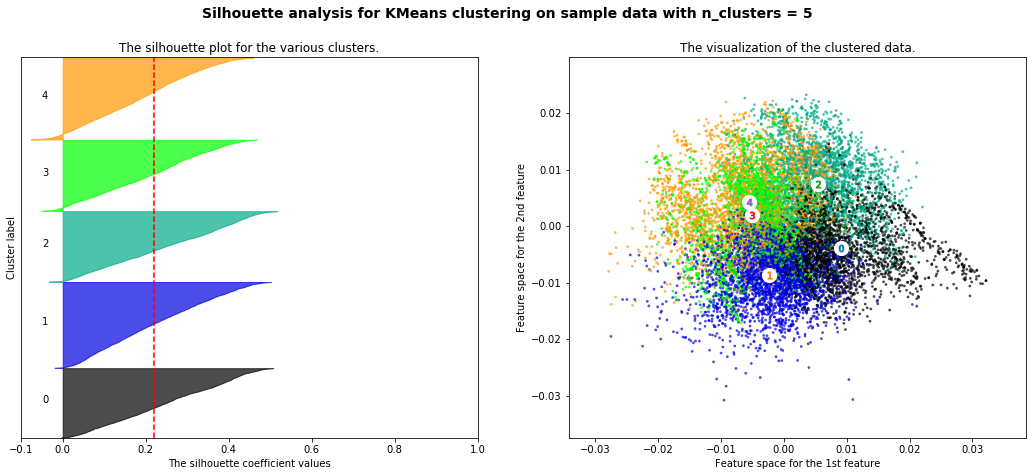

For n_clusters = 6 The average silhouette_score is : 0.211938469181


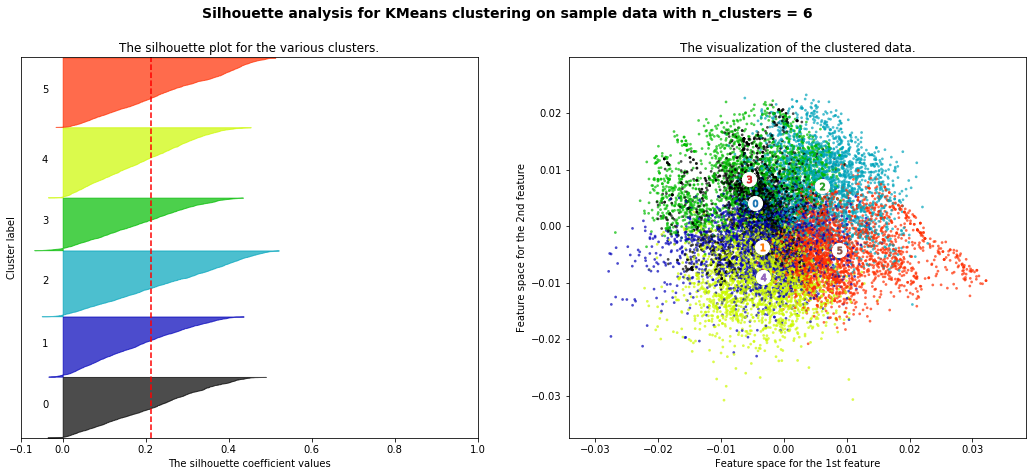

In [351]:
print_silhouette_analysis(x_train_transformed_ica)

For n_clusters = 2 The average silhouette_score is : 0.191063191532


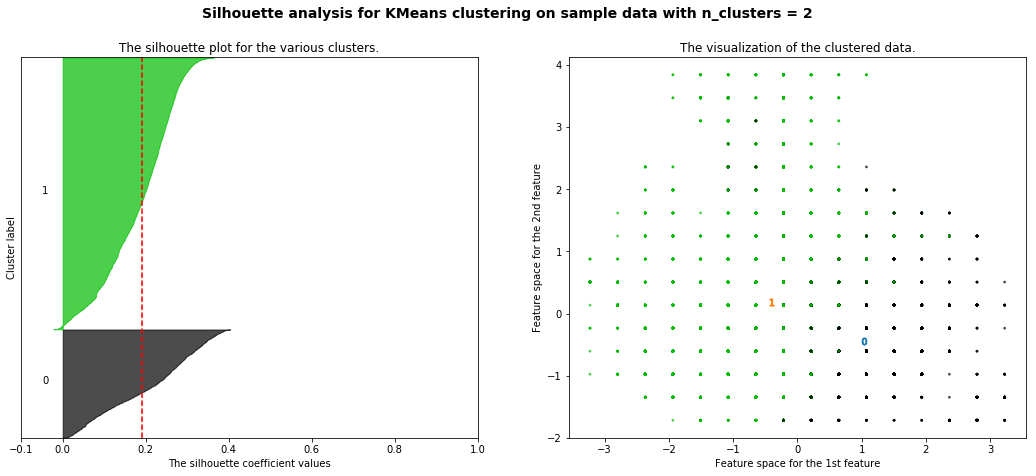

For n_clusters = 3 The average silhouette_score is : 0.169605475548


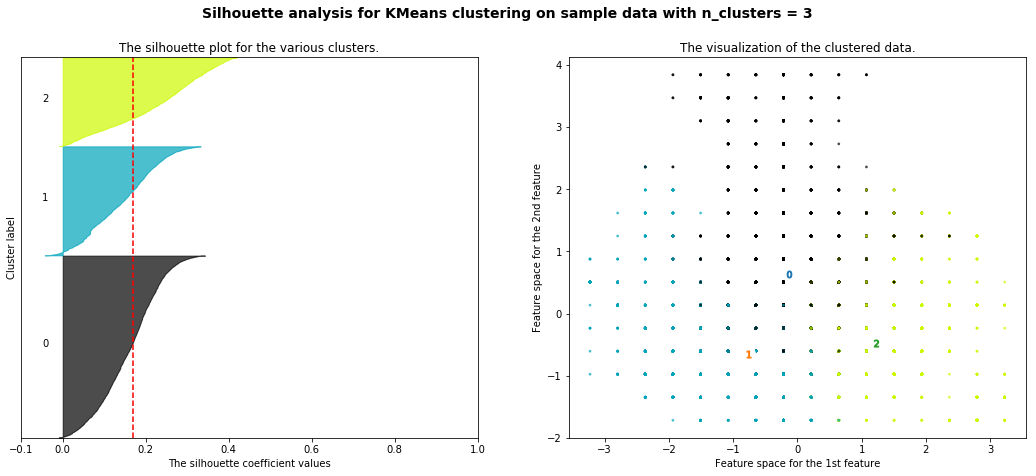

For n_clusters = 4 The average silhouette_score is : 0.160748945522


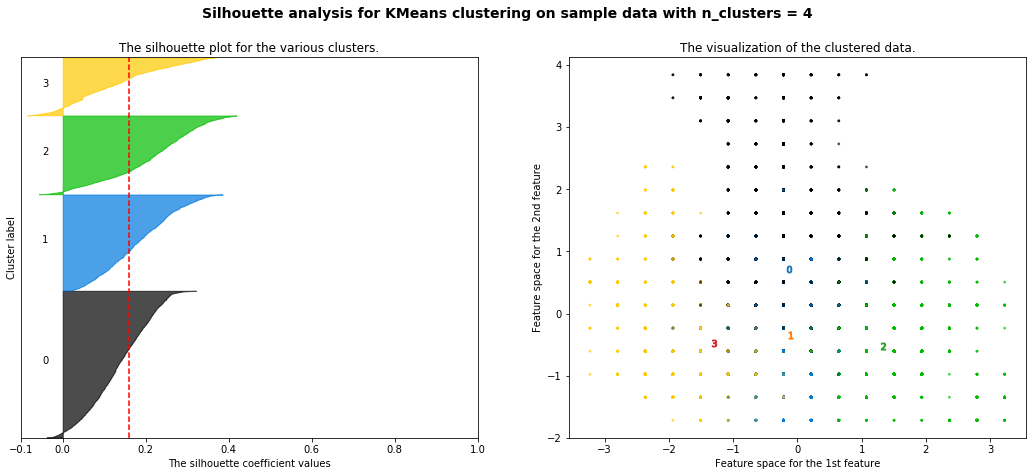

For n_clusters = 5 The average silhouette_score is : 0.179442917622


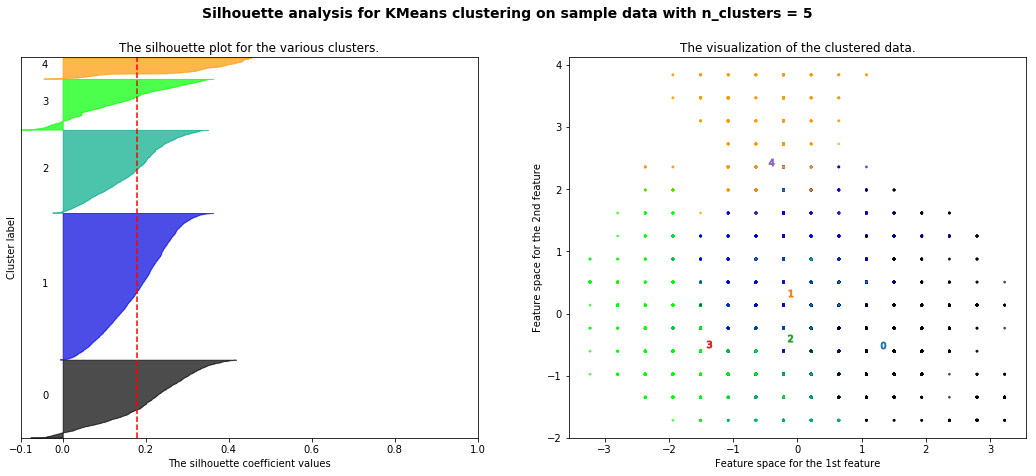

For n_clusters = 6 The average silhouette_score is : 0.186810704923


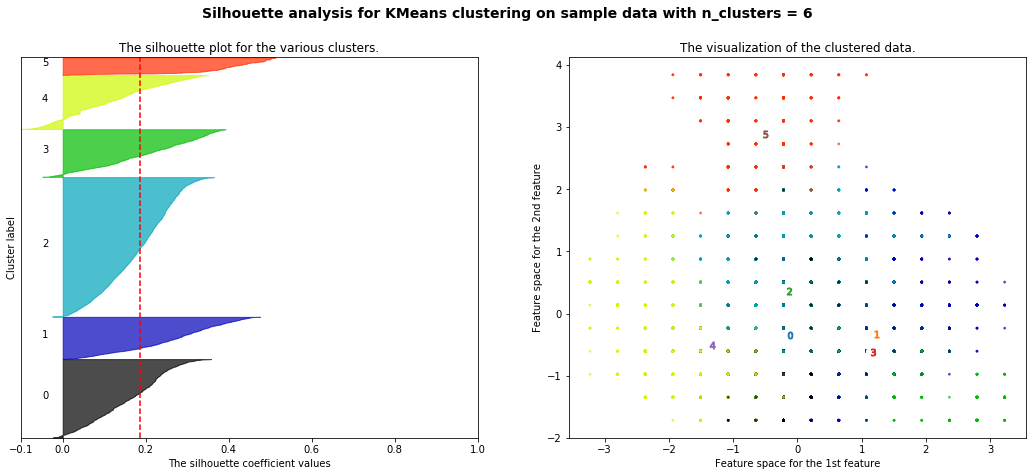

In [352]:
print_silhouette_analysis(x_train_transformed_tree)

## clustering as features

In [330]:
pca = PCA(n_components=7)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
kmeans = KMeans(n_clusters=25, random_state=0).fit(x_train_transformed_pca)
labels = kmeans.labels_
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
labels = kmeans.fit(x_test_transformed_pca).labels_
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

pca_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

In [329]:
pca = FastICA(n_components=4)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
kmeans = KMeans(n_clusters=22, random_state=0).fit(x_train_transformed_pca)
labels = kmeans.labels_
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
labels = kmeans.fit(x_test_transformed_pca).labels_
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

ica_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

In [331]:
pca = random_projection.GaussianRandomProjection(n_components=16)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
kmeans = KMeans(n_clusters=25, random_state=0).fit(x_train_transformed_pca)
labels = kmeans.labels_
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
labels = kmeans.fit(x_test_transformed_pca).labels_
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

rca_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

In [337]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train_hr, y_train_hr)
model = SelectFromModel(clf, prefit=True)
x_train_transformed_tree = model.transform(X_train_hr)
kmeans = KMeans(n_clusters=8, random_state=0).fit(x_train_transformed_tree)
labels = kmeans.labels_

x_train_transformed_tree = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_tree['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_tree.values, y_train_hr)

clf = ExtraTreesClassifier()
clf = clf.fit(X_test_hr, y_test_hr)
model = SelectFromModel(clf, prefit=True)
x_test_transformed_pca = model.transform(X_test_hr)
labels = kmeans.fit(x_test_transformed_pca).labels_
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

x_test_transformed_pca

#tree_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

0         1         2         3         4  label
0     0.149490  1.424944  0.971113  0.499578 -1.026126      7
1     1.074587  0.490165 -0.651538 -0.701829 -1.026126      4
2     0.310376  1.541791 -0.651538  0.259297 -1.026126      7
3    -0.815830 -1.437818 -1.462863 -0.942110 -0.341235      2
4     1.034366  0.256470  0.971113  1.060235 -1.026126      7
5     0.431041  0.957554 -0.651538  0.459532 -0.341235      7
6     1.476804  0.373317  0.159788 -0.922087 -0.341235      4
7    -1.781149  0.256470  0.159788  1.580845  1.028546      5
8    -1.660484  1.541791  0.159788 -0.701829  0.343655      0
9    -1.821371  1.074402  0.971113  1.140329 -0.341235      5
10    0.632149  1.132825  0.971113  0.699813  1.028546      3
11    0.229933 -0.035649  0.159788 -0.841993 -1.026126      4
12   -0.292948  0.373317 -0.651538 -0.902063  2.398327      6
13    0.632149  0.957554 -1.462863 -0.641758 -0.341235      4
14    0.511484  1.600215 -1.462863  1.520775 -0.341235      7
15   -0.091840  0.139622 -0.651538  0.779907 -0.341235      7
16    0.471263  1.074402 -0.651538  1.460704 -1.026126      7
17   -0.494057  1.658639 -1.462863 -1.522790  0.343655      4
18    1.235474  1.541791 -0.651538  1.120305 -0.341235      7
19    0.591928 -1.320970  0.971113  0.839977 -0.341235      1
20   -0.413613 -0.444615 -0.651538  1.320540 -1.026126      1
21   -0.735386 -0.853580 -1.462863 -0.882040 -0.341235      2
22   -2.022479  1.366520  1.782438  1.560821  0.343655      5
23    0.551706  1.191249 -0.651538 -0.041055 -0.341235      7
24   -0.654943 -0.853580 -1.462863 -0.862016 -0.341235      2
25    0.953923  1.424944  0.159788  0.319367  1.028546      3
26   -0.775608 -1.379394 -1.462863 -1.162368 -0.341235      2
27    0.109268  1.366520  0.159788 -0.041055  0.343655      7
28    0.149490  1.366520 -1.462863 -0.421500 -1.026126      4
29   -1.620263 -2.022055  0.159788 -1.442697  0.343655      2
...        ...       ...       ...       ...       ...    ...
4470 -0.292948 -1.145699  0.159788 -0.561665 -1.026126      1
4471  1.114809  0.081199 -0.651538 -0.641758 -0.341235      4
4472  0.390820  1.483368 -0.651538  0.359414 -0.341235      7
4473  0.189711 -0.736733  0.159788 -0.441524 -0.341235      1
4474 -0.011397  1.015978  0.159788  0.819954 -1.026126      7
4475  0.069046 -1.262546 -0.651538 -1.222439 -1.026126      2
4476 -0.815830 -0.503038  0.971113  1.240446 -0.341235      0
4477  1.315917  0.490165  0.159788  1.300517 -0.341235      7
4478 -1.016938 -1.788360 -0.651538 -0.681805  4.452998      6
4479 -0.735386 -1.204123 -1.462863 -1.222439 -0.341235      2
4480  0.833258 -0.912004  0.971113 -0.421500 -0.341235      1
4481  0.712593  1.308097  0.159788  0.619719  1.028546      3
4482 -1.258268 -1.437818  1.782438 -0.902063 -1.026126      0
4483 -0.936495  1.658639  0.971113 -1.282509  0.343655      0
4484 -0.815830 -1.379394 -1.462863 -1.202415 -0.341235      2
4485 -0.292948 -1.087275 -0.651538  1.000165 -1.026126      1
4486  0.229933 -0.970428 -0.651538 -0.521618 -1.026126      1
4487  0.873479 -0.035649  0.159788 -0.101125 -1.026126      1
4488  1.476804 -1.320970  0.159788  0.259297 -0.341235      1
4489 -2.062701  0.723860  1.782438  0.900048  0.343655      5
4490 -0.011397 -0.210920  0.971113  0.479555  0.343655      1
4491 -0.172283  0.957554 -0.651538 -0.501594 -0.341235      4
4492 -0.212505 -0.210920  0.971113  0.039039 -1.026126      1
4493 -0.654943 -1.028852 -1.462863 -1.222439 -0.341235      2
4494  0.069046 -0.970428 -0.651538 -0.821970 -0.341235      2
4495  0.953923  0.548588  0.159788  1.180376 -0.341235      7
4496 -1.620263 -1.671512 -1.462863  0.960118 -0.341235      2
4497  0.672371 -1.087275 -0.651538 -0.902063 -0.341235      1
4498  1.275696 -0.795157  0.971113  0.739860 -1.026126      1
4499  0.109268 -0.970428 -0.651538  0.900048 -1.026126      1

[4500 rows x 6 columns]

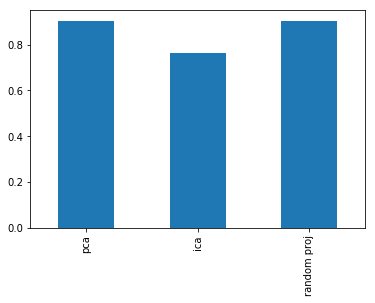

In [340]:
pd.DataFrame([pca_score, ica_score, rca_score], index=['pca', 'ica', 'random proj']).plot(kind='bar', legend=False)

In [342]:
pca = PCA(n_components=7)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
gmm = mixture.GaussianMixture(n_components=25, covariance_type='diag')
gmm.fit(x_train_transformed_pca)
labels = gmm.predict(x_train_transformed_pca)
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
gmm.fit(x_test_transformed_pca)
labels = gmm.predict(x_test_transformed_pca)
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

pca_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

In [344]:
pca = FastICA(n_components=4)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
gmm = mixture.GaussianMixture(n_components=25, covariance_type='diag')
gmm.fit(x_train_transformed_pca)
labels = gmm.predict(x_train_transformed_pca)
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
gmm.fit(x_test_transformed_pca)
labels = gmm.predict(x_test_transformed_pca)
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

ica_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

In [343]:
pca = random_projection.GaussianRandomProjection(n_components=16)
x_train_transformed_pca = pca.fit_transform(X_train_hr)
gmm = mixture.GaussianMixture(n_components=25, covariance_type='diag')
gmm.fit(x_train_transformed_pca)
labels = gmm.predict(x_train_transformed_pca)
x_train_transformed_pca = pd.DataFrame(x_train_transformed_pca)
x_train_transformed_pca['label'] = labels

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 3), random_state=1)
ann_clf.fit(x_train_transformed_pca.values, y_train_hr)

x_test_transformed_pca = pca.transform(X_test_hr)
gmm.fit(x_test_transformed_pca)
labels = gmm.predict(x_test_transformed_pca)
x_test_transformed_pca = pd.DataFrame(x_test_transformed_pca)
x_test_transformed_pca['label'] = labels

rca_score = ann_clf.score(x_test_transformed_pca.values, y_test_hr)

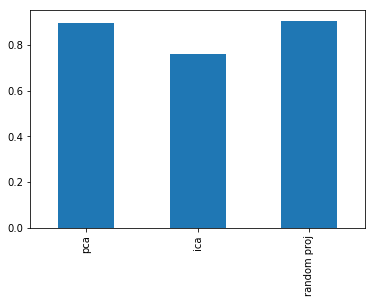

In [345]:
pd.DataFrame([pca_score, ica_score, rca_score], index=['pca', 'ica', 'random proj']).plot(kind='bar', legend=False)